<a href="https://colab.research.google.com/github/Minwoo-study/Project_Uri/blob/main/Project_Uri_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### 패키지 설치

패키지는 한 번 설치 후에 런타임 다시시작해서 다시 돌려야 정상 설치 가능합니다

In [1]:
# 나눔고딕 설치
!apt-get update -qq
!apt-get install fonts-nanum* -qq
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

# # 패키지 설치
!pip install -U kiwipiepy gensim pandas-read-xml kss -q

/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 31 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/var/cache/fontconfig: cleaning cache directory
/root/.cache/fontconfig: not cleaning non-existent cache directory
/root/.fontconfig: not cleaning non-existent cache directory
fc-cache: succeeded


In [2]:
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
tqdm.pandas()

import matplotlib.pyplot as plt
import matplotlib as mpl
# 그래프에서 마이너스 폰트 깨지는 문제에 대한 대처
mpl.rcParams['axes.unicode_minus'] = False
plt.rc('font', family='NanumBarunGothic')
font_path = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
import matplotlib.colors as clr

from collections import Counter
import regex
import re

from kiwipiepy import Kiwi, Option
kiwi = Kiwi()
kiwi.prepare()

import sys

import pandas_read_xml as pdx
from pandas_read_xml import flatten, fully_flatten, auto_separate_tables

from kss import split_sentences
import itertools
from collections import defaultdict
import pickle

import nltk
from nltk import collocations
from gensim.test.utils import common_texts
from gensim.models import Word2Vec
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: DeprecationWarning: `prepare()` has no effect and will be removed in future version.
[Korean Sentence Splitter]: Initializing Kss...


Text(0.5, 0, '시간(분)')

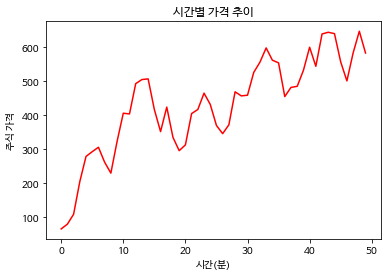

In [3]:
# plot 한글 깨짐 확인용
data = np.random.randint(-100, 100, 50).cumsum()
plt.plot(range(50), data, 'r')
# mpl.rcParams['axes.unicode_minus'] = False
plt.title('시간별 가격 추이')
plt.ylabel('주식 가격')
plt.xlabel('시간(분)')

### 전처리


In [4]:
# 위키문헌 xml 파일 다운
# https://drive.google.com/file/d/15yJtJ11rFwxbLMS3Sqyl-YboxFhgoxT2/view?usp=sharing
!curl -c ./cookie -s -L "https://drive.google.com/uc?export=download&id=15yJtJ11rFwxbLMS3Sqyl-YboxFhgoxT2" > /dev/null
!curl -Lb ./cookie "https://drive.google.com/uc?export=download&confirm=`awk '/download/ {print $NF}' ./cookie`&id=15yJtJ11rFwxbLMS3Sqyl-YboxFhgoxT2" -o kowikisource2_sep.xml

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   408    0   408    0     0   2358      0 --:--:-- --:--:-- --:--:--  2358
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  206M    0  206M    0     0   103M      0 --:--:--  0:00:02 --:--:--  146M


In [6]:
# xml 파일 읽기
df = pdx.read_xml('kowikisource2_sep.xml', ['wikisource'])
df

,doc
0,"[{'@id': '1', '@url': 'https://ko.wikisource.o..."


In [7]:
df = df.pipe(flatten)
df

,doc
0,"{'@id': '1', '@url': 'https://ko.wikisource.or..."
1,"{'@id': '2', '@url': 'https://ko.wikisource.or..."
2,"{'@id': '3', '@url': 'https://ko.wikisource.or..."
3,"{'@id': '7', '@url': 'https://ko.wikisource.or..."
4,"{'@id': '14', '@url': 'https://ko.wikisource.o..."
...,...
24099,"{'@id': '52620', '@url': 'https://ko.wikisourc..."
24100,"{'@id': '52621', '@url': 'https://ko.wikisourc..."
24101,"{'@id': '52622', '@url': 'https://ko.wikisourc..."
24102,"{'@id': '52623', '@url': 'https://ko.wikisourc..."


In [8]:
df = df.pipe(flatten)
df

,doc|@id,doc|@url,doc|@title,doc
0,1,https://ko.wikisource.org/wiki?curid=1,애국가 (대한민국),애국가 (대한민국)\n\n한자 혼용
1,2,https://ko.wikisource.org/wiki?curid=2,대한민국 헌법 (한자혼용),대한민국 헌법 (한자혼용)\n\n<sep> 한글 전용 표기
2,3,https://ko.wikisource.org/wiki?curid=3,조선민주주의인민공화국 사회주의헌법,조선민주주의인민공화국 사회주의헌법\n\n서문.\n조선민주주의인민공화국은 위대한 김일...
3,7,https://ko.wikisource.org/wiki?curid=7,대한민국 한글 맞춤법(제88-1호),대한민국 한글 맞춤법(제88-1호)\n\n<sep>==제1장 총 칙==<sep>제 ...
4,14,https://ko.wikisource.org/wiki?curid=14,"민법 (대한민국, 제8720호)","민법 (대한민국, 제8720호)\n\n<sep>== 제1편 총칙 ==<sep>===..."
...,...,...,...,...
24099,52620,https://ko.wikisource.org/wiki?curid=52620,가덕도신공항 거설을 위한 특별법 (제17938호),가덕도신공항 거설을 위한 특별법 (제17938호)
24100,52621,https://ko.wikisource.org/wiki?curid=52621,가덕도신공항 건설을 위한 특별법,가덕도신공항 건설을 위한 특별법\n\n<sep>== 연혁 ==
24101,52622,https://ko.wikisource.org/wiki?curid=52622,국가경찰위원회 규정 (제31380호),국가경찰위원회 규정 (제31380호)\n\n<onlyinclude>
24102,52623,https://ko.wikisource.org/wiki?curid=52623,경찰위원회규정,경찰위원회규정


In [9]:
df.pipe(flatten)

,doc|@id,doc|@url,doc|@title,doc
0,1,https://ko.wikisource.org/wiki?curid=1,애국가 (대한민국),애국가 (대한민국)\n\n한자 혼용
1,2,https://ko.wikisource.org/wiki?curid=2,대한민국 헌법 (한자혼용),대한민국 헌법 (한자혼용)\n\n<sep> 한글 전용 표기
2,3,https://ko.wikisource.org/wiki?curid=3,조선민주주의인민공화국 사회주의헌법,조선민주주의인민공화국 사회주의헌법\n\n서문.\n조선민주주의인민공화국은 위대한 김일...
3,7,https://ko.wikisource.org/wiki?curid=7,대한민국 한글 맞춤법(제88-1호),대한민국 한글 맞춤법(제88-1호)\n\n<sep>==제1장 총 칙==<sep>제 ...
4,14,https://ko.wikisource.org/wiki?curid=14,"민법 (대한민국, 제8720호)","민법 (대한민국, 제8720호)\n\n<sep>== 제1편 총칙 ==<sep>===..."
...,...,...,...,...
24099,52620,https://ko.wikisource.org/wiki?curid=52620,가덕도신공항 거설을 위한 특별법 (제17938호),가덕도신공항 거설을 위한 특별법 (제17938호)
24100,52621,https://ko.wikisource.org/wiki?curid=52621,가덕도신공항 건설을 위한 특별법,가덕도신공항 건설을 위한 특별법\n\n<sep>== 연혁 ==
24101,52622,https://ko.wikisource.org/wiki?curid=52622,국가경찰위원회 규정 (제31380호),국가경찰위원회 규정 (제31380호)\n\n<onlyinclude>
24102,52623,https://ko.wikisource.org/wiki?curid=52623,경찰위원회규정,경찰위원회규정


In [10]:
# 문학(산문) 작품만 가져오기
# https://drive.google.com/file/d/1c1qbbX1vwZfH3dAV7Ffj8WhVH4d5bifD/view?usp=sharing
!wget --no-check-certificate 'https://drive.google.com/uc?export=download&id=1c1qbbX1vwZfH3dAV7Ffj8WhVH4d5bifD' -O 210426_위키문헌_작품목록_통합.csv

--2021-10-01 03:31:11--  https://drive.google.com/uc?export=download&id=1c1qbbX1vwZfH3dAV7Ffj8WhVH4d5bifD
Resolving drive.google.com (drive.google.com)... 173.194.74.101, 173.194.74.100, 173.194.74.113, ...
Connecting to drive.google.com (drive.google.com)|173.194.74.101|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-10-5s-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/mfik23enqu4c5qvonld6pg3kdnejpgkr/1633059000000/12350511020204598408/*/1c1qbbX1vwZfH3dAV7Ffj8WhVH4d5bifD?e=download [following]
--2021-10-01 03:31:11--  https://doc-10-5s-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/mfik23enqu4c5qvonld6pg3kdnejpgkr/1633059000000/12350511020204598408/*/1c1qbbX1vwZfH3dAV7Ffj8WhVH4d5bifD?e=download
Resolving doc-10-5s-docs.googleusercontent.com (doc-10-5s-docs.googleusercontent.com)... 209.85.200.132, 2607:f8b0:4001:c16::84
Connecting to doc-10-5s-docs.googleusercontent.com (doc-10

In [11]:
article =pd.read_csv('210426_위키문헌_작품목록_통합.csv')
article

,종류,작품명,위키제목,저자,출처,연도,시대,시대_N
0,노래,애국가,애국가 (대한민국),윤치호,NaN,1897,1890,E1
1,수필,시일야방성대곡,시일야방성대곡,장지연,황성신문,1905,1900,E1
2,소설,혈의 누,혈의 누/현대어 해석,이인직,만세보,1906,1900,E1
3,신소설,귀의 성,귀의 성,이인직,NaN,1907,1900,E1
4,시,가을 뜻,가을 뜻,최남선,NaN,1908,1900,E1
...,...,...,...,...,...,...,...,...
2432,수필,허식의 변,허식의 변,김상용,NaN,미상,미상,NaN
2433,소설,홍윤성과 절부,홍윤성과 절부,윤백남,NaN,미상,미상,NaN
2434,시,화제,화제,이육사,NaN,미상,미상,NaN
2435,시,황해의 첫봄,황해의 첫봄,김억,NaN,미상,미상,NaN


In [12]:
article[article['시대']=='미상']


,종류,작품명,위키제목,저자,출처,연도,시대,시대_N
2317,노래,개천절 노래,개천절 노래,정인보,NaN,미상,미상,NaN
2318,한시,見月[견월],견월,한용운,NaN,미상,미상,NaN
2319,소설,경벌포의(警罰布衣),경벌포의,윤백남,NaN,미상,미상,NaN
2321,시,近吟 三首[근음 삼수],근음 삼수,변영로,NaN,미상,미상,NaN
2322,수필,奇異[기이]한 湖沼傳說[호소전설],기이한 호소전설,최남선,NaN,미상,미상,NaN
...,...,...,...,...,...,...,...,...
2432,수필,허식의 변,허식의 변,김상용,NaN,미상,미상,NaN
2433,소설,홍윤성과 절부,홍윤성과 절부,윤백남,NaN,미상,미상,NaN
2434,시,화제,화제,이육사,NaN,미상,미상,NaN
2435,시,황해의 첫봄,황해의 첫봄,김억,NaN,미상,미상,NaN


In [13]:
# 시대 '미상' 제거
article = article[article['시대']!='미상']

In [14]:
# 소설, 수필, 신소설, 동화, 평론, 칼럼만 포함
valid_title = article.loc[article['종류'].isin(['소설','수필','동화','신소설','칼럼','평론','희곡','격문','금석문','추도사','퇴임사','담화문']),'위키제목'].to_list()
len(valid_title)

1152

In [15]:
# 시대별 작품수
article.loc[article['종류'].isin(['소설','수필','동화','신소설','칼럼','평론','희곡','격문','금석문','추도사','퇴임사','담화문']),'시대_N'].value_counts().sort_index()

E1     73
E2    819
E3    259
Name: 시대_N, dtype: int64

In [16]:
article_n =article[article['종류'].isin(['소설','수필','동화','신소설','칼럼','평론','희곡','격문','금석문','추도사','퇴임사','담화문'])]
article_n

,종류,작품명,위키제목,저자,출처,연도,시대,시대_N
1,수필,시일야방성대곡,시일야방성대곡,장지연,황성신문,1905,1900,E1
2,소설,혈의 누,혈의 누/현대어 해석,이인직,만세보,1906,1900,E1
3,신소설,귀의 성,귀의 성,이인직,NaN,1907,1900,E1
6,신소설,구마검(驅魔劒),구마검,이해조,NaN,1908,1900,E1
7,신소설,금수회의록,금수회의록,안국선,NaN,1908,1900,E1
...,...,...,...,...,...,...,...,...
2157,소설,애인,애인/9장,김내성,NaN,1954,1950,E3
2164,수필,예창신고,예창신고,최남선,NaN,1956,1950,E3
2166,수필,정당무용지변,정당무용지변,최남선,NaN,1956,1950,E3
2169,소설,백조의 곡,백조의 곡,김내성,NaN,1957,1950,E3


In [17]:
# valid_title Filter
df = df.loc[df['doc|@title'].isin(valid_title)]
df

,doc|@id,doc|@url,doc|@title,doc
24,1350,https://ko.wikisource.org/wiki?curid=1350,백범일지,백범일지\n\n저자의 말.\n하여서 딱 거절하였다.<sep>그런즉 일인이 다시 말하...
35,1370,https://ko.wikisource.org/wiki?curid=1370,날개,날개\n\n<sep>‘박제가 되어 버린 천재’를 아시오? 나는 유쾌하오. 이런 때 ...
129,1810,https://ko.wikisource.org/wiki?curid=1810,산골 나그네,산골 나그네\n\n<sep>밤이 깊어도 술군은 역시들지 않는다. 메주 뜨는 냄새와 ...
132,1847,https://ko.wikisource.org/wiki?curid=1847,달을 쏘다,달을 쏘다\n\n<sep>번거롭던 사위(四圍)가 잠잠해지고 시계 소리가 또렷하나 보...
135,1852,https://ko.wikisource.org/wiki?curid=1852,지팽이 역사,지팽이 역사\n\n<sep>아침에 깨이기는 일찍 깨었다는 증거로 닭 우는 소리를 들...
...,...,...,...,...
22714,49942,https://ko.wikisource.org/wiki?curid=49942,대행애사,대행애사\n\n<sep>병인사월이십오일(丙寅四月二十五日)에 대행(大行)이 등하(登遐...
22718,49948,https://ko.wikisource.org/wiki?curid=49948,이충무공 묘산경매문제,이충무공 묘산경매문제\n\n일.\n환구오주(寰球五洲)에 어느 땅을 무를 것 없이 그...
23644,52075,https://ko.wikisource.org/wiki?curid=52075,가을과 산양,가을과 산양\n\n<sep>화단 위 해바라기 송이가 칙칙하게 시들었을 젠 벌써 가을...
23759,52207,https://ko.wikisource.org/wiki?curid=52207,가로의 요술사,"가로의 요술사\n\n<sep>“자 똑똑히 들어보세요, 똑똑히.”<sep>다 낡아서 ..."


In [18]:
# article, df Merge (inner)
df = df.merge(article,left_on='doc|@title',right_on='위키제목')
df

,doc|@id,doc|@url,doc|@title,doc,종류,작품명,위키제목,저자,출처,연도,시대,시대_N
0,1350,https://ko.wikisource.org/wiki?curid=1350,백범일지,백범일지\n\n저자의 말.\n하여서 딱 거절하였다.<sep>그런즉 일인이 다시 말하...,수필,백범일지,백범일지,김구,NaN,1947,1940,E3
1,1370,https://ko.wikisource.org/wiki?curid=1370,날개,날개\n\n<sep>‘박제가 되어 버린 천재’를 아시오? 나는 유쾌하오. 이런 때 ...,소설,날개,날개,이상,NaN,1936,1930,E2
2,1810,https://ko.wikisource.org/wiki?curid=1810,산골 나그네,산골 나그네\n\n<sep>밤이 깊어도 술군은 역시들지 않는다. 메주 뜨는 냄새와 ...,소설,산골 나그네,산골 나그네,김유정,NaN,1933,1930,E2
3,1847,https://ko.wikisource.org/wiki?curid=1847,달을 쏘다,달을 쏘다\n\n<sep>번거롭던 사위(四圍)가 잠잠해지고 시계 소리가 또렷하나 보...,수필,달을 쏘다,달을 쏘다,윤동주,NaN,1948,1940,E3
4,1852,https://ko.wikisource.org/wiki?curid=1852,지팽이 역사,지팽이 역사\n\n<sep>아침에 깨이기는 일찍 깨었다는 증거로 닭 우는 소리를 들...,소설,지팽이 역사,지팽이 역사,이상,매신,1934,1930,E2
...,...,...,...,...,...,...,...,...,...,...,...,...
998,49942,https://ko.wikisource.org/wiki?curid=49942,대행애사,대행애사\n\n<sep>병인사월이십오일(丙寅四月二十五日)에 대행(大行)이 등하(登遐...,추도사,大行哀辭\n 울려해도다시는잇지못할이섧음,대행애사,정인보,NaN,1926,1920,E2
999,49948,https://ko.wikisource.org/wiki?curid=49948,이충무공 묘산경매문제,이충무공 묘산경매문제\n\n일.\n환구오주(寰球五洲)에 어느 땅을 무를 것 없이 그...,칼럼,이충무공 묘산경매문제,이충무공 묘산경매문제,정인보,NaN,1931,1930,E2
1000,52075,https://ko.wikisource.org/wiki?curid=52075,가을과 산양,가을과 산양\n\n<sep>화단 위 해바라기 송이가 칙칙하게 시들었을 젠 벌써 가을...,소설,가을과 산양,가을과 산양,이효석,NaN,1938,1930,E2
1001,52207,https://ko.wikisource.org/wiki?curid=52207,가로의 요술사,"가로의 요술사\n\n<sep>“자 똑똑히 들어보세요, 똑똑히.”<sep>다 낡아서 ...",소설,가로의 요술사,가로의 요술사,이효석,NaN,1926,1920,E2


In [19]:
# reset index
df = df.reset_index(drop=True)

In [20]:
# 전처리 함수화
def preprocess(title,text):
    text = re.sub(f'\n{title}\n\n<sep>','',text)
    text = re.sub(f'^\n{title}\n\n','',text)
    text = re.sub('<sep>\n\n$','',text)
    text = re.sub('\n',' ',text)
    text = re.sub('\=+ \d{1,} \=+(\<sep\>)*','',text)
    text = regex.sub('\=+ \p{Hangul}+ \=+(\<sep\>)*','',text)
    text = regex.sub('\=+ \p{Han}+ \=+(\<sep\>)*','',text)
    text = text.strip()
    text = re.sub('<sep>\n*$','',text)
    text_list = text.split('<sep>')
    text_list = [x.strip() for x in text_list if not re.match('\=+.+\=+',x)]
    # text_list = [x for x in text_list if not re.match('\=+.+\=+',x)]
    return text_list

In [21]:
# 문자열을 문단 구분 기호(<sep>)으로 분절화 list 생성
df['text_list'] = df.progress_apply(lambda x:preprocess(x['doc|@title'],x['doc']),axis=1)
df['text_list']

  0%|          | 0/1003 [00:00<?, ?it/s]

0       [백범일지  저자의 말. 하여서 딱 거절하였다., 그런즉 일인이 다시 말하기를,, ...
1       [날개, ‘박제가 되어 버린 천재’를 아시오? 나는 유쾌하오. 이런 때 연애까지가 ...
2       [산골 나그네, 밤이 깊어도 술군은 역시들지 않는다. 메주 뜨는 냄새와 같이 쾨쾨한...
3       [달을 쏘다, 번거롭던 사위(四圍)가 잠잠해지고 시계 소리가 또렷하나 보니 밤은 저...
4       [지팽이 역사, 아침에 깨이기는 일찍 깨었다는 증거로 닭 우는 소리를 들었는데 또 ...
                              ...                        
998     [대행애사, 병인사월이십오일(丙寅四月二十五日)에 대행(大行)이 등하(登遐)하시다. ...
999     [이충무공 묘산경매문제  일. 환구오주(寰球五洲)에 어느 땅을 무를 것 없이 그 민...
1000    [가을과 산양, 화단 위 해바라기 송이가 칙칙하게 시들었을 젠 벌써 가을이 완연한듯...
1001    [가로의 요술사, “자 똑똑히 들어보세요, 똑똑히.”, 다 낡아서 구리쇠빛으로 변한...
1002    [가지말게, 다 찌그러져가는 우막집!, 이 까짓 것을 누가 단 일 원이라도 내고 사...
Name: text_list, Length: 1003, dtype: object

In [22]:
df[df['text_list'].isna()]

,doc|@id,doc|@url,doc|@title,doc,종류,작품명,위키제목,저자,출처,연도,시대,시대_N,text_list


In [23]:
df[df['text_list'].map(lambda x:len(x)<=2)]

,doc|@id,doc|@url,doc|@title,doc,종류,작품명,위키제목,저자,출처,연도,시대,시대_N,text_list
17,2069,https://ko.wikisource.org/wiki?curid=2069,금수회의록,금수회의록,신소설,금수회의록,금수회의록,안국선,NaN,1908,1900,E1,[금수회의록]
47,2897,https://ko.wikisource.org/wiki?curid=2897,감격과 긴장,감격과 긴장\n\n<sep>우리 문단인이 시국에 깊은 관심을 가지고 내선일체(內鮮一...,수필,감격과 긴장,감격과 긴장,김동인,NaN,1942,1940,E2,"[감격과 긴장, 우리 문단인이 시국에 깊은 관심을 가지고 내선일체(內鮮一體)로 국민..."
50,3056,https://ko.wikisource.org/wiki?curid=3056,경세종,경세종\n\n<sep>경셰죵(警世鐘)<sep>== 一쟝 유산ᄀᆡᆨ들이 서로 맛남 =...,신소설,경세종,경세종,김필수,NaN,1910,1910,E1,"[경세종, 경셰죵(警世鐘)]"
94,4487,https://ko.wikisource.org/wiki?curid=4487,같잖은 소설로 문제,"같잖은 소설로 문제\n\n<sep>나는 지금으로부터 약 8, 9년 전에 어떤 신문사...",평론,같잖은 소설로 문제,같잖은 소설로 문제,현진건,NaN,1929,1920,E2,"[같잖은 소설로 문제, 나는 지금으로부터 약 8, 9년 전에 어떤 신문사에 있을 때..."
109,10416,https://ko.wikisource.org/wiki?curid=10416,4월 그믐날 밤,4월 그믐날 밤\n\n<sep> 사람들이 모두 잠자는 밤중이었습니다. 절간에서 밤에...,동화,4월 그믐날 밤,4월 그믐날 밤,방정환,NaN,1924,1920,E2,"[4월 그믐날 밤, 사람들이 모두 잠자는 밤중이었습니다. 절간에서 밤에 치는 종 소..."
110,10418,https://ko.wikisource.org/wiki?curid=10418,호랑이 형님,호랑이 형님\n\n<sep> 옛날 호랑이 담배 먹을 적 일입니다.<br>\n 지혜 ...,소설,호랑이 형님,호랑이 형님,방정환,어린이,1926,1920,E2,"[호랑이 형님, 옛날 호랑이 담배 먹을 적 일입니다.<br> 지혜 많은 나무꾼 한..."
111,10419,https://ko.wikisource.org/wiki?curid=10419,뭉게구름의 비밀,뭉게구름의 비밀\n\n 더운 날 오후의 구름 보는 재미.<br>\n 아침에 없던 구...,수필,뭉게구름의 비밀,뭉게구름의 비밀,방정환,NaN,1924,1920,E2,[뭉게구름의 비밀 더운 날 오후의 구름 보는 재미.<br> 아침에 없던 구름이...
112,10423,https://ko.wikisource.org/wiki?curid=10423,민법과 상법,민법과 상법\n\n 우리나라에는 오늘날에 이르기까지 민법과 상법의 규정이 없어 민사...,평론,민법과 상법,민법과 상법,안국선,NaN,1908,1900,E1,[민법과 상법 우리나라에는 오늘날에 이르기까지 민법과 상법의 규정이 없어 민사(...
130,11755,https://ko.wikisource.org/wiki?curid=11755,산 (이효석),산 (이효석),소설,산,산 (이효석),이효석,NaN,1936,1930,E2,[산 (이효석)]
131,11820,https://ko.wikisource.org/wiki?curid=11820,결혼제도 없는 사회,결혼제도 없는 사회\n\n<sep># 만일 내게 모든 제도를 뜯어고칠 능력이 있다 ...,수필,결혼제도 없는 사회,결혼제도 없는 사회,현진건,NaN,1931,1930,E2,"[결혼제도 없는 사회, # 만일 내게 모든 제도를 뜯어고칠 능력이 있다 하면 가정,..."


In [24]:
df = df[df['text_list'].map(lambda x:len(x)>2)]

In [25]:
df

,doc|@id,doc|@url,doc|@title,doc,종류,작품명,위키제목,저자,출처,연도,시대,시대_N,text_list
0,1350,https://ko.wikisource.org/wiki?curid=1350,백범일지,백범일지\n\n저자의 말.\n하여서 딱 거절하였다.<sep>그런즉 일인이 다시 말하...,수필,백범일지,백범일지,김구,NaN,1947,1940,E3,"[백범일지 저자의 말. 하여서 딱 거절하였다., 그런즉 일인이 다시 말하기를,, ..."
1,1370,https://ko.wikisource.org/wiki?curid=1370,날개,날개\n\n<sep>‘박제가 되어 버린 천재’를 아시오? 나는 유쾌하오. 이런 때 ...,소설,날개,날개,이상,NaN,1936,1930,E2,"[날개, ‘박제가 되어 버린 천재’를 아시오? 나는 유쾌하오. 이런 때 연애까지가 ..."
2,1810,https://ko.wikisource.org/wiki?curid=1810,산골 나그네,산골 나그네\n\n<sep>밤이 깊어도 술군은 역시들지 않는다. 메주 뜨는 냄새와 ...,소설,산골 나그네,산골 나그네,김유정,NaN,1933,1930,E2,"[산골 나그네, 밤이 깊어도 술군은 역시들지 않는다. 메주 뜨는 냄새와 같이 쾨쾨한..."
3,1847,https://ko.wikisource.org/wiki?curid=1847,달을 쏘다,달을 쏘다\n\n<sep>번거롭던 사위(四圍)가 잠잠해지고 시계 소리가 또렷하나 보...,수필,달을 쏘다,달을 쏘다,윤동주,NaN,1948,1940,E3,"[달을 쏘다, 번거롭던 사위(四圍)가 잠잠해지고 시계 소리가 또렷하나 보니 밤은 저..."
4,1852,https://ko.wikisource.org/wiki?curid=1852,지팽이 역사,지팽이 역사\n\n<sep>아침에 깨이기는 일찍 깨었다는 증거로 닭 우는 소리를 들...,소설,지팽이 역사,지팽이 역사,이상,매신,1934,1930,E2,"[지팽이 역사, 아침에 깨이기는 일찍 깨었다는 증거로 닭 우는 소리를 들었는데 또 ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
998,49942,https://ko.wikisource.org/wiki?curid=49942,대행애사,대행애사\n\n<sep>병인사월이십오일(丙寅四月二十五日)에 대행(大行)이 등하(登遐...,추도사,大行哀辭\n 울려해도다시는잇지못할이섧음,대행애사,정인보,NaN,1926,1920,E2,"[대행애사, 병인사월이십오일(丙寅四月二十五日)에 대행(大行)이 등하(登遐)하시다. ..."
999,49948,https://ko.wikisource.org/wiki?curid=49948,이충무공 묘산경매문제,이충무공 묘산경매문제\n\n일.\n환구오주(寰球五洲)에 어느 땅을 무를 것 없이 그...,칼럼,이충무공 묘산경매문제,이충무공 묘산경매문제,정인보,NaN,1931,1930,E2,[이충무공 묘산경매문제 일. 환구오주(寰球五洲)에 어느 땅을 무를 것 없이 그 민...
1000,52075,https://ko.wikisource.org/wiki?curid=52075,가을과 산양,가을과 산양\n\n<sep>화단 위 해바라기 송이가 칙칙하게 시들었을 젠 벌써 가을...,소설,가을과 산양,가을과 산양,이효석,NaN,1938,1930,E2,"[가을과 산양, 화단 위 해바라기 송이가 칙칙하게 시들었을 젠 벌써 가을이 완연한듯..."
1001,52207,https://ko.wikisource.org/wiki?curid=52207,가로의 요술사,"가로의 요술사\n\n<sep>“자 똑똑히 들어보세요, 똑똑히.”<sep>다 낡아서 ...",소설,가로의 요술사,가로의 요술사,이효석,NaN,1926,1920,E2,"[가로의 요술사, “자 똑똑히 들어보세요, 똑똑히.”, 다 낡아서 구리쇠빛으로 변한..."


In [26]:
#작품 수
len(df['작품명'].unique())

586

In [27]:
df[['종류', '작품명']].to_csv('분석_활용작품.csv')

In [28]:
# 학습용 문장 형태로 전환
df_par = pd.DataFrame()
for idx in tqdm(df.index):
    title_wiki = df['doc|@title'][idx]
    title=df['작품명'][idx]
    period = df['시대_N'][idx]
    res = pd.DataFrame(df['text_list'][idx],columns=['text_list'])
    res.insert(0,'title_wiki',title)
    res.insert(1,'title',title)
    res.insert(3,'period',period)
    df_par = df_par.append(res)

  0%|          | 0/969 [00:00<?, ?it/s]

In [29]:
df_par

,title_wiki,title,text_list,period
0,백범일지,백범일지,백범일지 저자의 말. 하여서 딱 거절하였다.,E3
1,백범일지,백범일지,"그런즉 일인이 다시 말하기를,",E3
2,백범일지,백범일지,"""형법이 곧 대군주 폐하의 명령이 아니오? 그런즉 김창수를 수갑을 채우고 포승으로 ...",E3
3,백범일지,백범일지,"하고 기어이 나를 결박하여놓고 사진박기를 주장하였다. 이에 김윤정은,",E3
4,백범일지,백범일지,"""갑오경장 이후에 우리나라에서는 형구는 폐하였소.""",E3
...,...,...,...,...
23,가지말게,가지말게,순삼이가 말끝을 맺을 여가 없이 그의 아내와 갑동이 아내는 흑흑 느꼈다. 순삼이의 ...,E2
24,가지말게,가지말게,“아이고 이 사람아 그만 가지 말게 저 어린 것들도 무엇을 알고 울겠나.”,E2
25,가지말게,가지말게,하는 소리가 나자 남 먼저 갑동이와 순삼의 얼굴이 벙싯 웃는 듯 경련을 짓더니,E2
26,가지말게,가지말게,“어허이고 -.”,E2


### 형태소 분석

In [30]:
## 토크나이징 함수 선언 (품사 포함)
stopwords = ['이다','하다','있다','위하']
def tokenize(sent):
    res, score = kiwi.analyze(sent)[0] # 첫번째 결과를 사용
    return [word + ('다' if tag.startswith('V') else '')+ '/'+ tag # 동사/형용사에는 '다'를 붙여줌 + / 품사
            for word, tag, _, _ in res
            if not tag.startswith('E') and not tag.startswith('J') and not tag.startswith('S') and word not in stopwords] # 조사, 어미, 특수기호 및 stopwords에 포함된 단어는 제거

In [31]:
kiwi.analyze('우리는 어디로 가야합니까?')

[([Token(form='우리', tag='NP', start=0, len=2),
   Token(form='는', tag='JX', start=2, len=1),
   Token(form='어디', tag='NP', start=4, len=2),
   Token(form='로', tag='JKB', start=6, len=1),
   Token(form='가', tag='VV', start=8, len=1),
   Token(form='야', tag='EC', start=9, len=1),
   Token(form='하', tag='VX', start=10, len=1),
   Token(form='ᆸ니까', tag='EF', start=11, len=2),
   Token(form='?', tag='SF', start=13, len=1)],
  -35.57164001464844)]

In [32]:
kiwi.analyze('대한민국의 주권은 국민에게 있고, 모든 권력은 국민으로부터 나온다')

[([Token(form='대한민국', tag='NNP', start=0, len=4),
   Token(form='의', tag='JKG', start=4, len=1),
   Token(form='주권', tag='NNG', start=6, len=2),
   Token(form='은', tag='JX', start=8, len=1),
   Token(form='국민', tag='NNG', start=10, len=2),
   Token(form='에게', tag='JKB', start=12, len=2),
   Token(form='있', tag='VV', start=15, len=1),
   Token(form='고', tag='EC', start=16, len=1),
   Token(form=',', tag='SP', start=17, len=1),
   Token(form='모든', tag='MM', start=19, len=2),
   Token(form='권력', tag='NNG', start=22, len=2),
   Token(form='은', tag='JX', start=24, len=1),
   Token(form='국민', tag='NNG', start=26, len=2),
   Token(form='으로부터', tag='JKB', start=28, len=4),
   Token(form='나오', tag='VV', start=33, len=2),
   Token(form='ᆫ다', tag='EC', start=35, len=1)],
  -78.57364654541016)]

In [33]:
# 조사, 어미, 특수기호 제외한 토크나이징
df_par['token'] = df_par['text_list'].progress_map(lambda x:tokenize(x))

  0%|          | 0/219621 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

In [ ]:
df_par[df_par['token'].map(lambda x:len(x)<=2)]

,title_wiki,title,text_list,period,token
55,백범일지,백범일지,하고 갔다.,E3,"[하다/VV, 가다/VV]"
62,백범일지,백범일지,하고는 돌아갔다.,E3,"[하다/VV, 돌아가다/VV]"
65,백범일지,백범일지,"하시기로 나는,",E3,"[하다/VV, 나/NP]"
67,백범일지,백범일지,하였다.,E3,[하다/VV]
141,백범일지,백범일지,"나는 웃으며,",E3,"[나/NP, 웃다/VV]"
...,...,...,...,...,...
116,그들의 兄弟\n 探偵小說,그들의 兄弟\n 探偵小說,END,E2,[]
0,大行哀辭\n 울려해도다시는잇지못할이섧음,大行哀辭\n 울려해도다시는잇지못할이섧음,대행애사,E2,"[대행애/NNG, 사/NR]"
0,가을과 산양,가을과 산양,가을과 산양,E2,"[가을/NNG, 산양/NNG]"
0,가지말게,가지말게,가지말게,E2,"[가다/VV, 말다/VX]"


In [ ]:
df_par = df_par[df_par['token'].map(lambda x:len(x)>2)]

In [ ]:
df_par = df_par.dropna(axis=0)

In [ ]:
df_par

,title_wiki,title,text_list,period,token
0,백범일지,백범일지,백범일지 저자의 말. 하여서 딱 거절하였다.,E3,"[백범/NNP, 일지/NNG, 저자/NNG, 말/NNG, 하다/VV, 딱/MAG, ..."
1,백범일지,백범일지,"그런즉 일인이 다시 말하기를,",E3,"[그런/MM, 즉/MAG, 일인/NNG, 다시/MAG, 말/NNG, 하/XSV]"
2,백범일지,백범일지,"""형법이 곧 대군주 폐하의 명령이 아니오? 그런즉 김창수를 수갑을 채우고 포승으로 ...",E3,"[형법/NNG, 곧/MAG, 대군주/NNP, 폐하/NNG, 명령/NNG, 아니다/V..."
3,백범일지,백범일지,"하고 기어이 나를 결박하여놓고 사진박기를 주장하였다. 이에 김윤정은,",E3,"[하다/VV, 기어이/MAG, 나/NP, 결박/NNG, 하/XSV, 놓다/VX, 사..."
4,백범일지,백범일지,"""갑오경장 이후에 우리나라에서는 형구는 폐하였소.""",E3,"[""갑오/NNP, 경장/NNG, 이후/NNG, 우리나라/NNG, 형구/NNP, 폐하..."
...,...,...,...,...,...
22,가지말게,가지말게,“이미 내친 길이니 가서 마적에게 맞아 죽든지 얼어 죽든지…….”,E2,"[이미/MAG, 내치다/VV, 길/NNG, 이다/VCP, 가다/VV, 마적/NNG,..."
23,가지말게,가지말게,순삼이가 말끝을 맺을 여가 없이 그의 아내와 갑동이 아내는 흑흑 느꼈다. 순삼이의 ...,E2,"[순삼/NNP, 이/XSN, 말끝/NNG, 맺다/VV, 여가/NNG, 없이/MAG,..."
24,가지말게,가지말게,“아이고 이 사람아 그만 가지 말게 저 어린 것들도 무엇을 알고 울겠나.”,E2,"[아이고/IC, 이/MM, 사람/NNG, 그만/MAG, 가다/VV, 말다/VX, 저..."
25,가지말게,가지말게,하는 소리가 나자 남 먼저 갑동이와 순삼의 얼굴이 벙싯 웃는 듯 경련을 짓더니,E2,"[하다/VV, 소리/NNG, 나다/VV, 남/NNG, 먼저/MAG, 갑동이/NNP,..."


In [34]:
# 상위 n개 단어 확인
cnt = Counter(list(itertools.chain(*df_par['token'].tolist())))
cnt.most_common(30) # 상위 N개

KeyError: ignored

In [ ]:
with open('df_par.pkl','wb') as f:
    pickle.dump(df_par,f)

In [ ]:
df_par =pd.read_pickle('df_par.pkl')

##### 문단 -> 문장

In [35]:
df

,doc|@id,doc|@url,doc|@title,doc,종류,작품명,위키제목,저자,출처,연도,시대,시대_N,text_list
0,1350,https://ko.wikisource.org/wiki?curid=1350,백범일지,백범일지\n\n저자의 말.\n하여서 딱 거절하였다.<sep>그런즉 일인이 다시 말하...,수필,백범일지,백범일지,김구,NaN,1947,1940,E3,"[백범일지 저자의 말. 하여서 딱 거절하였다., 그런즉 일인이 다시 말하기를,, ..."
1,1370,https://ko.wikisource.org/wiki?curid=1370,날개,날개\n\n<sep>‘박제가 되어 버린 천재’를 아시오? 나는 유쾌하오. 이런 때 ...,소설,날개,날개,이상,NaN,1936,1930,E2,"[날개, ‘박제가 되어 버린 천재’를 아시오? 나는 유쾌하오. 이런 때 연애까지가 ..."
2,1810,https://ko.wikisource.org/wiki?curid=1810,산골 나그네,산골 나그네\n\n<sep>밤이 깊어도 술군은 역시들지 않는다. 메주 뜨는 냄새와 ...,소설,산골 나그네,산골 나그네,김유정,NaN,1933,1930,E2,"[산골 나그네, 밤이 깊어도 술군은 역시들지 않는다. 메주 뜨는 냄새와 같이 쾨쾨한..."
3,1847,https://ko.wikisource.org/wiki?curid=1847,달을 쏘다,달을 쏘다\n\n<sep>번거롭던 사위(四圍)가 잠잠해지고 시계 소리가 또렷하나 보...,수필,달을 쏘다,달을 쏘다,윤동주,NaN,1948,1940,E3,"[달을 쏘다, 번거롭던 사위(四圍)가 잠잠해지고 시계 소리가 또렷하나 보니 밤은 저..."
4,1852,https://ko.wikisource.org/wiki?curid=1852,지팽이 역사,지팽이 역사\n\n<sep>아침에 깨이기는 일찍 깨었다는 증거로 닭 우는 소리를 들...,소설,지팽이 역사,지팽이 역사,이상,매신,1934,1930,E2,"[지팽이 역사, 아침에 깨이기는 일찍 깨었다는 증거로 닭 우는 소리를 들었는데 또 ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
998,49942,https://ko.wikisource.org/wiki?curid=49942,대행애사,대행애사\n\n<sep>병인사월이십오일(丙寅四月二十五日)에 대행(大行)이 등하(登遐...,추도사,大行哀辭\n 울려해도다시는잇지못할이섧음,대행애사,정인보,NaN,1926,1920,E2,"[대행애사, 병인사월이십오일(丙寅四月二十五日)에 대행(大行)이 등하(登遐)하시다. ..."
999,49948,https://ko.wikisource.org/wiki?curid=49948,이충무공 묘산경매문제,이충무공 묘산경매문제\n\n일.\n환구오주(寰球五洲)에 어느 땅을 무를 것 없이 그...,칼럼,이충무공 묘산경매문제,이충무공 묘산경매문제,정인보,NaN,1931,1930,E2,[이충무공 묘산경매문제 일. 환구오주(寰球五洲)에 어느 땅을 무를 것 없이 그 민...
1000,52075,https://ko.wikisource.org/wiki?curid=52075,가을과 산양,가을과 산양\n\n<sep>화단 위 해바라기 송이가 칙칙하게 시들었을 젠 벌써 가을...,소설,가을과 산양,가을과 산양,이효석,NaN,1938,1930,E2,"[가을과 산양, 화단 위 해바라기 송이가 칙칙하게 시들었을 젠 벌써 가을이 완연한듯..."
1001,52207,https://ko.wikisource.org/wiki?curid=52207,가로의 요술사,"가로의 요술사\n\n<sep>“자 똑똑히 들어보세요, 똑똑히.”<sep>다 낡아서 ...",소설,가로의 요술사,가로의 요술사,이효석,NaN,1926,1920,E2,"[가로의 요술사, “자 똑똑히 들어보세요, 똑똑히.”, 다 낡아서 구리쇠빛으로 변한..."


In [36]:
df['text_list'][0][-12]

'광주에서 나주로 향하는 도중에서 함평 동포들이 길을 막고 들르라 하므로 나는 함평읍으로 가서 학교 운동장에서 열린 환영회에서 한 차례 강연을 하고 나주로 갔다. 나주에서 육모정 이 진사의 집을 물은즉, 이 진사 집은 나주가 아니요, 지금 지나온 함평이며, 함평 환영회에서 나를 위하여 만세를 선창한 것이 이 진사의 종손이라고 하였다. 오랜 세월에 나는 함평과 나주를 섞바꾼 것이었다. 그 후에 이 진사(나와 작별한 후에는 이 승지가 되었다 한다)의 종손 재승, 재혁 두 형제가 예물을 가지고 서울로 나를 찾아왔기로 함평을 나주로 잘못 기억하고 찾지 못하였던 것을 사과하였다.'

In [39]:
split_sentences(df['text_list'][0][-12])

['광주에서 나주로 향하는 도중에서 함평 동포들이 길을 막고 들르라 하므로 나는 함평읍으로 가서 학교 운동장에서 열린 환영회에서 한 차례 강연을 하고 나주로 갔다.',
 '나주에서 육모정 이 진사의 집을 물은즉, 이 진사 집은 나주가 아니요, 지금 지나온 함평이며, 함평 환영회에서 나를 위하여 만세를 선창한 것이 이 진사의 종손이라고 하였다.',
 '오랜 세월에 나는 함평과 나주를 섞바꾼 것이었다.',
 '그 후에 이 진사(나와 작별한 후에는 이 승지가 되었다 한다)의 종손 재승, 재혁 두 형제가 예물을 가지고 서울로 나를 찾아왔기로 함평을 나주로 잘못 기억하고 찾지 못하였던 것을 사과하였다.']

In [41]:
help(split_sentences)


Help on function split_sentences in module kss.kss:

split_sentences(text: Union[str, tuple, List[str]], use_heuristic: bool = True, use_quotes_brackets_processing: bool = False, max_recover_step: int = 5, max_recover_length: int = 20000, backend: str = 'pynori', num_workers: int = -1, disable_gc: bool = True) -> Union[List[str], List[List[str]]]
    Split document to sentences.
    
    Args:
        text (Union[str, tuple, List[str]]): input text
        use_heuristic (bool): use heuristic algorithms or not
        use_quotes_brackets_processing (bool): use quotes or bracket processing or not
        max_recover_step (int): maximum step for quote and bracket misalignment recovering
        max_recover_length (int): maximum text length to recover when quote and bracket misaligned
        backend (str): max length of text to use morpheme feature
        num_workers (int): number of multiprocessing workers ('-1' means maximum processes)
        disable_gc (bool): disable garbage collect

In [42]:
split_sentences(df['text_list'][0][-12])

['광주에서 나주로 향하는 도중에서 함평 동포들이 길을 막고 들르라 하므로 나는 함평읍으로 가서 학교 운동장에서 열린 환영회에서 한 차례 강연을 하고 나주로 갔다.',
 '나주에서 육모정 이 진사의 집을 물은즉, 이 진사 집은 나주가 아니요, 지금 지나온 함평이며, 함평 환영회에서 나를 위하여 만세를 선창한 것이 이 진사의 종손이라고 하였다.',
 '오랜 세월에 나는 함평과 나주를 섞바꾼 것이었다.',
 '그 후에 이 진사(나와 작별한 후에는 이 승지가 되었다 한다)의 종손 재승, 재혁 두 형제가 예물을 가지고 서울로 나를 찾아왔기로 함평을 나주로 잘못 기억하고 찾지 못하였던 것을 사과하였다.']

In [ ]:
# 문단 -> 문장 (오래걸림)
df['sentence'] = df['text_list'].progress_map(lambda x:[split_sentences(w) for w in x])
df['sentence']

0       [[백범일지  저자의 말. 하여서 딱 거절하였다.], [그런즉 일인이 다시 말하기를...
1       [[날개], [‘박제가 되어 버린 천재’를 아시오?, 나는 유쾌하오., 이런 때 연...
2       [[산골 나그네], [밤이 깊어도 술군은 역시들지 않는다., 메주 뜨는 냄새와 같이...
3       [[달을 쏘다], [번거롭던 사위(四圍)가 잠잠해지고 시계 소리가 또렷하나 보니 밤...
4       [[지팽이 역사], [아침에 깨이기는 일찍 깨었다는 증거로 닭 우는 소리를 들었는데...
                              ...                        
998     [[대행애사], [병인사월이십오일(丙寅四月二十五日)에 대행(大行)이 등하(登遐)하시...
999     [[이충무공 묘산경매문제  일. 환구오주(寰球五洲)에 어느 땅을 무를 것 없이 그 ...
1000    [[가을과 산양], [화단 위 해바라기 송이가 칙칙하게 시들었을 젠 벌써 가을이 완...
1001    [[가로의 요술사], [“자 똑똑히 들어보세요, 똑똑히.”], [다 낡아서 구리쇠빛...
1002    [[가지말게], [다 찌그러져가는 우막집!], [이 까짓 것을 누가 단 일 원이라도...
Name: sentence, Length: 969, dtype: object

In [ ]:
# flatten list
df['sentence'] = df['sentence'].progress_map(lambda x:(list(itertools.chain(*x))))
df['sentence']

0       [백범일지  저자의 말. 하여서 딱 거절하였다., 그런즉 일인이 다시 말하기를,, ...
1       [날개, ‘박제가 되어 버린 천재’를 아시오?, 나는 유쾌하오., 이런 때 연애까지...
2       [산골 나그네, 밤이 깊어도 술군은 역시들지 않는다., 메주 뜨는 냄새와 같이 쾨쾨...
3       [달을 쏘다, 번거롭던 사위(四圍)가 잠잠해지고 시계 소리가 또렷하나 보니 밤은 저...
4       [지팽이 역사, 아침에 깨이기는 일찍 깨었다는 증거로 닭 우는 소리를 들었는데 또 ...
                              ...                        
998     [대행애사, 병인사월이십오일(丙寅四月二十五日)에 대행(大行)이 등하(登遐)하시다.,...
999     [이충무공 묘산경매문제  일. 환구오주(寰球五洲)에 어느 땅을 무를 것 없이 그 민...
1000    [가을과 산양, 화단 위 해바라기 송이가 칙칙하게 시들었을 젠 벌써 가을이 완연한듯...
1001    [가로의 요술사, “자 똑똑히 들어보세요, 똑똑히.”, 다 낡아서 구리쇠빛으로 변한...
1002    [가지말게, 다 찌그러져가는 우막집!, 이 까짓 것을 누가 단 일 원이라도 내고 사...
Name: sentence, Length: 969, dtype: object

In [ ]:
# 학습용 문장 형태로 전환
df_sent = pd.DataFrame()
for idx in tqdm(df.index):
    title_wiki = df['doc|@title'][idx]
    title=df['작품명'][idx]
    period = df['시대_N'][idx]
    res = pd.DataFrame(df['sentence'][idx],columns=['sentence'])
    res.insert(0,'title_wiki',title_wiki)
    res.insert(1,'title',title)
    res.insert(3,'period',period)
    df_sent = df_sent.append(res)

In [ ]:
df_sent # 30만개가 넘는 문장 확보

,title_wiki,title,sentence,period
0,백범일지,백범일지,백범일지 저자의 말. 하여서 딱 거절하였다.,E3
1,백범일지,백범일지,"그런즉 일인이 다시 말하기를,",E3
2,백범일지,백범일지,"""형법이 곧 대군주 폐하의 명령이 아니오? 그런즉 김창수를 수갑을 채우고 포승으로 ...",E3
3,백범일지,백범일지,하고 기어이 나를 결박하여놓고 사진박기를 주장하였다.,E3
4,백범일지,백범일지,"이에 김윤정은,",E3
...,...,...,...,...
34,가지말게,가지말게,“아이고 이 사람아 그만 가지 말게 저 어린 것들도 무엇을 알고 울겠나.”,E2
35,가지말게,가지말게,하는 소리가 나자 남 먼저 갑동이와 순삼의 얼굴이 벙싯 웃는 듯 경련을 짓더니,E2
36,가지말게,가지말게,“어허이고 -.”,E2
37,가지말게,가지말게,하고 소리를 내자 온 방 안은 ‘왕 -’ 울음 소리에 차고 말았다.,E2


In [ ]:
len(df_sent['title'].unique())

586

In [ ]:
df_sent['period'].value_counts().sort_index()

E1     31311
E2    260145
E3     53344
Name: period, dtype: int64

토큰화

In [43]:
## 토크나이징 함수 선언 (품사 포함)
stopwords = ['이다','하다','있다','위하']
def tokenize(sent):
    res, score = kiwi.analyze(sent)[0] # 첫번째 결과를 사용
    return [word + ('다' if tag.startswith('V') else '')+ '/'+ tag # 동사/형용사에는 '다'를 붙여줌 + / 품사
            for word, tag, _, _ in res
            if not tag.startswith('E') and not tag.startswith('J') and not tag.startswith('S') and word not in stopwords] # 조사, 어미, 특수기호 및 stopwords에 포함된 단어는 제거

In [46]:
# 조사, 어미, 특수기호 제외한 토크나이징
df_sent['token'] = df_sent['sentence'].progress_map(lambda x:tokenize(x))

  0%|          | 0/312131 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

In [47]:
  # 불용어 처리 (ngram/word2vec에는 불용어 처리를 더 안해도?)
stopwords = set(['이다/VCP','하다/VV','하다/VX','위하다/VV','되다/VV','있다/VV', '있다/VX','없다/VA','않다/VX','있다/VV','아니다/VCN','하/XSV','하/XSA'])
df_sent['token'] = df_sent['token'].map(lambda x:[w for w in x if not w in set(stopwords)]) 

In [48]:
#토큰 수 2개이하 제거
df_sent = df_sent[df_sent['token'].map(lambda x:len(x)>2)]

In [49]:
df_sent = df_sent.dropna(axis=0)

In [50]:
df_sent

,title_wiki,title,sentence,period,token
0,백범일지,백범일지,백범일지 저자의 말. 하여서 딱 거절하였다.,E3,"[백범/NNP, 일지/NNG, 저자/NNG, 말/NNG, 딱/MAG, 거절/NNG]"
1,백범일지,백범일지,"그런즉 일인이 다시 말하기를,",E3,"[그런/MM, 즉/MAG, 일인/NNG, 다시/MAG, 말/NNG]"
2,백범일지,백범일지,"""형법이 곧 대군주 폐하의 명령이 아니오? 그런즉 김창수를 수갑을 채우고 포승으로 ...",E3,"[형법/NNG, 곧/MAG, 대군주/NNP, 폐하/NNG, 명령/NNG, 그런/MM..."
3,백범일지,백범일지,하고 기어이 나를 결박하여놓고 사진박기를 주장하였다.,E3,"[기어이/MAG, 나/NP, 결박/NNG, 놓다/VX, 사진/NNG, 박다/VV, ..."
5,백범일지,백범일지,"""갑오경장 이후에 우리나라에서는 형구는 폐하였소.""",E3,"[""갑오/NNP, 경장/NNG, 이후/NNG, 우리나라/NNG, 형구/NNP, 폐하..."
...,...,...,...,...,...
33,가지말게,가지말게,순삼이의 어린 딸과 갑동이의 자식들이 소쿠리에 담긴 감자들같이 한데 오로록 모여 앉...,E2,"[순삼이/NNP, 어리다/VA, 딸/NNG, 갑동이/NNP, 자식/NNG, 들/XS..."
34,가지말게,가지말게,“아이고 이 사람아 그만 가지 말게 저 어린 것들도 무엇을 알고 울겠나.”,E2,"[아이고/IC, 이/MM, 사람/NNG, 그만/MAG, 가다/VV, 말다/VX, 저..."
35,가지말게,가지말게,하는 소리가 나자 남 먼저 갑동이와 순삼의 얼굴이 벙싯 웃는 듯 경련을 짓더니,E2,"[소리/NNG, 나다/VV, 남/NNG, 먼저/MAG, 갑동이/NNP, 순삼/NNP..."
37,가지말게,가지말게,하고 소리를 내자 온 방 안은 ‘왕 -’ 울음 소리에 차고 말았다.,E2,"[소리/NNG, 내다/VV, 온/MM, 방/NNG, 안/NNG, 왕/NNG, 울음/..."


In [ ]:
len(df_sent['title_wiki'].unique())

968

In [ ]:
with open('df_sent_era.pkl','wb') as f:
    pickle.dump(df_sent,f)

###시대별 작품 수 확인

In [ ]:
#df_sent 불러오기

In [44]:
# https://drive.google.com/file/d/1lKHvngvdXcNESWL5Y7h-gDe-jRUg4QMX/view?usp=sharing
!curl -c ./cookie -s -L "https://drive.google.com/uc?export=download&id=1lKHvngvdXcNESWL5Y7h-gDe-jRUg4QMX" > /dev/null
!curl -Lb ./cookie "https://drive.google.com/uc?export=download&confirm=`awk '/download/ {print $NF}' ./cookie`&id=1lKHvngvdXcNESWL5Y7h-gDe-jRUg4QMX" -o df_sent_era.pkl

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   408    0   408    0     0   2649      0 --:--:-- --:--:-- --:--:--  2649
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  121M    0  121M    0     0  68.6M      0 --:--:--  0:00:01 --:--:--  121M


In [45]:
df_sent = pd.read_pickle('df_sent_era.pkl')
df_sent

,title_wiki,title,sentence,period,token
0,백범일지,백범일지,백범일지 저자의 말. 하여서 딱 거절하였다.,E3,"[백범/NNP, 일지/NNG, 저자/NNG, 말/NNG, 딱/MAG, 거절/NNG]"
1,백범일지,백범일지,"그런즉 일인이 다시 말하기를,",E3,"[그런/MM, 즉/MAG, 일인/NNG, 다시/MAG, 말/NNG]"
2,백범일지,백범일지,"""형법이 곧 대군주 폐하의 명령이 아니오? 그런즉 김창수를 수갑을 채우고 포승으로 ...",E3,"[형법/NNG, 곧/MAG, 대군주/NNP, 폐하/NNG, 명령/NNG, 그런/MM..."
3,백범일지,백범일지,하고 기어이 나를 결박하여놓고 사진박기를 주장하였다.,E3,"[기어이/MAG, 나/NP, 결박/NNG, 놓다/VX, 사진/NNG, 박다/VV, ..."
5,백범일지,백범일지,"""갑오경장 이후에 우리나라에서는 형구는 폐하였소.""",E3,"[""갑오/NNP, 경장/NNG, 이후/NNG, 우리나라/NNG, 형구/NNP, 폐하..."
...,...,...,...,...,...
33,가지말게,가지말게,순삼이의 어린 딸과 갑동이의 자식들이 소쿠리에 담긴 감자들같이 한데 오로록 모여 앉...,E2,"[순삼이/NNP, 어리다/VA, 딸/NNG, 갑동이/NNP, 자식/NNG, 들/XS..."
34,가지말게,가지말게,“아이고 이 사람아 그만 가지 말게 저 어린 것들도 무엇을 알고 울겠나.”,E2,"[아이고/IC, 이/MM, 사람/NNG, 그만/MAG, 가다/VV, 말다/VX, 저..."
35,가지말게,가지말게,하는 소리가 나자 남 먼저 갑동이와 순삼의 얼굴이 벙싯 웃는 듯 경련을 짓더니,E2,"[소리/NNG, 나다/VV, 남/NNG, 먼저/MAG, 갑동이/NNP, 순삼/NNP..."
37,가지말게,가지말게,하고 소리를 내자 온 방 안은 ‘왕 -’ 울음 소리에 차고 말았다.,E2,"[소리/NNG, 내다/VV, 온/MM, 방/NNG, 안/NNG, 왕/NNG, 울음/..."


In [51]:
df_sent['words']=df_sent['sentence'].str.split(' ')

In [52]:
df_sent

,title_wiki,title,sentence,period,token,words
0,백범일지,백범일지,백범일지 저자의 말. 하여서 딱 거절하였다.,E3,"[백범/NNP, 일지/NNG, 저자/NNG, 말/NNG, 딱/MAG, 거절/NNG]","[백범일지, , 저자의, 말., 하여서, 딱, 거절하였다.]"
1,백범일지,백범일지,"그런즉 일인이 다시 말하기를,",E3,"[그런/MM, 즉/MAG, 일인/NNG, 다시/MAG, 말/NNG]","[그런즉, 일인이, 다시, 말하기를,]"
2,백범일지,백범일지,"""형법이 곧 대군주 폐하의 명령이 아니오? 그런즉 김창수를 수갑을 채우고 포승으로 ...",E3,"[형법/NNG, 곧/MAG, 대군주/NNP, 폐하/NNG, 명령/NNG, 그런/MM...","[""형법이, 곧, 대군주, 폐하의, 명령이, 아니오?, 그런즉, 김창수를, 수갑을,..."
3,백범일지,백범일지,하고 기어이 나를 결박하여놓고 사진박기를 주장하였다.,E3,"[기어이/MAG, 나/NP, 결박/NNG, 놓다/VX, 사진/NNG, 박다/VV, ...","[하고, 기어이, 나를, 결박하여놓고, 사진박기를, 주장하였다.]"
5,백범일지,백범일지,"""갑오경장 이후에 우리나라에서는 형구는 폐하였소.""",E3,"[""갑오/NNP, 경장/NNG, 이후/NNG, 우리나라/NNG, 형구/NNP, 폐하...","[""갑오경장, 이후에, 우리나라에서는, 형구는, 폐하였소.""]"
...,...,...,...,...,...,...
33,가지말게,가지말게,순삼이의 어린 딸과 갑동이의 자식들이 소쿠리에 담긴 감자들같이 한데 오로록 모여 앉...,E2,"[순삼이/NNP, 어리다/VA, 딸/NNG, 갑동이/NNP, 자식/NNG, 들/XS...","[순삼이의, 어린, 딸과, 갑동이의, 자식들이, 소쿠리에, 담긴, 감자들같이, 한데..."
34,가지말게,가지말게,“아이고 이 사람아 그만 가지 말게 저 어린 것들도 무엇을 알고 울겠나.”,E2,"[아이고/IC, 이/MM, 사람/NNG, 그만/MAG, 가다/VV, 말다/VX, 저...","[“아이고, 이, 사람아, 그만, 가지, 말게, 저, 어린, 것들도, 무엇을, 알고..."
35,가지말게,가지말게,하는 소리가 나자 남 먼저 갑동이와 순삼의 얼굴이 벙싯 웃는 듯 경련을 짓더니,E2,"[소리/NNG, 나다/VV, 남/NNG, 먼저/MAG, 갑동이/NNP, 순삼/NNP...","[하는, 소리가, 나자, 남, 먼저, 갑동이와, 순삼의, 얼굴이, 벙싯, 웃는, 듯..."
37,가지말게,가지말게,하고 소리를 내자 온 방 안은 ‘왕 -’ 울음 소리에 차고 말았다.,E2,"[소리/NNG, 내다/VV, 온/MM, 방/NNG, 안/NNG, 왕/NNG, 울음/...","[하고, 소리를, 내자, 온, 방, 안은, ‘왕, -’, 울음, 소리에, 차고, 말..."


In [53]:
df_sent = df_sent.reset_index()

In [54]:
df_sent

,index,title_wiki,title,sentence,period,token,words
0,0,백범일지,백범일지,백범일지 저자의 말. 하여서 딱 거절하였다.,E3,"[백범/NNP, 일지/NNG, 저자/NNG, 말/NNG, 딱/MAG, 거절/NNG]","[백범일지, , 저자의, 말., 하여서, 딱, 거절하였다.]"
1,1,백범일지,백범일지,"그런즉 일인이 다시 말하기를,",E3,"[그런/MM, 즉/MAG, 일인/NNG, 다시/MAG, 말/NNG]","[그런즉, 일인이, 다시, 말하기를,]"
2,2,백범일지,백범일지,"""형법이 곧 대군주 폐하의 명령이 아니오? 그런즉 김창수를 수갑을 채우고 포승으로 ...",E3,"[형법/NNG, 곧/MAG, 대군주/NNP, 폐하/NNG, 명령/NNG, 그런/MM...","[""형법이, 곧, 대군주, 폐하의, 명령이, 아니오?, 그런즉, 김창수를, 수갑을,..."
3,3,백범일지,백범일지,하고 기어이 나를 결박하여놓고 사진박기를 주장하였다.,E3,"[기어이/MAG, 나/NP, 결박/NNG, 놓다/VX, 사진/NNG, 박다/VV, ...","[하고, 기어이, 나를, 결박하여놓고, 사진박기를, 주장하였다.]"
4,5,백범일지,백범일지,"""갑오경장 이후에 우리나라에서는 형구는 폐하였소.""",E3,"[""갑오/NNP, 경장/NNG, 이후/NNG, 우리나라/NNG, 형구/NNP, 폐하...","[""갑오경장, 이후에, 우리나라에서는, 형구는, 폐하였소.""]"
...,...,...,...,...,...,...,...
312126,33,가지말게,가지말게,순삼이의 어린 딸과 갑동이의 자식들이 소쿠리에 담긴 감자들같이 한데 오로록 모여 앉...,E2,"[순삼이/NNP, 어리다/VA, 딸/NNG, 갑동이/NNP, 자식/NNG, 들/XS...","[순삼이의, 어린, 딸과, 갑동이의, 자식들이, 소쿠리에, 담긴, 감자들같이, 한데..."
312127,34,가지말게,가지말게,“아이고 이 사람아 그만 가지 말게 저 어린 것들도 무엇을 알고 울겠나.”,E2,"[아이고/IC, 이/MM, 사람/NNG, 그만/MAG, 가다/VV, 말다/VX, 저...","[“아이고, 이, 사람아, 그만, 가지, 말게, 저, 어린, 것들도, 무엇을, 알고..."
312128,35,가지말게,가지말게,하는 소리가 나자 남 먼저 갑동이와 순삼의 얼굴이 벙싯 웃는 듯 경련을 짓더니,E2,"[소리/NNG, 나다/VV, 남/NNG, 먼저/MAG, 갑동이/NNP, 순삼/NNP...","[하는, 소리가, 나자, 남, 먼저, 갑동이와, 순삼의, 얼굴이, 벙싯, 웃는, 듯..."
312129,37,가지말게,가지말게,하고 소리를 내자 온 방 안은 ‘왕 -’ 울음 소리에 차고 말았다.,E2,"[소리/NNG, 내다/VV, 온/MM, 방/NNG, 안/NNG, 왕/NNG, 울음/...","[하고, 소리를, 내자, 온, 방, 안은, ‘왕, -’, 울음, 소리에, 차고, 말..."


In [55]:
len(df_sent)

312131

In [59]:
for a in range(len(df_sent)):
  df_sent['word_len'][a]= len(df_sent['words'][a])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [57]:
df_sent['word_len']=len(df_sent['words'][0])

In [58]:
df_sent['word_len']

0         7
1         7
2         7
3         7
4         7
         ..
312126    7
312127    7
312128    7
312129    7
312130    7
Name: word_len, Length: 312131, dtype: int64

In [60]:
df_sent

,index,title_wiki,title,sentence,period,token,words,word_len
0,0,백범일지,백범일지,백범일지 저자의 말. 하여서 딱 거절하였다.,E3,"[백범/NNP, 일지/NNG, 저자/NNG, 말/NNG, 딱/MAG, 거절/NNG]","[백범일지, , 저자의, 말., 하여서, 딱, 거절하였다.]",7
1,1,백범일지,백범일지,"그런즉 일인이 다시 말하기를,",E3,"[그런/MM, 즉/MAG, 일인/NNG, 다시/MAG, 말/NNG]","[그런즉, 일인이, 다시, 말하기를,]",4
2,2,백범일지,백범일지,"""형법이 곧 대군주 폐하의 명령이 아니오? 그런즉 김창수를 수갑을 채우고 포승으로 ...",E3,"[형법/NNG, 곧/MAG, 대군주/NNP, 폐하/NNG, 명령/NNG, 그런/MM...","[""형법이, 곧, 대군주, 폐하의, 명령이, 아니오?, 그런즉, 김창수를, 수갑을,...",15
3,3,백범일지,백범일지,하고 기어이 나를 결박하여놓고 사진박기를 주장하였다.,E3,"[기어이/MAG, 나/NP, 결박/NNG, 놓다/VX, 사진/NNG, 박다/VV, ...","[하고, 기어이, 나를, 결박하여놓고, 사진박기를, 주장하였다.]",6
4,5,백범일지,백범일지,"""갑오경장 이후에 우리나라에서는 형구는 폐하였소.""",E3,"[""갑오/NNP, 경장/NNG, 이후/NNG, 우리나라/NNG, 형구/NNP, 폐하...","[""갑오경장, 이후에, 우리나라에서는, 형구는, 폐하였소.""]",5
...,...,...,...,...,...,...,...,...
312126,33,가지말게,가지말게,순삼이의 어린 딸과 갑동이의 자식들이 소쿠리에 담긴 감자들같이 한데 오로록 모여 앉...,E2,"[순삼이/NNP, 어리다/VA, 딸/NNG, 갑동이/NNP, 자식/NNG, 들/XS...","[순삼이의, 어린, 딸과, 갑동이의, 자식들이, 소쿠리에, 담긴, 감자들같이, 한데...",21
312127,34,가지말게,가지말게,“아이고 이 사람아 그만 가지 말게 저 어린 것들도 무엇을 알고 울겠나.”,E2,"[아이고/IC, 이/MM, 사람/NNG, 그만/MAG, 가다/VV, 말다/VX, 저...","[“아이고, 이, 사람아, 그만, 가지, 말게, 저, 어린, 것들도, 무엇을, 알고...",12
312128,35,가지말게,가지말게,하는 소리가 나자 남 먼저 갑동이와 순삼의 얼굴이 벙싯 웃는 듯 경련을 짓더니,E2,"[소리/NNG, 나다/VV, 남/NNG, 먼저/MAG, 갑동이/NNP, 순삼/NNP...","[하는, 소리가, 나자, 남, 먼저, 갑동이와, 순삼의, 얼굴이, 벙싯, 웃는, 듯...",13
312129,37,가지말게,가지말게,하고 소리를 내자 온 방 안은 ‘왕 -’ 울음 소리에 차고 말았다.,E2,"[소리/NNG, 내다/VV, 온/MM, 방/NNG, 안/NNG, 왕/NNG, 울음/...","[하고, 소리를, 내자, 온, 방, 안은, ‘왕, -’, 울음, 소리에, 차고, 말...",12


In [61]:
sum(df_sent['word_len'])

3890806

In [62]:
len(df_sent['words'][1])

4

In [63]:
len(df_sent['title'].unique())

585

In [64]:
#'token'열을 문자열로 변환
df_sent_str = df_sent['token'].astype(str)

In [65]:
#저희 포함 문장 327개
df_sent_str[df_sent_str.str.contains('저희/NP')]

929       ['참말/NNG', '거짓말/NNG', '저희/NP', '들/XSN', '비위/NN...
962       ['애매/XR', '말/NNG', '김홍량/NNP', '인권/NNG', '김용제/N...
2867                 ['저희/NP', '끼리/XSN', '찧다/VV', '까불다/VV']
4384      ['우리/NP', '살리다/VV', '줍다/VV', '시사/NNG', '산신/NNG...
4756      ['설/NNG', '혹/MAG', '주다/VV', '감자/NNG', '안/MAG',...
                                ...                        
293694    ['산월/NNP', '말/NNG', '내다/VV', '모란/NNG', '향/NNG'...
294147    ['순영/NNP', '동류/NNG', '들/XSN', '자연/NNG', '히/NNG...
294514    ['저희/NP', '같다/VA', '여자/NNG', '들/XSN', '헤엄치다/VV...
300563    ['짖궂다/VA', '학도/NNG', '녀석/NNB', '들/XSN', '저희/NP...
306956    ['저희/NP', '외국/NNG', '여자/NNG', '많이/MAG', '보다/VV...
Name: token, Length: 327, dtype: object

In [66]:
#우리 포함 문장 6473
df_sent_str[df_sent_str.str.contains('우리/NP')]

13        ['여러분/NP', '왜놈/NNG', '들/XSN', '우리/NP', '국모/NNP...
27        ['구미/NNP', '문명국/NNG', '이야기/NNG', '우리/NP', '나라/...
32        ['이런/MM', '책/NNG', '들/XSN', '읽다/VV', '동안/NNG',...
33        ['나/NP', '고/NNP', '선생/NNG', '조상/NNG', '제사/NNG'...
34        ['내/NP', '청계동/NNP', '때/NNG', '고/XPN', '선생/NNG'...
                                ...                        
311924    ['충무로/NNP', '말씀/NNG', '해상/NNG', '유화/NNG', '가슴/...
311930    ['우리/NP', '이번/NNG', '일/NNG', '기/NNG', '괄/NNP',...
312100    ['오늘/MAG', '저녁/NNG', '우리/NP', '집/NNG', '먹다/VV'...
312117    ['굶다/VV', '죽다/VV', '우리/NP', '땅/NNG', '같이/MAG',...
312123    ['이/MM', '사람/NNG', '들/XSN', '그러다/VV', '마다/VX',...
Name: token, Length: 6473, dtype: object

In [67]:
df_e1 = df_sent[df_sent['period'] == 'E1']
df_e1

,index,title_wiki,title,sentence,period,token,words,word_len
18759,1,꿈하늘,꿈하늘,"때는 단군 기원 4240년(서기 1907년) 몇 해 어느 달, 어느 날이던가, 땅은...",E1,"[때/NNG, 단군/NNP, 기원/NNG, 년/NNB, 서기/NNG, 년/NNB, ...","[때는, 단군, 기원, 4240년(서기, 1907년), 몇, 해, 어느, 달,, 어...",40
18760,2,꿈하늘,꿈하늘,별안간 하늘 한복판이 딱 갈라지며 그 속에서 불그레한 광선이 뻗쳐 나오더니 하늘에 ...,E1,"[별안간/NNG, 하늘/NNG, 한/XPN, 복판/NNG, 딱/MAG, 갈라지다/V...","[별안간, 하늘, 한복판이, 딱, 갈라지며, 그, 속에서, 불그레한, 광선이, 뻗쳐...",41
18761,3,꿈하늘,꿈하늘,"""인간에게는 싸움뿐이니라. 싸움에 이기면 살고 지면 죽나니 신의 명령이 이러하니라.""",E1,"[인간/NNG, 싸움/NNG, 싸움/NNG, 이기다/VV, 살다/VV, 지다/VV,...","[""인간에게는, 싸움뿐이니라., 싸움에, 이기면, 살고, 지면, 죽나니, 신의, 명...",10
18762,4,꿈하늘,꿈하늘,"그 소리가 딱 그치며, 광선도 천관도 다 간 곳이 없고 햇살이 탁 퍼지며 온 바닥이...",E1,"[그/MM, 소리/NNG, 딱/MAG, 그치다/VV, 광선/NNG, 천관/NNG, ...","[그, 소리가, 딱, 그치며,, 광선도, 천관도, 다, 간, 곳이, 없고, 햇살이,...",20
18763,5,꿈하늘,꿈하늘,동편으로 닷 동달이 갖춘 빛에 둥근 테를 두른 오원기(五員旗)가 뜨며 그 기 밑에 ...,E1,"[동편/NNG, 닷/NR, 동달이/NNP, 갖추다/VV, 빛/NNG, 둥글다/VA,...","[동편으로, 닷, 동달이, 갖춘, 빛에, 둥근, 테를, 두른, 오원기(五員旗)가, ...",38
...,...,...,...,...,...,...,...,...
311004,39,낙오자,낙오자,이에 이르러는 자기를 소아와 같이 보았나 하고 성을 내었었다.,E1,"[이/NP, 이르다/VV, 자기/NP, 소아/NNG, 같이/MAG, 보다/VV, 성...","[이에, 이르러는, 자기를, 소아와, 같이, 보았나, 하고, 성을, 내었었다.]",9
311005,40,낙오자,낙오자,진화는 자기 희망대로 전장의 있는 것을 큰 다행으로 알지 아니할 수 없었다.,E1,"[진화/NNG, 자기/NP, 희망/NNG, 전장/NNG, 것/NNB, 크다/VA, ...","[진화는, 자기, 희망대로, 전장의, 있는, 것을, 큰, 다행으로, 알지, 아니할,...",12
311006,41,낙오자,낙오자,또한 전원생활에 대한 취미도 약간 쓰여 있다.,E1,"[또한/MAG, 전원/NNG, 생활/NNG, 대하다/VV, 취미/NNG, 약간/MA...","[또한, 전원생활에, 대한, 취미도, 약간, 쓰여, 있다.]",7
311007,42,낙오자,낙오자,"그중에 진화가 가장 낯을 붉히도록 부끄럽게 감동한 것은 ""전원은 결코 낙오자의 수용...",E1,"[그/MM, 중/NNB, 진화/NNG, 가장/MAG, 낯/NNG, 붉히다/VV, 부...","[그중에, 진화가, 가장, 낯을, 붉히도록, 부끄럽게, 감동한, 것은, ""전원은, ...",27


In [68]:
#E1(~1919)의 작품 수
len(df_e1['title'].unique())

33

In [69]:
#'token'열을 문자열로 변환
df_e1_str = df_e1['token'].astype(str)

In [70]:
#저희 포함 문장 32개
df_e1_str[df_e1_str.str.contains('저희/NP')]

24972     ['외숙모/NNG', '님/XSN', '저/NP', '귀여하셔/NNP', '머리/N...
25444     ['이/MM', '나폴레옹/NNP', '숭배자/NNG', '형식/NNG', '인사/...
25454     ['그러고/MAJ', '정작/NNG', '대표자/NNG', '상긋상/NNP', '긋...
25465     ['저희/NP', '삼/NR', '사/NR', '년/NNB', '급/NNG', '합...
25480     ['저/NP', '모교/NNG', '당국/NNG', '부패/NNG', '지극/XR'...
25486     ['확실/XR', '저희/NP', '학생/NNG', '중/NNB', '몇/MM', ...
25549     ['녜/IC', '교장/NNG', '어른/NNG', '뵈다/VV', '열/NR', ...
25578     ['선생/NNG', '님/XSN', '오늘/MAG', '놀다/VV', '저희/NP'...
25653     ['학생/NNG', '들/XSN', '학생/NNG', '들/XSN', '잘/MAG'...
25731     ['나/NP', '정성/NNG', '껏/NNP', '넉넉/XR', '못하다/VX',...
25760     ['이렇다/VA', '생각/NNG', '형식/NNG', '모든/MM', '인류/NN...
25765     ['천장/NNG', '파리/NNG', '네/MM', '다섯/NR', '놈/NNB',...
30196     ['원래/NNG', '최/NNP', '씨/NNB', '부인/NNG', '물/NNG'...
31459     ['전지전능/NNG', '무소부지하시/NNG', '사랑/NNG', '많으/NNP',...
33333     ['그러면/MAJ', '저희/NP', '내리다/VV', '잠깐/MAG', '기다리다...
33536     ['저희/NP', '음악/NNG', '알다/VV', '다만/MAJ', '여러분/NP...
86331     ['여보/IC', '무당/NNG', '판수/NNG', 

In [71]:
df_e1_str[df_e1_str.str.contains('우리/NP')]

18763     ['동편/NNG', '닷/NR', '동달이/NNP', '갖추다/VV', '빛/NNG...
18769     ['바람/NNG', '불다/VV', '물결/NNG', '치다/VV', '우리/NP'...
18791     ['우리/NP', '정의/NNG', '아들/NNG', '악/NNG', '아무리/MA...
18844     ['우리/NP', '어머니/NNG', '나/NP', '일/NNG', '알다/VV',...
18854     ['우리/NP', '나가다/VV', '싶다/VX', '말/NNG', '임/NNG',...
                                ...                        
309987    ['장/NNG', '이/NNP', '그렇다/VA', '터/NNB', '엇/NNP',...
309989    ['장/NNG', '슈득/NNG', '아/IC', '조심/NNG', '단여오너/NN...
309990    ['독/NNG', '네/IC', '그/MM', '걱졍/NNP', '다시/MAG', ...
310004    ['장/NNG', '오야/NNP', '고만두다/VV', '말/NNG', '드러/NN...
310005    ['장/NNG', '오냐/IC', '네/NP', '말/NNG', '알아듯겟/NNG'...
Name: token, Length: 673, dtype: object

In [73]:
df_e2 = df_sent[df_sent['period'] == 'E2']
df_e2

,index,title_wiki,title,sentence,period,token,words,word_len
2090,1,날개,날개,‘박제가 되어 버린 천재’를 아시오?,E2,"[박제/NNG, 버리다/VX, 천재/NNG, 알다/VV]","[‘박제가, 되어, 버린, 천재’를, 아시오?]",5
2091,3,날개,날개,이런 때 연애까지가 유쾌하오.,E2,"[이런/MM, 때/NNG, 연애/NNG, 유쾌/XR]","[이런, 때, 연애까지가, 유쾌하오.]",4
2092,4,날개,날개,육신이 흐느적흐느적하도록 피로했을 때만 정신이 은화처럼 맑소. 니코틴이 내 횟배 앓...,E2,"[육신/NNG, 흐느적흐느적/NNG, 피로/NNG, 때/NNG, 정신/NNG, 은화...","[육신이, 흐느적흐느적하도록, 피로했을, 때만, 정신이, 은화처럼, 맑소., 니코틴...",18
2093,5,날개,날개,그 위에다 나는 위트와 패러독스를 바둑 포석처럼 늘어놓소. 가증할 상식의 병이오.,E2,"[그/MM, 위/NNG, 나/NP, 위트/NNG, 패러독스/NNG, 바둑/NNG, ...","[그, 위에다, 나는, 위트와, 패러독스를, 바둑, 포석처럼, 늘어놓소., 가증할,...",11
2094,6,날개,날개,나는 또 여인과 생활을 설계하오.,E2,"[나/NP, 또/MAG, 여인/NNG, 생활/NNG, 설계/NNG]","[나는, 또, 여인과, 생활을, 설계하오.]",5
...,...,...,...,...,...,...,...,...
312126,33,가지말게,가지말게,순삼이의 어린 딸과 갑동이의 자식들이 소쿠리에 담긴 감자들같이 한데 오로록 모여 앉...,E2,"[순삼이/NNP, 어리다/VA, 딸/NNG, 갑동이/NNP, 자식/NNG, 들/XS...","[순삼이의, 어린, 딸과, 갑동이의, 자식들이, 소쿠리에, 담긴, 감자들같이, 한데...",21
312127,34,가지말게,가지말게,“아이고 이 사람아 그만 가지 말게 저 어린 것들도 무엇을 알고 울겠나.”,E2,"[아이고/IC, 이/MM, 사람/NNG, 그만/MAG, 가다/VV, 말다/VX, 저...","[“아이고, 이, 사람아, 그만, 가지, 말게, 저, 어린, 것들도, 무엇을, 알고...",12
312128,35,가지말게,가지말게,하는 소리가 나자 남 먼저 갑동이와 순삼의 얼굴이 벙싯 웃는 듯 경련을 짓더니,E2,"[소리/NNG, 나다/VV, 남/NNG, 먼저/MAG, 갑동이/NNP, 순삼/NNP...","[하는, 소리가, 나자, 남, 먼저, 갑동이와, 순삼의, 얼굴이, 벙싯, 웃는, 듯...",13
312129,37,가지말게,가지말게,하고 소리를 내자 온 방 안은 ‘왕 -’ 울음 소리에 차고 말았다.,E2,"[소리/NNG, 내다/VV, 온/MM, 방/NNG, 안/NNG, 왕/NNG, 울음/...","[하고, 소리를, 내자, 온, 방, 안은, ‘왕, -’, 울음, 소리에, 차고, 말...",12


In [74]:
#E2(1919~1945)의 작품 수
len(df_e2['title'].unique())

524

In [75]:
df_e2_str = df_e2['token'].astype(str)

In [76]:
df_e2_str[df_e2_str.str.contains('저희/NP')]

2867                 ['저희/NP', '끼리/XSN', '찧다/VV', '까불다/VV']
4384      ['우리/NP', '살리다/VV', '줍다/VV', '시사/NNG', '산신/NNG...
4756      ['설/NNG', '혹/MAG', '주다/VV', '감자/NNG', '안/MAG',...
4765      ['점/NNG', '순이/NNP', '저희/NP', '집/NNG', '봉당/NNG'...
4804      ['마침/MAG', '밖/NNG', '아무/NP', '점순이/NNG', '저희/NP...
                                ...                        
293694    ['산월/NNP', '말/NNG', '내다/VV', '모란/NNG', '향/NNG'...
294147    ['순영/NNP', '동류/NNG', '들/XSN', '자연/NNG', '히/NNG...
294514    ['저희/NP', '같다/VA', '여자/NNG', '들/XSN', '헤엄치다/VV...
300563    ['짖궂다/VA', '학도/NNG', '녀석/NNB', '들/XSN', '저희/NP...
306956    ['저희/NP', '외국/NNG', '여자/NNG', '많이/MAG', '보다/VV...
Name: token, Length: 219, dtype: object

In [77]:
df_e2_str[df_e2_str.str.contains('우리/NP')]

2252      ['우리/NP', '집/NNG', '나/NP', '나/NP', '아내/NNG', '...
2453                ['우리/NP', '부부/NNG', '이야기/NNG', '법/NNB']
2634                 ['우리/NP', '들/XSN', '서로/MAG', '오해/NNG']
2638      ['우리/NP', '부부/NNG', '숙명/NNG', '적/XSN', '발/NNG'...
2737      ['물론/MAG', '새댁/NNG', '편/NNB', '망칙/XR', '스럽/XSA...
                                ...                        
311924    ['충무로/NNP', '말씀/NNG', '해상/NNG', '유화/NNG', '가슴/...
311930    ['우리/NP', '이번/NNG', '일/NNG', '기/NNG', '괄/NNP',...
312100    ['오늘/MAG', '저녁/NNG', '우리/NP', '집/NNG', '먹다/VV'...
312117    ['굶다/VV', '죽다/VV', '우리/NP', '땅/NNG', '같이/MAG',...
312123    ['이/MM', '사람/NNG', '들/XSN', '그러다/VV', '마다/VX',...
Name: token, Length: 4690, dtype: object

In [78]:
df_e3 = df_sent[df_sent['period'] == 'E3']
df_e3

,index,title_wiki,title,sentence,period,token,words,word_len
0,0,백범일지,백범일지,백범일지 저자의 말. 하여서 딱 거절하였다.,E3,"[백범/NNP, 일지/NNG, 저자/NNG, 말/NNG, 딱/MAG, 거절/NNG]","[백범일지, , 저자의, 말., 하여서, 딱, 거절하였다.]",7
1,1,백범일지,백범일지,"그런즉 일인이 다시 말하기를,",E3,"[그런/MM, 즉/MAG, 일인/NNG, 다시/MAG, 말/NNG]","[그런즉, 일인이, 다시, 말하기를,]",4
2,2,백범일지,백범일지,"""형법이 곧 대군주 폐하의 명령이 아니오? 그런즉 김창수를 수갑을 채우고 포승으로 ...",E3,"[형법/NNG, 곧/MAG, 대군주/NNP, 폐하/NNG, 명령/NNG, 그런/MM...","[""형법이, 곧, 대군주, 폐하의, 명령이, 아니오?, 그런즉, 김창수를, 수갑을,...",15
3,3,백범일지,백범일지,하고 기어이 나를 결박하여놓고 사진박기를 주장하였다.,E3,"[기어이/MAG, 나/NP, 결박/NNG, 놓다/VX, 사진/NNG, 박다/VV, ...","[하고, 기어이, 나를, 결박하여놓고, 사진박기를, 주장하였다.]",6
4,5,백범일지,백범일지,"""갑오경장 이후에 우리나라에서는 형구는 폐하였소.""",E3,"[""갑오/NNP, 경장/NNG, 이후/NNG, 우리나라/NNG, 형구/NNP, 폐하...","[""갑오경장, 이후에, 우리나라에서는, 형구는, 폐하였소.""]",5
...,...,...,...,...,...,...,...,...
311870,0,국민의 기대에 십분보답 못해 유감,國民의期待에 十分報答못해遺憾\n 鄭寅普氏退任辭,국민의 기대에 십분보답 못해 유감,E3,"[국민/NNG, 기대/NNG, 십/NR, 분/NNB, 보답/NNG, 못/MAG, 유...","[국민의, 기대에, 십분보답, 못해, 유감]",5
311871,1,국민의 기대에 십분보답 못해 유감,國民의期待에 十分報答못해遺憾\n 鄭寅普氏退任辭,금번 퇴임한 정인보씨는 다음과 같은 퇴임소감담을 발표하였다.,E3,"[금/NNG, 번/NNB, 퇴임/NNG, 정인보/NNP, 씨/NNB, 다음/NNG,...","[금번, 퇴임한, 정인보씨는, 다음과, 같은, 퇴임소감담을, 발표하였다.]",7
311872,2,국민의 기대에 십분보답 못해 유감,國民의期待에 十分報答못해遺憾\n 鄭寅普氏退任辭,나는 벌써 물러갈 것이었으나 구구한 공직의 일념으로 조금이라도 나라에 바쳐볼까 하여...,E3,"[나/NP, 벌써/MAG, 물러가다/VV, 것/NNB, 구구/XR, 공직/NNG, ...","[나는, 벌써, 물러갈, 것이었으나, 구구한, 공직의, 일념으로, 조금이라도, 나라...",32
311873,3,국민의 기대에 십분보답 못해 유감,國民의期待에 十分報答못해遺憾\n 鄭寅普氏退任辭,재직중 대통령께 이 뇌(惱)한 바 많음이 황송하며 총리이하정부제료(總理以下政府諸僚)...,E3,"[재직/NNG, 중/NNB, 대통령/NNG, 이/MM, 뇌/NNG, 바/NNB, 많...","[재직중, 대통령께, 이, 뇌(惱)한, 바, 많음이, 황송하며, 총리이하정부제료(總...",13


In [79]:
#E3(1945~)의 작품 수
len(df_e3['title'].unique())

28

In [80]:
df_e3_str = df_e3['token'].astype(str)

In [81]:
df_e3_str[df_e3_str.str.contains('저희/NP')]

929       ['참말/NNG', '거짓말/NNG', '저희/NP', '들/XSN', '비위/NN...
962       ['애매/XR', '말/NNG', '김홍량/NNP', '인권/NNG', '김용제/N...
29745     ['그것/NP', '그놈/NP', '들/XSN', '전쟁/NNG', '나다/VV',...
29748     ['그/NP', '들/XSN', '전쟁/NNG', '나다/VV', '저희/NP', ...
42816     ['물통/NNG', '냉수/NNG', '한/MM', '통/NNG', '씩/XSN',...
                                ...                        
272827    ['저희/NP', '모두/MAG', '골/NNG', '태수/NNG', '두/MM',...
272831    ['모둔골/NNG', '오백/NR', '명/NNB', '군사/NNG', '대장/NN...
272974    ['허/IC', '이놈/NP', '들/XSN', '나/NP', '술/NNG', '먹...
273511    ['그것/NP', '저희/NP', '들/XSN', '죽다/VV', '아니하다/VX'...
274283    ['백성/NNG', '저/NP', '욕심/NNG', '없이/MAG', '저희/NP'...
Name: token, Length: 76, dtype: object

In [82]:
df_e3_str[df_e3_str.str.contains('우리/NP')]

13        ['여러분/NP', '왜놈/NNG', '들/XSN', '우리/NP', '국모/NNP...
27        ['구미/NNP', '문명국/NNG', '이야기/NNG', '우리/NP', '나라/...
32        ['이런/MM', '책/NNG', '들/XSN', '읽다/VV', '동안/NNG',...
33        ['나/NP', '고/NNP', '선생/NNG', '조상/NNG', '제사/NNG'...
34        ['내/NP', '청계동/NNP', '때/NNG', '고/XPN', '선생/NNG'...
                                ...                        
311858    ['선열/NNG', '끼치다/VV', '핏줄기/NNG', '우리/NP', '자체/N...
311859    ['생각/NNG', '기미/NNG', '독립운동/NNG', '을사/NNP', '이래...
311862    ['그러나/MAJ', '우리/NP', '선열/NNG', '추념함/NNG', '향/N...
311866    ['우리/NP', '모리다/VV', '연/NNG', '생/NNG', '사념/NNG'...
311869    ['우리/NP', '선열/NNG', '과거/NNG', '추념/NNG', '아울러/M...
Name: token, Length: 1110, dtype: object

### N-Gram
https://www.nltk.org/howto/collocations.html

#### NLTK.bigram (전체)

In [84]:
#토큰 => 리스트 만들기
token_list = list(itertools.chain(*df_sent['token'].tolist()))

In [85]:
#bag of words 만들기
bgs = nltk.bigrams(token_list)


In [86]:
#Bi-gram 빈도 찾기

In [87]:
fdist= nltk.FreqDist(bgs)
fdist

FreqDist({('백범/NNP', '일지/NNG'): 5,
          ('일지/NNG', '저자/NNG'): 1,
          ('저자/NNG', '말/NNG'): 2,
          ('말/NNG', '딱/MAG'): 11,
          ('딱/MAG', '거절/NNG'): 4,
          ('거절/NNG', '그런/MM'): 1,
          ('그런/MM', '즉/MAG'): 96,
          ('즉/MAG', '일인/NNG'): 1,
          ('일인/NNG', '다시/MAG'): 2,
          ('다시/MAG', '말/NNG'): 293,
          ('말/NNG', '형법/NNG'): 2,
          ('형법/NNG', '곧/MAG'): 1,
          ('곧/MAG', '대군주/NNP'): 1,
          ('대군주/NNP', '폐하/NNG'): 1,
          ('폐하/NNG', '명령/NNG'): 2,
          ('명령/NNG', '그런/MM'): 1,
          ('즉/MAG', '김창수/NNP'): 1,
          ('김창수/NNP', '수갑/NNG'): 1,
          ('수갑/NNG', '채우다/VV'): 7,
          ('채우다/VV', '포승/NNG'): 1,
          ('포승/NNG', '얽다/VV'): 1,
          ('얽다/VV', '것/NNB'): 7,
          ('것/NNB', '옳다/VA'): 162,
          ('옳다/VA', '기어이/MAG'): 1,
          ('기어이/MAG', '나/NP'): 2,
          ('나/NP', '결박/NNG'): 2,
          ('결박/NNG', '놓다/VX'): 4,
          ('놓다/VX', '사진/NNG'): 3,
          ('사진/NNG', '박다/VV'): 11,

In [88]:
#딕셔너리에서 키와 밸류 가져오기
fd= fdist.items()

In [89]:
#딕셔너리로 데이터프레임 만들기
fd_df = pd.DataFrame(fd, columns =['Tokens', 'Freq'])

In [90]:
fd_df.head()

,Tokens,Freq
0,"(백범/NNP, 일지/NNG)",5
1,"(일지/NNG, 저자/NNG)",1
2,"(저자/NNG, 말/NNG)",2
3,"(말/NNG, 딱/MAG)",11
4,"(딱/MAG, 거절/NNG)",4


In [91]:
fd_df

,Tokens,Freq
0,"(백범/NNP, 일지/NNG)",5
1,"(일지/NNG, 저자/NNG)",1
2,"(저자/NNG, 말/NNG)",2
3,"(말/NNG, 딱/MAG)",11
4,"(딱/MAG, 거절/NNG)",4
...,...,...
1849067,"(똥/NNG, 벌레/NNG)",1
1849068,"(벌레/NNG, 불만/NNG)",1
1849069,"(불만/NNG, 호롱불/NNG)",1
1849070,"(호롱불/NNG, 깜짝/MAG)",1


In [92]:
#토큰열 문자열로 만들기
fd_df['Tokens']=fd_df['Tokens'].astype(str)
fd_df

,Tokens,Freq
0,"('백범/NNP', '일지/NNG')",5
1,"('일지/NNG', '저자/NNG')",1
2,"('저자/NNG', '말/NNG')",2
3,"('말/NNG', '딱/MAG')",11
4,"('딱/MAG', '거절/NNG')",4
...,...,...
1849067,"('똥/NNG', '벌레/NNG')",1
1849068,"('벌레/NNG', '불만/NNG')",1
1849069,"('불만/NNG', '호롱불/NNG')",1
1849070,"('호롱불/NNG', '깜짝/MAG')",1


In [93]:
#bigram에서 우리 찾기
ouri_df=fd_df[fd_df['Tokens'].str.contains('우리/NP', na = True)]

In [94]:
#빈도 내림차순으로 정리
ouri_df =ouri_df.sort_values(by='Freq', ascending=False)

In [95]:
ouri_df

,Tokens,Freq
11392,"('우리/NP', '들/XSN')",616
5027,"('우리/NP', '집/NNG')",491
425,"('것/NNB', '우리/NP')",349
282,"('우리/NP', '나라/NNG')",254
426,"('우리/NP', '민족/NNG')",208
...,...,...
677614,"('우리/NP', '병탈/NNG')",1
677957,"('우리/NP', '그중/NNG')",1
678270,"('우리/NP', '상하다/VV')",1
678698,"('우리/NP', '훔치다/VV')",1


In [ ]:
ouri_df.head(20)

,Tokens,Freq
11392,"('우리/NP', '들/XSN')",616
5027,"('우리/NP', '집/NNG')",491
425,"('것/NNB', '우리/NP')",349
282,"('우리/NP', '나라/NNG')",254
426,"('우리/NP', '민족/NNG')",208
14122,"('우리/NP', '어머니/NNG')",145
10017,"('때/NNG', '우리/NP')",116
124882,"('우리/NP', '아버지/NNG')",112
21745,"('말/NNG', '우리/NP')",106
62526,"('우리/NP', '네/XSN')",99


##### NLTK.trigram (전체)

In [ ]:
#tri-gram 찾기

In [ ]:
bgs3 = nltk.trigrams(token_list)


In [ ]:
fdist3= nltk.FreqDist(bgs3)
fdist3

FreqDist({('백범/NNP', '일지/NNG', '저자/NNG'): 1,
          ('일지/NNG', '저자/NNG', '말/NNG'): 1,
          ('저자/NNG', '말/NNG', '딱/MAG'): 1,
          ('말/NNG', '딱/MAG', '거절/NNG'): 3,
          ('딱/MAG', '거절/NNG', '그런/MM'): 1,
          ('거절/NNG', '그런/MM', '즉/MAG'): 1,
          ('그런/MM', '즉/MAG', '일인/NNG'): 1,
          ('즉/MAG', '일인/NNG', '다시/MAG'): 1,
          ('일인/NNG', '다시/MAG', '말/NNG'): 1,
          ('다시/MAG', '말/NNG', '형법/NNG'): 1,
          ('말/NNG', '형법/NNG', '곧/MAG'): 1,
          ('형법/NNG', '곧/MAG', '대군주/NNP'): 1,
          ('곧/MAG', '대군주/NNP', '폐하/NNG'): 1,
          ('대군주/NNP', '폐하/NNG', '명령/NNG'): 1,
          ('폐하/NNG', '명령/NNG', '그런/MM'): 1,
          ('명령/NNG', '그런/MM', '즉/MAG'): 1,
          ('그런/MM', '즉/MAG', '김창수/NNP'): 1,
          ('즉/MAG', '김창수/NNP', '수갑/NNG'): 1,
          ('김창수/NNP', '수갑/NNG', '채우다/VV'): 1,
          ('수갑/NNG', '채우다/VV', '포승/NNG'): 1,
          ('채우다/VV', '포승/NNG', '얽다/VV'): 1,
          ('포승/NNG', '얽다/VV', '것/NNB'): 1,
          ('얽다/VV', '것/NNB', '옳

In [ ]:
fd3= fdist3.items()

In [ ]:
fd_df3 = pd.DataFrame(fd3, columns =['Tokens', 'Freq'])

In [ ]:
fd_df3.head()

,Tokens,Freq
0,"(백범/NNP, 일지/NNG, 저자/NNG)",1
1,"(일지/NNG, 저자/NNG, 말/NNG)",1
2,"(저자/NNG, 말/NNG, 딱/MAG)",1
3,"(말/NNG, 딱/MAG, 거절/NNG)",3
4,"(딱/MAG, 거절/NNG, 그런/MM)",1


In [ ]:
fd_df3['Tokens']=fd_df3['Tokens'].astype(str)
fd_df3

,Tokens,Freq
0,"('백범/NNP', '일지/NNG', '저자/NNG')",1
1,"('일지/NNG', '저자/NNG', '말/NNG')",1
2,"('저자/NNG', '말/NNG', '딱/MAG')",1
3,"('말/NNG', '딱/MAG', '거절/NNG')",3
4,"('딱/MAG', '거절/NNG', '그런/MM')",1
...,...,...
3529795,"('벌레/NNG', '불만/NNG', '호롱불/NNG')",1
3529796,"('불만/NNG', '호롱불/NNG', '깜짝/MAG')",1
3529797,"('호롱불/NNG', '깜짝/MAG', '놀라다/VV')",1
3529798,"('놀라다/VV', '듯이/NNB', '푸르르다/VA')",1


In [ ]:
type(fd_df3['Tokens'][1])

str

In [ ]:
ouri3_df=fd_df3[fd_df3['Tokens'].str.contains('우리/NP')]

In [ ]:
ouri3_df

,Tokens,Freq
119,"('왜놈/NNG', '들/XSN', '우리/NP')",3
120,"('들/XSN', '우리/NP', '국모/NNP')",1
121,"('우리/NP', '국모/NNP', '민/NNP')",1
125,"('마마/NNG', '죽이다/VV', '우리/NP')",1
126,"('죽이다/VV', '우리/NP', '국민/NNG')",1
...,...,...
3529651,"('죽다/VV', '우리/NP', '땅/NNG')",1
3529652,"('우리/NP', '땅/NNG', '같이/MAG')",1
3529713,"('수/NNB', '되다/VX', '우리/NP')",1
3529714,"('되다/VX', '우리/NP', '한/MM')",1


In [ ]:
ouri3_df =ouri3_df.sort_values(by='Freq', ascending=False)

In [ ]:
ouri3_df

,Tokens,Freq
6695,"('우리/NP', '집/NNG', '오다/VV')",59
44131,"('우리/NP', '두/MM', '사람/NNG')",42
69220,"('것/NNB', '우리/NP', '들/XSN')",32
198084,"('우리/NP', '선생/NNG', '님/XSN')",27
13803,"('우리/NP', '같다/VA', '사람/NNG')",26
...,...,...
1080688,"('얼다/VV', '우리/NP', '항상/MAG')",1
1080687,"('인상/NNG', '얼다/VV', '우리/NP')",1
1077348,"('우리/NP', '죽다/VV', '못/MAG')",1
1077347,"('터지다/VV', '우리/NP', '죽다/VV')",1


In [ ]:
ouri3_df.head(50)

,Tokens,Freq
6695,"('우리/NP', '집/NNG', '오다/VV')",59
44131,"('우리/NP', '두/MM', '사람/NNG')",42
69220,"('것/NNB', '우리/NP', '들/XSN')",32
198084,"('우리/NP', '선생/NNG', '님/XSN')",27
13803,"('우리/NP', '같다/VA', '사람/NNG')",26
46380,"('우리/NP', '집/NNG', '가다/VV')",24
218162,"('우리/NP', '나라/NNG', '사람/NNG')",18
73184,"('줄/NNB', '알다/VV', '우리/NP')",16
80230,"('우리/NP', '조선/NNP', '사람/NNG')",14
171436,"('우리/NP', '집/NNG', '놀다/VV')",14


In [ ]:
bgs4 = nltk.fourgram(token_list)

AttributeError: ignored

In [ ]:
from nltk import ngrams


n = 4
fourgrams = ngrams(token_list.split(), n)



#### NLTK.bigram (E1)


In [ ]:
token_list_e1 = list(itertools.chain(*df_e1['token'].tolist()))

In [ ]:
bgs_e1 = nltk.bigrams(token_list_e1)


In [ ]:
#빈도 찾기

In [ ]:
fdist_e1= nltk.FreqDist(bgs_e1)
fdist_e1

FreqDist({('때/NNG', '단군/NNP'): 1,
          ('단군/NNP', '기원/NNG'): 1,
          ('기원/NNG', '년/NNB'): 1,
          ('년/NNB', '서기/NNG'): 2,
          ('서기/NNG', '년/NNB'): 2,
          ('년/NNB', '몇/MM'): 2,
          ('몇/MM', '해/NNG'): 46,
          ('해/NNG', '어느/MM'): 2,
          ('어느/MM', '달/NNG'): 1,
          ('달/NNG', '어느/MM'): 3,
          ('어느/MM', '날/NNG'): 24,
          ('날/NNG', '땅/NNG'): 1,
          ('땅/NNG', '서울/NNP'): 1,
          ('서울/NNP', '시골/NNG'): 1,
          ('시골/NNG', '해외/NNG'): 1,
          ('해외/NNG', '어디/NP'): 1,
          ('어디/NP', '무지/NNG'): 1,
          ('무지/NNG', '기억/NNG'): 1,
          ('기억/NNG', '수/NNB'): 1,
          ('수/NNB', '이/MM'): 24,
          ('이/MM', '몸/NNG'): 77,
          ('몸/NNG', '어디/NP'): 3,
          ('어디/NP', '오다/VV'): 15,
          ('오다/VV', '듣다/VV'): 2,
          ('듣다/VV', '보다/VV'): 6,
          ('보다/VV', '못하다/VX'): 65,
          ('못하다/VX', '크나크다/VA'): 1,
          ('크나크다/VA', '무궁화/NNG'): 1,
          ('무궁화/NNG', '몇/MM'): 1,
          ('몇/MM

In [ ]:
fd_e1= fdist_e1.items()

In [ ]:
fd_df_e1 = pd.DataFrame(fd_e1, columns =['Tokens', 'Freq'])

In [ ]:
fd_df_e1.head()

,Tokens,Freq
0,"(때/NNG, 단군/NNP)",1
1,"(단군/NNP, 기원/NNG)",1
2,"(기원/NNG, 년/NNB)",1
3,"(년/NNB, 서기/NNG)",2
4,"(서기/NNG, 년/NNB)",2


In [ ]:
fd_df_e1['Tokens']=fd_df_e1['Tokens'].astype(str)
fd_df_e1

,Tokens,Freq
0,"('때/NNG', '단군/NNP')",1
1,"('단군/NNP', '기원/NNG')",1
2,"('기원/NNG', '년/NNB')",1
3,"('년/NNB', '서기/NNG')",2
4,"('서기/NNG', '년/NNB')",2
...,...,...
294507,"('진화/NNG', '가족/NNG')",1
294508,"('가족/NNG', '집/NNG')",1
294509,"('물/NNG', '싣다/VV')",1
294510,"('싣다/VV', '열차/NNG')",1


In [ ]:
type(fd_df_e1['Freq'][1])

numpy.int64

In [ ]:
ouri_df_e1=fd_df_e1[fd_df_e1['Tokens'].str.contains('우리/NP', na = True)]

In [ ]:
ouri_df_e1 =ouri_df_e1.sort_values(by='Freq', ascending=False)

In [ ]:
ouri_df_e1

,Tokens,Freq
4707,"('우리/NP', '집/NNG')",82
144,"('우리/NP', '나라/NNG')",58
1421,"('우리/NP', '어머니/NNG')",40
11838,"('우리/NP', '아버지/NNG')",29
16876,"('것/NNB', '우리/NP')",27
...,...,...
114883,"('바/NNB', '우리/NP')",1
114884,"('우리/NP', '사회/NNG')",1
114972,"('현대/NNP', '우리/NP')",1
114973,"('우리/NP', '문단/NNG')",1


In [ ]:
ouri_df_e1.head(20)

,Tokens,Freq
4707,"('우리/NP', '집/NNG')",82
144,"('우리/NP', '나라/NNG')",58
1421,"('우리/NP', '어머니/NNG')",40
11838,"('우리/NP', '아버지/NNG')",29
16876,"('것/NNB', '우리/NP')",27
68946,"('우리/NP', '댁/NNG')",22
6510,"('우리/NP', '부모/NNG')",20
1565,"('우리/NP', '들/XSN')",20
14084,"('말/NNG', '우리/NP')",19
89225,"('우리/NP', '그/MM')",15


##### NLTK.trigram (E1)

In [ ]:
#tri-gram

In [ ]:
bgs3_e1 = nltk.trigrams(token_list_e1)


In [ ]:
fdist3_e1= nltk.FreqDist(bgs3_e1)
fdist3_e1

FreqDist({('때/NNG', '단군/NNP', '기원/NNG'): 1,
          ('단군/NNP', '기원/NNG', '년/NNB'): 1,
          ('기원/NNG', '년/NNB', '서기/NNG'): 1,
          ('년/NNB', '서기/NNG', '년/NNB'): 2,
          ('서기/NNG', '년/NNB', '몇/MM'): 1,
          ('년/NNB', '몇/MM', '해/NNG'): 1,
          ('몇/MM', '해/NNG', '어느/MM'): 1,
          ('해/NNG', '어느/MM', '달/NNG'): 1,
          ('어느/MM', '달/NNG', '어느/MM'): 1,
          ('달/NNG', '어느/MM', '날/NNG'): 2,
          ('어느/MM', '날/NNG', '땅/NNG'): 1,
          ('날/NNG', '땅/NNG', '서울/NNP'): 1,
          ('땅/NNG', '서울/NNP', '시골/NNG'): 1,
          ('서울/NNP', '시골/NNG', '해외/NNG'): 1,
          ('시골/NNG', '해외/NNG', '어디/NP'): 1,
          ('해외/NNG', '어디/NP', '무지/NNG'): 1,
          ('어디/NP', '무지/NNG', '기억/NNG'): 1,
          ('무지/NNG', '기억/NNG', '수/NNB'): 1,
          ('기억/NNG', '수/NNB', '이/MM'): 1,
          ('수/NNB', '이/MM', '몸/NNG'): 2,
          ('이/MM', '몸/NNG', '어디/NP'): 3,
          ('몸/NNG', '어디/NP', '오다/VV'): 1,
          ('어디/NP', '오다/VV', '듣다/VV'): 1,
          ('오다/VV

In [ ]:
fd3_e1= fdist3_e1.items()

In [ ]:
fd_df3_e1 = pd.DataFrame(fd3_e1, columns =['Tokens', 'Freq'])

In [ ]:
fd_df3_e1.head()

,Tokens,Freq
0,"(때/NNG, 단군/NNP, 기원/NNG)",1
1,"(단군/NNP, 기원/NNG, 년/NNB)",1
2,"(기원/NNG, 년/NNB, 서기/NNG)",1
3,"(년/NNB, 서기/NNG, 년/NNB)",2
4,"(서기/NNG, 년/NNB, 몇/MM)",1


In [ ]:
fd_df3_e1['Tokens']=fd_df3_e1['Tokens'].astype(str)
fd_df3_e1

,Tokens,Freq
0,"('때/NNG', '단군/NNP', '기원/NNG')",1
1,"('단군/NNP', '기원/NNG', '년/NNB')",1
2,"('기원/NNG', '년/NNB', '서기/NNG')",1
3,"('년/NNB', '서기/NNG', '년/NNB')",2
4,"('서기/NNG', '년/NNB', '몇/MM')",1
...,...,...
429178,"('집/NNG', '물/NNG', '싣다/VV')",1
429179,"('물/NNG', '싣다/VV', '열차/NNG')",1
429180,"('싣다/VV', '열차/NNG', '남/NNG')",1
429181,"('열차/NNG', '남/NNG', '향하다/VV')",1


In [ ]:
type(fd_df3['Tokens'][1])

str

In [ ]:
ouri3_df_e1=fd_df3_e1[fd_df3_e1['Tokens'].str.contains('우리/NP')]

In [ ]:
ouri3_df_e1

,Tokens,Freq
142,"('듣다/VV', '분명/MAG', '우리/NP')",1
143,"('분명/MAG', '우리/NP', '나라/NNG')",1
144,"('우리/NP', '나라/NNG', '사람/NNG')",11
309,"('물결/NNG', '치다/VV', '우리/NP')",1
310,"('치다/VV', '우리/NP', '우리/NP')",1
...,...,...
428031,"('세/MM', '우리/NP', '나라/NNG')",1
428032,"('우리/NP', '나라/NNG', '페풍/NNG')",1
428442,"('젹/NNG', '듯/NNB', '우리/NP')",1
428443,"('듯/NNB', '우리/NP', '입/NNG')",1


In [ ]:
ouri3_df_e1 =ouri3_df_e1.sort_values(by='Freq', ascending=False)

In [ ]:
ouri3_df_e1

,Tokens,Freq
144,"('우리/NP', '나라/NNG', '사람/NNG')",11
90010,"('우리/NP', '댁/NNG', '영감/NNG')",10
95930,"('우리/NP', '집/NNG', '오다/VV')",8
128601,"('우리/NP', '댁/NNG', '마님/NNG')",6
105844,"('우리/NP', '형/NNG', '님/XSN')",6
...,...,...
147433,"('것/NNB', '우리/NP', '마님/NNG')",1
147434,"('우리/NP', '마님/NNG', '아끼다/VV')",1
148527,"('원통/NNG', '죽음/NNG', '우리/NP')",1
148528,"('죽음/NNG', '우리/NP', '그/MM')",1


In [ ]:
ouri3_df_e1.head(50)

,Tokens,Freq
144,"('우리/NP', '나라/NNG', '사람/NNG')",11
90010,"('우리/NP', '댁/NNG', '영감/NNG')",10
95930,"('우리/NP', '집/NNG', '오다/VV')",8
128601,"('우리/NP', '댁/NNG', '마님/NNG')",6
105844,"('우리/NP', '형/NNG', '님/XSN')",6
124483,"('우리/NP', '길/NNG', '순이/NNP')",5
111640,"('우리/NP', '집/NNG', '가다/VV')",5
85677,"('것/NNB', '우리/NP', '나라/NNG')",4
154249,"('장님/NNG', '우리/NP', '아버지/NNG')",4
1496,"('우리/NP', '어머니/NNG', '나/NP')",4


#### NLTK.bigram (E2)


In [ ]:
token_list_e2 = list(itertools.chain(*df_e2['token'].tolist()))

In [ ]:
bgs_e2 = nltk.bigrams(token_list_e2)


In [ ]:
#빈도 찾기

In [ ]:
fdist_e2= nltk.FreqDist(bgs_e2)
fdist_e2

FreqDist({('박제/NNG', '버리다/VX'): 1,
          ('버리다/VX', '천재/NNG'): 1,
          ('천재/NNG', '알다/VV'): 3,
          ('알다/VV', '이런/MM'): 16,
          ('이런/MM', '때/NNG'): 118,
          ('때/NNG', '연애/NNG'): 8,
          ('연애/NNG', '유쾌/XR'): 1,
          ('유쾌/XR', '육신/NNG'): 1,
          ('육신/NNG', '흐느적흐느적/NNG'): 1,
          ('흐느적흐느적/NNG', '피로/NNG'): 1,
          ('피로/NNG', '때/NNG'): 1,
          ('때/NNG', '정신/NNG'): 15,
          ('정신/NNG', '은화/NNG'): 1,
          ('은화/NNG', '맑다/VA'): 1,
          ('맑다/VA', '니코틴/NNG'): 1,
          ('니코틴/NNG', '나/NP'): 1,
          ('나/NP', '횟/NNG'): 1,
          ('횟/NNG', '배다/VV'): 1,
          ('배다/VV', '앓다/VV'): 1,
          ('앓다/VV', '뱃속/NNG'): 1,
          ('뱃속/NNG', '스미다/VV'): 1,
          ('스미다/VV', '머릿속/NNG'): 1,
          ('머릿속/NNG', '으레/MAG'): 1,
          ('으레/MAG', '백지/NNG'): 1,
          ('백지/NNG', '준비/NNG'): 1,
          ('준비/NNG', '되/XSV'): 45,
          ('되/XSV', '법/NNB'): 6,
          ('법/NNB', '그/MM'): 8,
          ('그/MM', '위/NNG'): 28

In [ ]:
fd_e2= fdist_e2.items()

In [ ]:
fd_df_e2 = pd.DataFrame(fd_e2, columns =['Tokens', 'Freq'])

In [ ]:
fd_df_e2.head()

,Tokens,Freq
0,"(박제/NNG, 버리다/VX)",1
1,"(버리다/VX, 천재/NNG)",1
2,"(천재/NNG, 알다/VV)",3
3,"(알다/VV, 이런/MM)",16
4,"(이런/MM, 때/NNG)",118


In [ ]:
fd_df_e2['Tokens']=fd_df_e2['Tokens'].astype(str)
fd_df_e2

,Tokens,Freq
0,"('박제/NNG', '버리다/VX')",1
1,"('버리다/VX', '천재/NNG')",1
2,"('천재/NNG', '알다/VV')",3
3,"('알다/VV', '이런/MM')",16
4,"('이런/MM', '때/NNG')",118
...,...,...
1438916,"('똥/NNG', '벌레/NNG')",1
1438917,"('벌레/NNG', '불만/NNG')",1
1438918,"('불만/NNG', '호롱불/NNG')",1
1438919,"('호롱불/NNG', '깜짝/MAG')",1


In [ ]:
type(fd_df_e2['Freq'][1])

numpy.int64

In [ ]:
ouri_df_e2=fd_df_e2[fd_df_e2['Tokens'].str.contains('우리/NP', na = True)]

In [ ]:
ouri_df_e2 =ouri_df_e2.sort_values(by='Freq', ascending=False)

In [ ]:
ouri_df_e2

,Tokens,Freq
4483,"('우리/NP', '들/XSN')",498
1550,"('우리/NP', '집/NNG')",372
1549,"('것/NNB', '우리/NP')",251
23684,"('우리/NP', '어머니/NNG')",96
35267,"('우리/NP', '네/XSN')",93
...,...,...
539879,"('떳떳/XR', '우리/NP')",1
539965,"('예수/NNP', '우리/NP')",1
540539,"('허어/IC', '우리/NP')",1
540540,"('우리/NP', '준이/NNG')",1


In [ ]:
ouri_df_e2.head(20)

,Tokens,Freq
4483,"('우리/NP', '들/XSN')",498
1550,"('우리/NP', '집/NNG')",372
1549,"('것/NNB', '우리/NP')",251
23684,"('우리/NP', '어머니/NNG')",96
35267,"('우리/NP', '네/XSN')",93
24036,"('때/NNG', '우리/NP')",93
191904,"('우리/NP', '나라/NNG')",92
99969,"('우리/NP', '아버지/NNG')",80
30754,"('우리/NP', '조선/NNP')",80
79284,"('우리/NP', '둘/NR')",75


##### NLTK.trigram (E2)

In [ ]:
#tri-gram

In [ ]:
bgs3_e2 = nltk.trigrams(token_list_e2)


In [ ]:
fdist3_e2= nltk.FreqDist(bgs3_e2)
fdist3_e2

FreqDist({('박제/NNG', '버리다/VX', '천재/NNG'): 1,
          ('버리다/VX', '천재/NNG', '알다/VV'): 1,
          ('천재/NNG', '알다/VV', '이런/MM'): 1,
          ('알다/VV', '이런/MM', '때/NNG'): 2,
          ('이런/MM', '때/NNG', '연애/NNG'): 1,
          ('때/NNG', '연애/NNG', '유쾌/XR'): 1,
          ('연애/NNG', '유쾌/XR', '육신/NNG'): 1,
          ('유쾌/XR', '육신/NNG', '흐느적흐느적/NNG'): 1,
          ('육신/NNG', '흐느적흐느적/NNG', '피로/NNG'): 1,
          ('흐느적흐느적/NNG', '피로/NNG', '때/NNG'): 1,
          ('피로/NNG', '때/NNG', '정신/NNG'): 1,
          ('때/NNG', '정신/NNG', '은화/NNG'): 1,
          ('정신/NNG', '은화/NNG', '맑다/VA'): 1,
          ('은화/NNG', '맑다/VA', '니코틴/NNG'): 1,
          ('맑다/VA', '니코틴/NNG', '나/NP'): 1,
          ('니코틴/NNG', '나/NP', '횟/NNG'): 1,
          ('나/NP', '횟/NNG', '배다/VV'): 1,
          ('횟/NNG', '배다/VV', '앓다/VV'): 1,
          ('배다/VV', '앓다/VV', '뱃속/NNG'): 1,
          ('앓다/VV', '뱃속/NNG', '스미다/VV'): 1,
          ('뱃속/NNG', '스미다/VV', '머릿속/NNG'): 1,
          ('스미다/VV', '머릿속/NNG', '으레/MAG'): 1,
          ('머릿속/NNG', '으레/

In [ ]:
fd3_e2= fdist3_e2.items()

In [ ]:
fd_df3_e2 = pd.DataFrame(fd3_e2, columns =['Tokens', 'Freq'])

In [ ]:
fd_df3_e2.head()

,Tokens,Freq
0,"(박제/NNG, 버리다/VX, 천재/NNG)",1
1,"(버리다/VX, 천재/NNG, 알다/VV)",1
2,"(천재/NNG, 알다/VV, 이런/MM)",1
3,"(알다/VV, 이런/MM, 때/NNG)",2
4,"(이런/MM, 때/NNG, 연애/NNG)",1


In [ ]:
fd_df3_e2['Tokens']=fd_df3_e2['Tokens'].astype(str)
fd_df3_e2

,Tokens,Freq
0,"('박제/NNG', '버리다/VX', '천재/NNG')",1
1,"('버리다/VX', '천재/NNG', '알다/VV')",1
2,"('천재/NNG', '알다/VV', '이런/MM')",1
3,"('알다/VV', '이런/MM', '때/NNG')",2
4,"('이런/MM', '때/NNG', '연애/NNG')",1
...,...,...
2657635,"('벌레/NNG', '불만/NNG', '호롱불/NNG')",1
2657636,"('불만/NNG', '호롱불/NNG', '깜짝/MAG')",1
2657637,"('호롱불/NNG', '깜짝/MAG', '놀라다/VV')",1
2657638,"('놀라다/VV', '듯이/NNB', '푸르르다/VA')",1


In [ ]:
type(fd_df3['Tokens'][1])

str

In [ ]:
ouri3_df_e2=fd_df3_e2[fd_df3_e2['Tokens'].str.contains('우리/NP')]

In [ ]:
ouri3_df_e2

,Tokens,Freq
1722,"('주다/VX', '것/NNB', '우리/NP')",2
1723,"('것/NNB', '우리/NP', '집/NNG')",9
1724,"('우리/NP', '집/NNG', '나/NP')",2
3626,"('저녁밥/NNG', '먹다/VV', '우리/NP')",1
3627,"('먹다/VV', '우리/NP', '부부/NNG')",1
...,...,...
2657490,"('죽다/VV', '우리/NP', '땅/NNG')",1
2657491,"('우리/NP', '땅/NNG', '같이/MAG')",1
2657553,"('수/NNB', '되다/VX', '우리/NP')",1
2657554,"('되다/VX', '우리/NP', '한/MM')",1


In [ ]:
ouri3_df_e2 =ouri3_df_e2.sort_values(by='Freq', ascending=False)

In [ ]:
ouri3_df_e2

,Tokens,Freq
95929,"('우리/NP', '집/NNG', '오다/VV')",43
9176,"('우리/NP', '두/MM', '사람/NNG')",35
34349,"('것/NNB', '우리/NP', '들/XSN')",23
103428,"('우리/NP', '같다/VA', '사람/NNG')",19
163670,"('우리/NP', '선생/NNG', '님/XSN')",18
...,...,...
834643,"('떠듬거리다/VV', '콧소리/NNG', '우리/NP')",1
834644,"('콧소리/NNG', '우리/NP', '종/NNP')",1
835493,"('뇌사리/NNG', '것/NNB', '우리/NP')",1
835494,"('것/NNB', '우리/NP', '우물/NNG')",1


In [ ]:
ouri3_df_e2.head(50)

,Tokens,Freq
95929,"('우리/NP', '집/NNG', '오다/VV')",43
9176,"('우리/NP', '두/MM', '사람/NNG')",35
34349,"('것/NNB', '우리/NP', '들/XSN')",23
103428,"('우리/NP', '같다/VA', '사람/NNG')",19
163670,"('우리/NP', '선생/NNG', '님/XSN')",18
11437,"('우리/NP', '집/NNG', '가다/VV')",17
38325,"('줄/NNB', '알다/VV', '우리/NP')",14
136943,"('우리/NP', '집/NNG', '놀다/VV')",14
90475,"('선생/NNG', '님/XSN', '우리/NP')",11
472583,"('우리/NP', '수양/NNG', '어머니/NNG')",11


#### NLTK.bigram (E3)


In [ ]:
token_list_e3 = list(itertools.chain(*df_e3['token'].tolist()))

In [ ]:
bgs_e3 = nltk.bigrams(token_list_e3)


In [ ]:
#빈도 찾기

In [ ]:
fdist_e3= nltk.FreqDist(bgs_e3)
fdist_e3

FreqDist({('백범/NNP', '일지/NNG'): 5,
          ('일지/NNG', '저자/NNG'): 1,
          ('저자/NNG', '말/NNG'): 1,
          ('말/NNG', '딱/MAG'): 2,
          ('딱/MAG', '거절/NNG'): 1,
          ('거절/NNG', '그런/MM'): 1,
          ('그런/MM', '즉/MAG'): 10,
          ('즉/MAG', '일인/NNG'): 1,
          ('일인/NNG', '다시/MAG'): 2,
          ('다시/MAG', '말/NNG'): 33,
          ('말/NNG', '형법/NNG'): 2,
          ('형법/NNG', '곧/MAG'): 1,
          ('곧/MAG', '대군주/NNP'): 1,
          ('대군주/NNP', '폐하/NNG'): 1,
          ('폐하/NNG', '명령/NNG'): 1,
          ('명령/NNG', '그런/MM'): 1,
          ('즉/MAG', '김창수/NNP'): 1,
          ('김창수/NNP', '수갑/NNG'): 1,
          ('수갑/NNG', '채우다/VV'): 4,
          ('채우다/VV', '포승/NNG'): 1,
          ('포승/NNG', '얽다/VV'): 1,
          ('얽다/VV', '것/NNB'): 1,
          ('것/NNB', '옳다/VA'): 22,
          ('옳다/VA', '기어이/MAG'): 1,
          ('기어이/MAG', '나/NP'): 1,
          ('나/NP', '결박/NNG'): 2,
          ('결박/NNG', '놓다/VX'): 1,
          ('놓다/VX', '사진/NNG'): 1,
          ('사진/NNG', '박다/VV'): 3,
   

In [ ]:
fd_e3= fdist_e3.items()

In [ ]:
fd_df_e3 = pd.DataFrame(fd_e3, columns =['Tokens', 'Freq'])

In [ ]:
fd_df_e3.head()

,Tokens,Freq
0,"(백범/NNP, 일지/NNG)",5
1,"(일지/NNG, 저자/NNG)",1
2,"(저자/NNG, 말/NNG)",1
3,"(말/NNG, 딱/MAG)",2
4,"(딱/MAG, 거절/NNG)",1


In [ ]:
fd_df_e3['Tokens']=fd_df_e3['Tokens'].astype(str)
fd_df_e3

,Tokens,Freq
0,"('백범/NNP', '일지/NNG')",5
1,"('일지/NNG', '저자/NNG')",1
2,"('저자/NNG', '말/NNG')",1
3,"('말/NNG', '딱/MAG')",2
4,"('딱/MAG', '거절/NNG')",1
...,...,...
336162,"('지다/VX', '약/NNG')",1
336163,"('약/NNG', '묻다/VV')",1
336164,"('묻다/VV', '막/NNG')",1
336165,"('막/NNG', '살피다/VV')",1


In [ ]:
type(fd_df_e3['Freq'][1])

numpy.int64

In [ ]:
ouri_df_e3=fd_df_e3[fd_df_e3['Tokens'].str.contains('우리/NP', na = True)]

In [ ]:
ouri_df_e3 =ouri_df_e3.sort_values(by='Freq', ascending=False)

In [ ]:
ouri_df_e3

,Tokens,Freq
426,"('우리/NP', '민족/NNG')",174
282,"('우리/NP', '나라/NNG')",104
11392,"('우리/NP', '들/XSN')",98
425,"('것/NNB', '우리/NP')",71
5027,"('우리/NP', '집/NNG')",37
...,...,...
80089,"('영국/NNP', '우리/NP')",1
80261,"('책망/NNG', '우리/NP')",1
80494,"('성급/XR', '우리/NP')",1
80561,"('안창호/NNP', '우리/NP')",1


In [ ]:
ouri_df_e3.head(20)

,Tokens,Freq
426,"('우리/NP', '민족/NNG')",174
282,"('우리/NP', '나라/NNG')",104
11392,"('우리/NP', '들/XSN')",98
425,"('것/NNB', '우리/NP')",71
5027,"('우리/NP', '집/NNG')",37
15723,"('우리/NP', '동포/NNG')",29
84396,"('문/NNG', '우리/NP')",25
21745,"('말/NNG', '우리/NP')",19
10017,"('때/NNG', '우리/NP')",18
36948,"('그렇다/VA', '우리/NP')",17


##### NLTK.trigram (E3)

In [ ]:
#tri-gram

In [ ]:
bgs3_e3 = nltk.trigrams(token_list_e3)


In [ ]:
fdist3_e3= nltk.FreqDist(bgs3_e3)
fdist3_e3

FreqDist({('백범/NNP', '일지/NNG', '저자/NNG'): 1,
          ('일지/NNG', '저자/NNG', '말/NNG'): 1,
          ('저자/NNG', '말/NNG', '딱/MAG'): 1,
          ('말/NNG', '딱/MAG', '거절/NNG'): 1,
          ('딱/MAG', '거절/NNG', '그런/MM'): 1,
          ('거절/NNG', '그런/MM', '즉/MAG'): 1,
          ('그런/MM', '즉/MAG', '일인/NNG'): 1,
          ('즉/MAG', '일인/NNG', '다시/MAG'): 1,
          ('일인/NNG', '다시/MAG', '말/NNG'): 1,
          ('다시/MAG', '말/NNG', '형법/NNG'): 1,
          ('말/NNG', '형법/NNG', '곧/MAG'): 1,
          ('형법/NNG', '곧/MAG', '대군주/NNP'): 1,
          ('곧/MAG', '대군주/NNP', '폐하/NNG'): 1,
          ('대군주/NNP', '폐하/NNG', '명령/NNG'): 1,
          ('폐하/NNG', '명령/NNG', '그런/MM'): 1,
          ('명령/NNG', '그런/MM', '즉/MAG'): 1,
          ('그런/MM', '즉/MAG', '김창수/NNP'): 1,
          ('즉/MAG', '김창수/NNP', '수갑/NNG'): 1,
          ('김창수/NNP', '수갑/NNG', '채우다/VV'): 1,
          ('수갑/NNG', '채우다/VV', '포승/NNG'): 1,
          ('채우다/VV', '포승/NNG', '얽다/VV'): 1,
          ('포승/NNG', '얽다/VV', '것/NNB'): 1,
          ('얽다/VV', '것/NNB', '옳

In [ ]:
fd3_e3= fdist3_e3.items()

In [ ]:
fd_df3_e3 = pd.DataFrame(fd3_e3, columns =['Tokens', 'Freq'])

In [ ]:
fd_df3_e3.head()

,Tokens,Freq
0,"(백범/NNP, 일지/NNG, 저자/NNG)",1
1,"(일지/NNG, 저자/NNG, 말/NNG)",1
2,"(저자/NNG, 말/NNG, 딱/MAG)",1
3,"(말/NNG, 딱/MAG, 거절/NNG)",1
4,"(딱/MAG, 거절/NNG, 그런/MM)",1


In [ ]:
fd_df3_e3['Tokens']=fd_df3_e3['Tokens'].astype(str)
fd_df3_e3

,Tokens,Freq
0,"('백범/NNP', '일지/NNG', '저자/NNG')",1
1,"('일지/NNG', '저자/NNG', '말/NNG')",1
2,"('저자/NNG', '말/NNG', '딱/MAG')",1
3,"('말/NNG', '딱/MAG', '거절/NNG')",1
4,"('딱/MAG', '거절/NNG', '그런/MM')",1
...,...,...
514237,"('묻다/VV', '막/NNG', '살피다/VV')",1
514238,"('막/NNG', '살피다/VV', '못하다/VX')",1
514239,"('살피다/VV', '못하다/VX', '것/NNB')",1
514240,"('못하다/VX', '것/NNB', '참으로/MAG')",1


In [ ]:
type(fd_df3['Tokens'][1])

str

In [ ]:
ouri3_df_e3=fd_df3_e3[fd_df3_e3['Tokens'].str.contains('우리/NP')]

In [ ]:
ouri3_df_e3

,Tokens,Freq
119,"('왜놈/NNG', '들/XSN', '우리/NP')",3
120,"('들/XSN', '우리/NP', '국모/NNP')",1
121,"('우리/NP', '국모/NNP', '민/NNP')",1
125,"('마마/NNG', '죽이다/VV', '우리/NP')",1
126,"('죽이다/VV', '우리/NP', '국민/NNG')",1
...,...,...
514098,"('아나/NNG', '우리/NP', '모리다/VV')",1
514099,"('우리/NP', '모리다/VV', '연/NNG')",1
514132,"('두렷/NNG', '나타내다/VV', '우리/NP')",1
514133,"('나타내다/VV', '우리/NP', '선열/NNG')",1


In [ ]:
ouri3_df_e3 =ouri3_df_e3.sort_values(by='Freq', ascending=False)

In [ ]:
ouri3_df_e3

,Tokens,Freq
105071,"('문/NNG', '우리/NP', '나라/NNG')",10
438,"('것/NNB', '우리/NP', '민족/NNG')",10
363358,"('우리/NP', '선생/NNG', '님/XSN')",9
105315,"('문/NNG', '우리/NP', '민족/NNG')",9
105545,"('답/NNG', '우리/NP', '민족/NNG')",8
...,...,...
94340,"('우리/NP', '민족/NNG', '유일/NNG')",1
94357,"('수/NNB', '그러/XR', '우리/NP')",1
94358,"('그러/XR', '우리/NP', '건전/NNG')",1
94359,"('우리/NP', '건전/NNG', '인격/NNG')",1


In [ ]:
ouri3_df_e3.head(50)

,Tokens,Freq
105071,"('문/NNG', '우리/NP', '나라/NNG')",10
438,"('것/NNB', '우리/NP', '민족/NNG')",10
363358,"('우리/NP', '선생/NNG', '님/XSN')",9
105315,"('문/NNG', '우리/NP', '민족/NNG')",9
105545,"('답/NNG', '우리/NP', '민족/NNG')",8
6695,"('우리/NP', '집/NNG', '오다/VV')",8
243337,"('것/NNB', '우리/NP', '들/XSN')",8
82613,"('도산/NNG', '우리/NP', '민족/NNG')",7
101439,"('우리/NP', '민족/NNG', '중/NNB')",6
113687,"('우리/NP', '한/MM', '번/NNB')",6


### Word2vec

여러 파라미터의 시행착오를 겪은 결과로 

vectorsize 300, window 3, min_count 300로 skip-gram 방식의 코드가 효율적으로 보임

Seed값 =2021로 고정하였고, 멀티스레딩 이슈로 workers=1 로 고정해두어야 매번 같은 결과값을 도출

자료 불러오기

In [ ]:
# https://drive.google.com/file/d/1lKHvngvdXcNESWL5Y7h-gDe-jRUg4QMX/view?usp=sharing
!curl -c ./cookie -s -L "https://drive.google.com/uc?export=download&id=1lKHvngvdXcNESWL5Y7h-gDe-jRUg4QMX" > /dev/null
!curl -Lb ./cookie "https://drive.google.com/uc?export=download&confirm=`awk '/download/ {print $NF}' ./cookie`&id=1lKHvngvdXcNESWL5Y7h-gDe-jRUg4QMX" -o df_sent_era.pkl

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   408    0   408    0     0   2279      0 --:--:-- --:--:-- --:--:--  2279
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  121M    0  121M    0     0  71.2M      0 --:--:--  0:00:01 --:--:--  104M


문장단위 구별된 데이터로 돌리기

In [ ]:
df_sent = pd.read_pickle('df_sent_era.pkl')
df_sent

,title_wiki,title,sentence,period,token
0,백범일지,백범일지,백범일지 저자의 말. 하여서 딱 거절하였다.,E3,"[백범/NNP, 일지/NNG, 저자/NNG, 말/NNG, 딱/MAG, 거절/NNG]"
1,백범일지,백범일지,"그런즉 일인이 다시 말하기를,",E3,"[그런/MM, 즉/MAG, 일인/NNG, 다시/MAG, 말/NNG]"
2,백범일지,백범일지,"""형법이 곧 대군주 폐하의 명령이 아니오? 그런즉 김창수를 수갑을 채우고 포승으로 ...",E3,"[형법/NNG, 곧/MAG, 대군주/NNP, 폐하/NNG, 명령/NNG, 그런/MM..."
3,백범일지,백범일지,하고 기어이 나를 결박하여놓고 사진박기를 주장하였다.,E3,"[기어이/MAG, 나/NP, 결박/NNG, 놓다/VX, 사진/NNG, 박다/VV, ..."
5,백범일지,백범일지,"""갑오경장 이후에 우리나라에서는 형구는 폐하였소.""",E3,"[""갑오/NNP, 경장/NNG, 이후/NNG, 우리나라/NNG, 형구/NNP, 폐하..."
...,...,...,...,...,...
33,가지말게,가지말게,순삼이의 어린 딸과 갑동이의 자식들이 소쿠리에 담긴 감자들같이 한데 오로록 모여 앉...,E2,"[순삼이/NNP, 어리다/VA, 딸/NNG, 갑동이/NNP, 자식/NNG, 들/XS..."
34,가지말게,가지말게,“아이고 이 사람아 그만 가지 말게 저 어린 것들도 무엇을 알고 울겠나.”,E2,"[아이고/IC, 이/MM, 사람/NNG, 그만/MAG, 가다/VV, 말다/VX, 저..."
35,가지말게,가지말게,하는 소리가 나자 남 먼저 갑동이와 순삼의 얼굴이 벙싯 웃는 듯 경련을 짓더니,E2,"[소리/NNG, 나다/VV, 남/NNG, 먼저/MAG, 갑동이/NNP, 순삼/NNP..."
37,가지말게,가지말게,하고 소리를 내자 온 방 안은 ‘왕 -’ 울음 소리에 차고 말았다.,E2,"[소리/NNG, 내다/VV, 온/MM, 방/NNG, 안/NNG, 왕/NNG, 울음/..."


##### Word2vec 모델링 (전체 시기) window =5 vector size =300
vector_size=300, window =5, min_count=300

In [96]:
# vector : 차원, window : 앞뒤 단어 보는 크기, min_count : 분석에 포함할 최소 단어 빈도수, sg : 0이면 cbow, 1이면 skip-gram
v300_w5_min300_sg = Word2Vec(sentences=df_sent['token'].to_list(), vector_size=300, window=5, min_count=300,sg=1,seed=2021, workers=1)
v300_w5_min300_sg.save('v300_w5_min300_sg.model') # 모델 저장. 모델 로드할때는 model= Word2Vec.load('v200_w3_min300_sg.model')

In [97]:
# 해당 단어와 문맥이 비슷한 유사어 추출
v300_w5_min300_sg.wv.most_similar('우리/NP', topn=20)  # get other similar words

[('저희/NP', 0.5622335076332092),
 ('여러분/NP', 0.4497124254703522),
 ('나/NP', 0.41124227643013),
 ('너희/NP', 0.41067343950271606),
 ('일반/NNG', 0.381928414106369),
 ('그러니까/MAJ', 0.3790796101093292),
 ('내/NP', 0.3766818046569824),
 ('오늘날/NNG', 0.37373557686805725),
 ('그렇지만/MAJ', 0.367326557636261),
 ('그런데/MAJ', 0.36253541707992554),
 ('동포/NNG', 0.36136937141418457),
 ('조상/NNG', 0.35615527629852295),
 ('사회/NNG', 0.3547099828720093),
 ('농사/NNG', 0.354657381772995),
 ('어데/NP', 0.3524862229824066),
 ('괜찮다/VA', 0.35154134035110474),
 ('인류/NNG', 0.3494395613670349),
 ('독립/NNG', 0.34935885667800903),
 ('싸우다/VV', 0.3491177260875702),
 ('자네/NP', 0.34730783104896545)]

In [98]:
v300_w5_min300_sg.wv.most_similar('저희/NP', topn=20)  # get other similar words

[('우리/NP', 0.5622335076332092),
 ('너희/NP', 0.519329845905304),
 ('끼리/XSN', 0.48597705364227295),
 ('여러분/NP', 0.4215455651283264),
 ('아이/NNG', 0.4096044898033142),
 ('아주머니/NNG', 0.3871879279613495),
 ('그러니까/MAJ', 0.3801657557487488),
 ('모두/NNG', 0.3760242462158203),
 ('저/NP', 0.3668903708457947),
 ('동무/NNG', 0.3609503209590912),
 ('가족/NNG', 0.35445213317871094),
 ('작별/NNG', 0.34611862897872925),
 ('모두/MAG', 0.3451671600341797),
 ('네/XSN', 0.34100332856178284),
 ('괜찮다/VA', 0.34076598286628723),
 ('님/XSN', 0.3406071960926056),
 ('서로/MAG', 0.3395085632801056),
 ('무리/NNG', 0.3366207480430603),
 ('싸움/NNG', 0.3362875282764435),
 ('그렇지만/MAJ', 0.33334603905677795)]

In [99]:
v300_w5_min300_sg.wv.most_similar('내/NP', topn=20)  # get other similar words

[('나/NP', 0.6243076324462891),
 ('네/NP', 0.608314573764801),
 ('그래/IC', 0.5191259980201721),
 ('제/NP', 0.5005133748054504),
 ('글쎄/IC', 0.49803900718688965),
 ('너/NP', 0.4881519079208374),
 ('그럼/MAJ', 0.47153836488723755),
 ('자네/NP', 0.46149981021881104),
 ('터/NNB', 0.4524942636489868),
 ('그거/NP', 0.44755759835243225),
 ('그렇다/VA', 0.43894997239112854),
 ('얘/IC', 0.4354969263076782),
 ('그렇지만/MAJ', 0.43485984206199646),
 ('어데/NP', 0.43164554238319397),
 ('료/NNG', 0.4284180700778961),
 ('응/IC', 0.4230566918849945),
 ('너희/NP', 0.42062681913375854),
 ('그런데/MAJ', 0.420091450214386),
 ('참/IC', 0.4192807078361511),
 ('그러니까/MAJ', 0.41892606019973755)]

In [100]:
# 해당 단어(2개 이상)와 문맥이 비슷한 유사어 추출
v300_w5_min300_sg.wv.most_similar(['우리/NP','저희/NP'], topn=20)  # get other similar words

[('너희/NP', 0.5261341333389282),
 ('여러분/NP', 0.49289998412132263),
 ('끼리/XSN', 0.4650131165981293),
 ('그러니까/MAJ', 0.42953068017959595),
 ('아주머니/NNG', 0.4059006869792938),
 ('일반/NNG', 0.40174543857574463),
 ('그렇지만/MAJ', 0.39639410376548767),
 ('괜찮다/VA', 0.39166152477264404),
 ('모두/NNG', 0.3907671868801117),
 ('나/NP', 0.38034796714782715),
 ('저/NP', 0.3789356052875519),
 ('내/NP', 0.3775632679462433),
 ('동포/NNG', 0.3760841488838196),
 ('그럼/MAJ', 0.37095344066619873),
 ('네/XSN', 0.3699433207511902),
 ('형제/NNG', 0.369405597448349),
 ('아이/NNG', 0.36716482043266296),
 ('님/XSN', 0.3670605421066284),
 ('농사/NNG', 0.3658791780471802),
 ('저것/NP', 0.36542582511901855)]

In [ ]:
# 단어끼리 계산 해보기 
# 우리 + 나 - 너 ?
v300_w5_min300_sg.wv.most_similar(positive=['우리/NP','나/NP'],negative=['너/NP'],topn=20) 

[('저희/NP', 0.39411643147468567),
 ('여러분/NP', 0.3536674380302429),
 ('내/NP', 0.34584930539131165),
 ('그렇지만/MAJ', 0.32401344180107117),
 ('영원히/MAG', 0.3109804689884186),
 ('행복/NNG', 0.30003243684768677),
 ('마찬가지/NNG', 0.2967697083950043),
 ('중국/NNP', 0.295672208070755),
 ('사회/NNG', 0.29361653327941895),
 ('훌륭/XR', 0.2909378707408905),
 ('원하다/VV', 0.28977739810943604),
 ('오늘날/NNG', 0.28836387395858765),
 ('저/NP', 0.28594353795051575),
 ('동시/NNG', 0.28517696261405945),
 ('참으로/MAG', 0.28459393978118896),
 ('있다/VA', 0.2837599813938141),
 ('동포/NNG', 0.28366604447364807),
 ('만약/NNG', 0.28272727131843567),
 ('요구/NNG', 0.2823271155357361),
 ('그대/NP', 0.2801632881164551)]

In [ ]:
# 입력한 단어 중 가장 관련성이 적은 것을 뺀다면?
v300_w5_min300_sg.wv.doesnt_match(['나/NP','너/NP','우리/NP','저희/NP'])


'너/NP'

In [ ]:
vocab =list(v300_w5_min300_sg.wv.key_to_index)
X = v300_w5_min300_sg.wv[vocab] 

In [ ]:
v300_w5_min300_sg.wv[vocab].shape

In [ ]:
tsne = TSNE(n_components=2) # 2차원으로 축소

In [ ]:
X_tsne = tsne.fit_transform(X[:100,:])
X_tsne

In [ ]:
# 차원축소 결과 확인
w2v_100 = pd.DataFrame(X_tsne, index=vocab[:100], columns=['x', 'y'])
w2v_100

In [ ]:
fig = plt.figure()
fig.set_size_inches(20, 12)
ax = fig.add_subplot(1, 1, 1)

ax.scatter(w2v_100['x'], w2v_100['y'])

for word, pos in w2v_100.iterrows():
    ax.annotate(word, pos)
plt.show()

##### Word2vec 모델링 (전체 시기) window =3 vector_size =300
vector_size=300, window =3, min_count=300

In [ ]:
# vector : 차원, window : 앞뒤 단어 보는 크기, min_count : 분석에 포함할 최소 단어 빈도수, sg : 0이면 cbow, 1이면 skip-gram
v300_w3_min300_sg = Word2Vec(sentences=df_sent['token'].to_list(), vector_size=300, window=3, min_count=300,sg=1,seed=2021, workers=1) #
v300_w3_min300_sg.save('v300_w3_min300_sg.model') # 모델 저장. 모델 로드할때는 model= Word2Vec.load('v200_w3_min300_sg.model')

In [ ]:
# 해당 단어와 문맥이 비슷한 유사어 추출
v300_w3_min300_sg.wv.most_similar('우리/NP', topn=20)  # get other similar words

[('저희/NP', 0.5601734519004822),
 ('여러분/NP', 0.4618005156517029),
 ('너희/NP', 0.3814428448677063),
 ('나/NP', 0.37605345249176025),
 ('독립/NNG', 0.3669905960559845),
 ('그런데/MAJ', 0.3628614842891693),
 ('민족/NNG', 0.3582894504070282),
 ('그러니까/MAJ', 0.3514687418937683),
 ('인류/NNG', 0.35070934891700745),
 ('동포/NNG', 0.34817296266555786),
 ('끼리/XSN', 0.3471795320510864),
 ('조상/NNG', 0.3438464105129242),
 ('괜찮다/VA', 0.34031400084495544),
 ('내/NP', 0.33997130393981934),
 ('오늘날/NNG', 0.3398117125034332),
 ('그렇지만/MAJ', 0.33760038018226624),
 ('단군/NNP', 0.33490243554115295),
 ('저것/NP', 0.33374473452568054),
 ('그러므로/MAJ', 0.33352717757225037),
 ('사회/NNG', 0.33290860056877136)]

In [ ]:
v300_w3_min300_sg.wv.most_similar('저희/NP', topn=20)  # get other similar words

[('우리/NP', 0.5601734519004822),
 ('너희/NP', 0.5499480366706848),
 ('끼리/XSN', 0.5161473751068115),
 ('아이/NNG', 0.4426741600036621),
 ('모두/NNG', 0.42348766326904297),
 ('꾼/XSN', 0.4081227481365204),
 ('식구/NNG', 0.39748406410217285),
 ('가족/NNG', 0.38905924558639526),
 ('동무/NNG', 0.38717031478881836),
 ('료/NNG', 0.38187772035598755),
 ('저것/NP', 0.368904709815979),
 ('늙은이/NNG', 0.36490151286125183),
 ('저/NP', 0.36115214228630066),
 ('그러니까/MAJ', 0.3606492578983307),
 ('님/XSN', 0.36049237847328186),
 ('여러분/NP', 0.3586258590221405),
 ('다른/MM', 0.3542551100254059),
 ('괜찮다/VA', 0.3526497483253479),
 ('밤낮/NNG', 0.34850236773490906),
 ('싸움/NNG', 0.3483946919441223)]

In [ ]:
v300_w3_min300_sg.wv.most_similar('내/NP', topn=20)  # get other similar words

[('네/NP', 0.6047994494438171),
 ('제/NP', 0.5459226965904236),
 ('나/NP', 0.5449374318122864),
 ('글쎄/IC', 0.48462364077568054),
 ('그래/IC', 0.48264655470848083),
 ('그럼/MAJ', 0.4629965126514435),
 ('얘/IC', 0.46115151047706604),
 ('너/NP', 0.4517469108104706),
 ('그만두다/VV', 0.4360949993133545),
 ('어데/NP', 0.4270240068435669),
 ('자네/NP', 0.42496258020401),
 ('이년/NP', 0.41806042194366455),
 ('그렇지만/MAJ', 0.4158347249031067),
 ('그거/NP', 0.4148936867713928),
 ('이거/NP', 0.4077748656272888),
 ('그러면/MAJ', 0.4066567122936249),
 ('그런데/MAJ', 0.4002971053123474),
 ('이놈/NP', 0.39835870265960693),
 ('음/IC', 0.3982439935207367),
 ('누/NP', 0.39578941464424133)]

In [ ]:
# 해당 단어(2개 이상)와 문맥이 비슷한 유사어 추출
v300_w3_min300_sg.wv.most_similar(['우리/NP','저희/NP'], topn=20)  # get other similar words

[('너희/NP', 0.5272669792175293),
 ('끼리/XSN', 0.48873549699783325),
 ('여러분/NP', 0.4644491672515869),
 ('그러니까/MAJ', 0.4031350612640381),
 ('저것/NP', 0.3977747857570648),
 ('모두/NNG', 0.39482057094573975),
 ('괜찮다/VA', 0.39229169487953186),
 ('식구/NNG', 0.38707467913627625),
 ('동포/NNG', 0.38376525044441223),
 ('료/NNG', 0.3762612044811249),
 ('님/XSN', 0.37294647097587585),
 ('농사/NNG', 0.371324747800827),
 ('네/XSN', 0.37122464179992676),
 ('양반/NNG', 0.37120264768600464),
 ('네/IC', 0.3704164922237396),
 ('가족/NNG', 0.37008702754974365),
 ('나/NP', 0.3699878752231598),
 ('그대/NP', 0.36971214413642883),
 ('그렇지만/MAJ', 0.36885204911231995),
 ('싸움/NNG', 0.3670702576637268)]

In [ ]:
# 단어끼리 계산 해보기 
# 우리 + 나 - 너 ?
v300_w3_min300_sg.wv.most_similar(positive=['우리/NP','나/NP'],negative=['너/NP'],topn=20) 

[('저희/NP', 0.389972060918808),
 ('여러분/NP', 0.3708662986755371),
 ('그렇지만/MAJ', 0.3145041763782501),
 ('들/XSN', 0.3001791834831238),
 ('저/NP', 0.2940062880516052),
 ('내/NP', 0.2932077944278717),
 ('그대/NP', 0.2902818024158478),
 ('당신/NP', 0.2897902727127075),
 ('마찬가지/NNG', 0.2889719605445862),
 ('그러므로/MAJ', 0.2777765095233917),
 ('동무/NNG', 0.27221664786338806),
 ('만약/NNG', 0.27071231603622437),
 ('네/XSN', 0.26944392919540405),
 ('독립/NNG', 0.26793360710144043),
 ('말씀/NNG', 0.2676832675933838),
 ('참으로/MAG', 0.2659602463245392),
 ('동시/NNG', 0.265453040599823),
 ('영원히/MAG', 0.26361164450645447),
 ('불행/NNG', 0.26346877217292786),
 ('백/NNP', 0.2612871527671814)]

In [ ]:
# 입력한 단어 중 가장 관련성이 적은 것을 뺀다면?
v300_w3_min300_sg.wv.doesnt_match(['나/NP','너/NP','우리/NP','저희/NP'])


'너/NP'

In [ ]:
vocab =list(v300_w3_min300_sg.wv.key_to_index)
X = v300_w3_min300_sg.wv[vocab] 

In [ ]:
v300_w3_min300_sg.wv[vocab].shape

(1955, 300)

In [ ]:
tsne = TSNE(n_components=2) # 2차원으로 축소

In [ ]:
X_tsne = tsne.fit_transform(X[:100,:])
X_tsne

array([[ -11.304728  ,   -4.9228826 ],
       [  10.468582  ,    2.2354093 ],
       [  19.380026  ,   16.08521   ],
       [  -4.886043  ,   32.950645  ],
       [  12.844177  ,  -13.462855  ],
       [  20.06049   ,    0.4129479 ],
       [   0.43305016,   -7.880642  ],
       [  -2.862539  ,    4.779294  ],
       [ -15.724783  ,  -76.46481   ],
       [ -12.108079  ,  -31.72757   ],
       [  46.441574  ,  -32.840202  ],
       [ -11.998025  ,  -16.608555  ],
       [  38.368687  ,  -27.043959  ],
       [ -34.801487  ,    1.5676627 ],
       [ -19.261887  ,    2.944556  ],
       [   4.614329  ,  -39.48403   ],
       [ -25.879929  ,  -27.339546  ],
       [ -27.347864  ,   16.410168  ],
       [  -9.31264   ,   15.09802   ],
       [  31.994762  ,   53.351974  ],
       [  53.69774   ,  -52.345055  ],
       [ -25.668224  ,  -11.393995  ],
       [  53.49009   ,  -13.994013  ],
       [  44.950146  ,    5.89671   ],
       [  27.794672  ,  -15.531143  ],
       [-108.86776   ,  -

In [ ]:
# 차원축소 결과 확인
w2v_100 = pd.DataFrame(X_tsne, index=vocab[:100], columns=['x', 'y'])
w2v_100

,x,y
것/NNB,-11.304728,-4.922883
그/MM,10.468582,2.235409
말/NNG,19.380026,16.085211
나/NP,-4.886043,32.950645
들/XSN,12.844177,-13.462855
...,...,...
머리/NNG,50.591633,-107.866699
데/NNB,18.572590,-31.580135
어디/NP,31.159271,-43.511345
가지다/VV,16.002689,67.175041


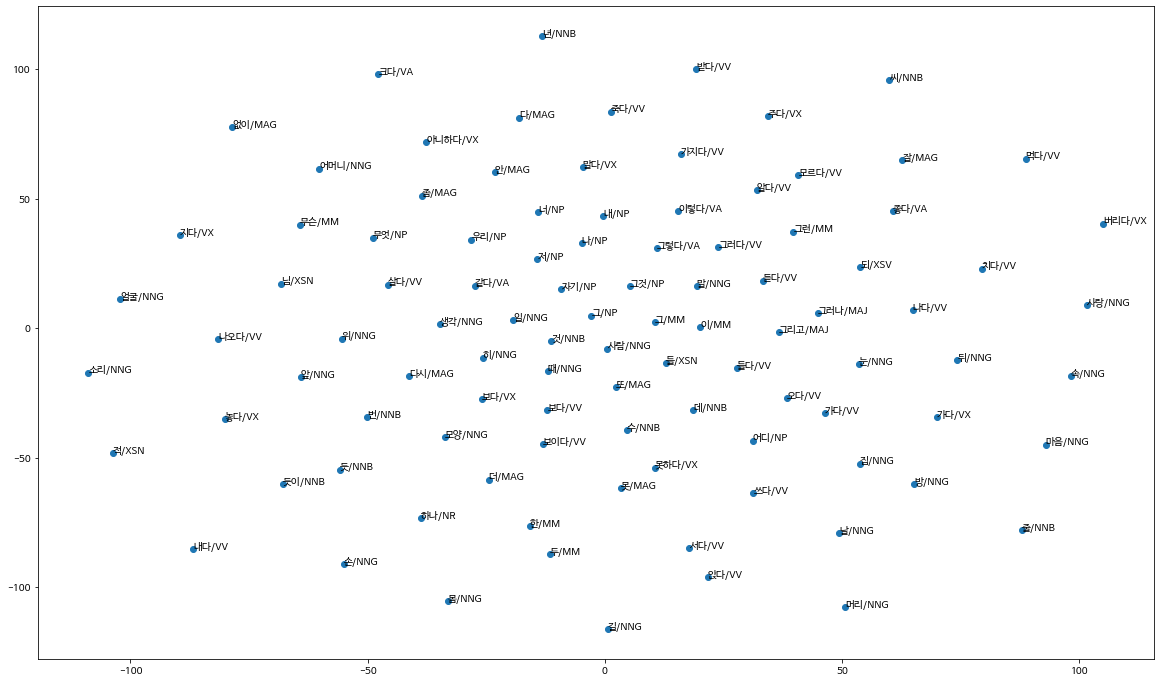

In [ ]:
fig = plt.figure()
fig.set_size_inches(20, 12)
ax = fig.add_subplot(1, 1, 1)

ax.scatter(w2v_100['x'], w2v_100['y'])

for word, pos in w2v_100.iterrows():
    ax.annotate(word, pos)
plt.show()

##### Word2vec 모델링 (전체 시기) window =2 vector_size =300 가장 적합해보임
vector_size=300, window =3, min_count=300

In [ ]:
# vector : 차원, window : 앞뒤 단어 보는 크기, min_count : 분석에 포함할 최소 단어 빈도수, sg : 0이면 cbow, 1이면 skip-gram
v300_w2_min300_sg = Word2Vec(sentences=df_sent['token'].to_list(), vector_size=300, window=2, min_count=300,sg=1,seed=2021, workers=1)
v300_w2_min300_sg.save('v300_w2_min300_sg.model') # 모델 저장. 모델 로드할때는 model= Word2Vec.load('v200_w3_min300_sg.model')

In [ ]:
# 해당 단어와 문맥이 비슷한 유사어 추출
v300_w2_min300_sg.wv.most_similar('우리/NP', topn=20)  # get other similar words

[('저희/NP', 0.579072892665863),
 ('여러분/NP', 0.4336128830909729),
 ('너희/NP', 0.41661351919174194),
 ('조상/NNG', 0.3684949576854706),
 ('독립/NNG', 0.36516663432121277),
 ('끼리/XSN', 0.36437416076660156),
 ('일반/NNG', 0.3497845530509949),
 ('저것/NP', 0.3486773669719696),
 ('아주머니/NNG', 0.3449436128139496),
 ('단군/NNP', 0.34397074580192566),
 ('동포/NNG', 0.34095677733421326),
 ('싸우다/VV', 0.3390015661716461),
 ('오늘날/NNG', 0.3384838104248047),
 ('언니/NNG', 0.3371066749095917),
 ('내/NP', 0.3302809000015259),
 ('나/NP', 0.3301750123500824),
 ('조선/NNP', 0.3300563097000122),
 ('망하다/VV', 0.32947278022766113),
 ('그러니까/MAJ', 0.32274726033210754),
 ('민족/NNG', 0.3226754069328308)]

In [ ]:
v300_w2_min300_sg.wv.most_similar('저희/NP', topn=20)  # get other similar words

[('너희/NP', 0.6317592859268188),
 ('우리/NP', 0.5790729522705078),
 ('끼리/XSN', 0.5373625159263611),
 ('모두/NNG', 0.4512093961238861),
 ('아이/NNG', 0.4410545825958252),
 ('가족/NNG', 0.4160912036895752),
 ('아주머니/NNG', 0.41560229659080505),
 ('식구/NNG', 0.41332268714904785),
 ('료/NNG', 0.4084796905517578),
 ('동무/NNG', 0.40844783186912537),
 ('괜찮다/VA', 0.40563011169433594),
 ('여러분/NP', 0.4010741412639618),
 ('저것/NP', 0.40023472905158997),
 ('저/NP', 0.3972735106945038),
 ('백성/NNG', 0.3716047406196594),
 ('친구/NNG', 0.36858028173446655),
 ('네/XSN', 0.367104172706604),
 ('동포/NNG', 0.36628803610801697),
 ('양반/NNG', 0.36469897627830505),
 ('이놈/NP', 0.36279091238975525)]

In [ ]:
v300_w2_min300_sg.wv.most_similar('내/NP', topn=20)  # get other similar words

[('네/NP', 0.6008553504943848),
 ('나/NP', 0.5222323536872864),
 ('제/NP', 0.5136606097221375),
 ('그래/IC', 0.4868468642234802),
 ('글쎄/IC', 0.46477702260017395),
 ('얘/IC', 0.4470868706703186),
 ('어데/NP', 0.446656733751297),
 ('그럼/MAJ', 0.43766480684280396),
 ('그렇지만/MAJ', 0.43299269676208496),
 ('그런데/MAJ', 0.4252453148365021),
 ('료/NNG', 0.42473357915878296),
 ('누/NP', 0.4135890305042267),
 ('아주머니/NNG', 0.4094516932964325),
 ('자네/NP', 0.40536653995513916),
 ('그만두다/VV', 0.40532881021499634),
 ('이거/NP', 0.40268442034721375),
 ('응/IC', 0.39730304479599),
 ('이년/NP', 0.39724135398864746),
 ('이놈/NP', 0.39594995975494385),
 ('음/IC', 0.39415672421455383)]

In [ ]:
# 해당 단어(2개 이상)와 문맥이 비슷한 유사어 추출
v300_w2_min300_sg.wv.most_similar(['우리/NP','저희/NP'], topn=20)  # get other similar words

[('너희/NP', 0.5899288654327393),
 ('끼리/XSN', 0.5074153542518616),
 ('여러분/NP', 0.46968597173690796),
 ('아주머니/NNG', 0.42796608805656433),
 ('저것/NP', 0.421419620513916),
 ('모두/NNG', 0.4158819615840912),
 ('식구/NNG', 0.4101232588291168),
 ('료/NNG', 0.40529367327690125),
 ('괜찮다/VA', 0.40323999524116516),
 ('가족/NNG', 0.40058642625808716),
 ('동포/NNG', 0.39797306060791016),
 ('일반/NNG', 0.3803613483905792),
 ('저/NP', 0.37959229946136475),
 ('조상/NNG', 0.37693318724632263),
 ('양반/NNG', 0.3749719560146332),
 ('이놈/NP', 0.3745230734348297),
 ('그러니까/MAJ', 0.3718510568141937),
 ('싸우다/VV', 0.3700070381164551),
 ('네/XSN', 0.36652982234954834),
 ('내/NP', 0.36448267102241516)]

In [ ]:
# 단어끼리 계산 해보기 
# 우리 + 나 - 너 ?
v300_w2_min300_sg.wv.most_similar(positive=['우리/NP','나/NP'],negative=['너/NP'],topn=20) 

[('저희/NP', 0.42989078164100647),
 ('여러분/NP', 0.35040923953056335),
 ('내/NP', 0.3125654458999634),
 ('도산/NNG', 0.31125277280807495),
 ('저/NP', 0.2925362288951874),
 ('마찬가지/NNG', 0.29202213883399963),
 ('끼리/XSN', 0.2916926145553589),
 ('영원히/MAG', 0.28564292192459106),
 ('그러므로/MAJ', 0.2850228548049927),
 ('조선/NNP', 0.2826302647590637),
 ('그/NP', 0.28207117319107056),
 ('단군/NNP', 0.27927905321121216),
 ('동시/NNG', 0.2785395085811615),
 ('그대/NP', 0.27699917554855347),
 ('불행/NNG', 0.2728155851364136),
 ('오늘날/NNG', 0.27185866236686707),
 ('동포/NNG', 0.26065483689308167),
 ('저것/NP', 0.25960370898246765),
 ('중국/NNP', 0.2594474256038666),
 ('독립/NNG', 0.2592827379703522)]

In [ ]:
# 입력한 단어 중 가장 관련성이 적은 것을 뺀다면?
v300_w2_min300_sg.wv.doesnt_match(['나/NP','너/NP','우리/NP','저희/NP'])


'너/NP'

In [ ]:
v300_w2_min300_sg.wv.doesnt_match(['나/NP','너희/NP','우리/NP','저희/NP'])

'나/NP'

In [ ]:
vocab =list(v300_w2_min300_sg.wv.key_to_index)
X = v300_w1_min300_sg.wv[vocab] 

In [ ]:
v300_w2_min300_sg.wv[vocab].shape

(1955, 300)

In [ ]:
tsne = TSNE(n_components=2) # 2차원으로 축소

In [ ]:
X_tsne = tsne.fit_transform(X[:100,:])
X_tsne

array([[-9.9065161e+00, -1.6601379e+01],
       [-6.7705464e-01,  1.7229918e+01],
       [ 8.3026800e+00,  4.9200997e-02],
       [-7.2665052e+00,  9.6979313e+00],
       [-9.0075197e+00, -3.3525196e+01],
       [ 5.1421318e+00,  2.0165222e+01],
       [-3.8670652e+00, -2.3697931e+01],
       [-1.4249757e+01,  6.7666698e+00],
       [-4.4941994e+01,  5.4870949e+01],
       [ 1.4953753e+01,  7.6286063e+00],
       [ 3.6001652e+01,  1.1704802e+01],
       [-1.7078491e+00, -1.4290584e+01],
       [ 3.4841068e+01,  1.8364477e+01],
       [-2.0013525e+01, -3.5017922e+00],
       [-1.1280105e+01, -9.0751228e+00],
       [-2.5652636e+01, -2.5496717e+01],
       [-2.6237692e+01, -3.6686134e+01],
       [ 1.7411369e+01, -1.6619848e+01],
       [-9.7802420e+00,  5.0101501e-01],
       [ 1.7281563e+01,  2.0378069e+01],
       [-4.1553993e+01, -6.0983543e+01],
       [-5.5533962e+01, -1.8461517e+01],
       [-1.8948757e+01,  6.3189777e+01],
       [-2.0769157e+01,  3.5181160e+01],
       [-2.05742

In [ ]:
# 차원축소 결과 확인
w2v_100 = pd.DataFrame(X_tsne, index=vocab[:100], columns=['x', 'y'])
w2v_100

,x,y
것/NNB,-9.906516,-16.601379
그/MM,-0.677055,17.229918
말/NNG,8.302680,0.049201
나/NP,-7.266505,9.697931
들/XSN,-9.007520,-33.525196
...,...,...
머리/NNG,-19.792688,78.073936
데/NNB,-14.581669,-24.551208
어디/NP,23.672779,43.642643
가지다/VV,5.979208,9.648976


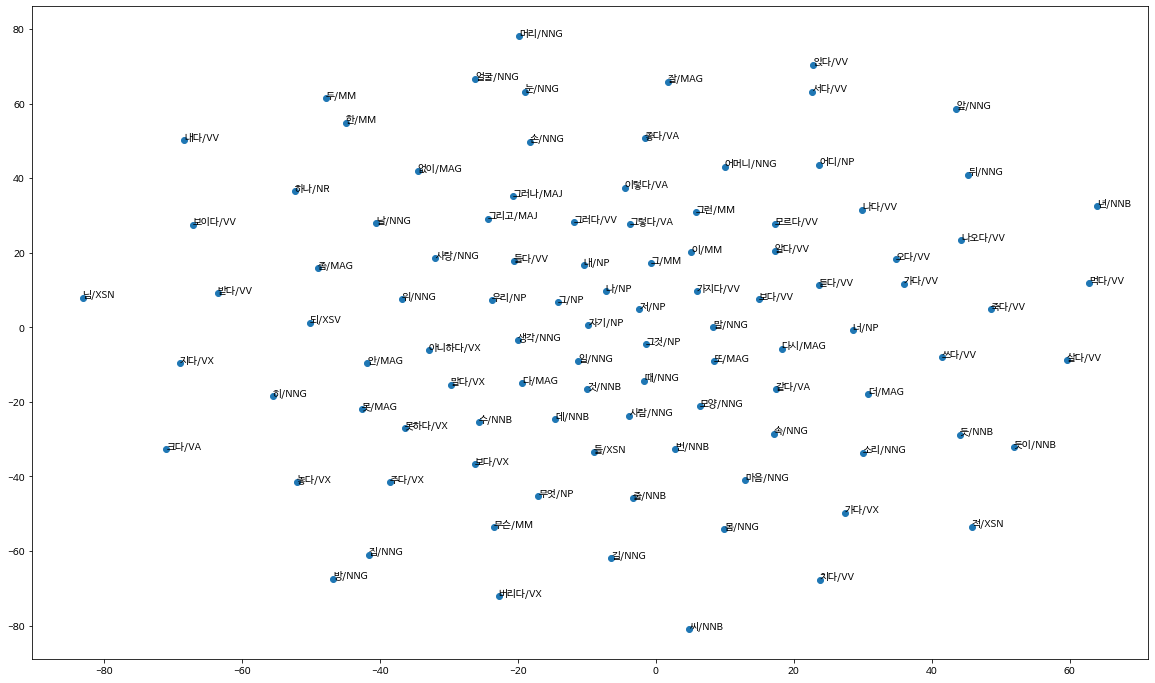

In [ ]:
fig = plt.figure()
fig.set_size_inches(20, 12)
ax = fig.add_subplot(1, 1, 1)

ax.scatter(w2v_100['x'], w2v_100['y'])

for word, pos in w2v_100.iterrows():
    ax.annotate(word, pos)
plt.show()

##### Word2vec 모델링 (전체 시기) window =1 vector_size=300
vector_size=200, window =3, min_count=300

In [ ]:
# vector : 차원, window : 앞뒤 단어 보는 크기, min_count : 분석에 포함할 최소 단어 빈도수, sg : 0이면 cbow, 1이면 skip-gram
v300_w1_min300_sg = Word2Vec(sentences=df_sent['token'].to_list(), vector_size=300, window=1, min_count=300,sg=1,seed=2021, workers=1)
v300_w1_min300_sg.save('v300_w1_min300_sg.model') # 모델 저장. 모델 로드할때는 model= Word2Vec.load('v200_w3_min300_sg.model')

In [ ]:
# 해당 단어와 문맥이 비슷한 유사어 추출
v300_w1_min300_sg.wv.most_similar('우리/NP', topn=20)  # get other similar words

[('저희/NP', 0.5862901210784912),
 ('여러분/NP', 0.4653380513191223),
 ('너희/NP', 0.44282230734825134),
 ('나/NP', 0.3957612216472626),
 ('단군/NNP', 0.3862002491950989),
 ('독립/NNG', 0.3791983425617218),
 ('끼리/XSN', 0.36961865425109863),
 ('아주머니/NNG', 0.3559460937976837),
 ('저것/NP', 0.3548414409160614),
 ('그대/NP', 0.35470911860466003),
 ('조상/NNG', 0.35212814807891846),
 ('싸우다/VV', 0.3481169044971466),
 ('인류/NNG', 0.3447352647781372),
 ('조선/NNP', 0.3406396508216858),
 ('민족/NNG', 0.33663830161094666),
 ('일반/NNG', 0.3361508548259735),
 ('언니/NNG', 0.3348276913166046),
 ('자네/NP', 0.33078765869140625),
 ('춘천/NNP', 0.3289383053779602),
 ('그러니까/MAJ', 0.3284701406955719)]

In [ ]:
v300_w1_min300_sg.wv.most_similar('저희/NP', topn=20)  # get other similar words

[('너희/NP', 0.6739223003387451),
 ('우리/NP', 0.5862901210784912),
 ('끼리/XSN', 0.5095829367637634),
 ('여러분/NP', 0.5026221871376038),
 ('식구/NNG', 0.48955827951431274),
 ('모두/NNG', 0.48279106616973877),
 ('저것/NP', 0.4634269177913666),
 ('젊은이/NNG', 0.46314138174057007),
 ('가족/NNG', 0.45762425661087036),
 ('아우/NNG', 0.4562476575374603),
 ('백성/NNG', 0.4551648795604706),
 ('늙은이/NNG', 0.4432550370693207),
 ('형제/NNG', 0.44208091497421265),
 ('여학생/NNG', 0.43768811225891113),
 ('하/IC', 0.433001309633255),
 ('아이/NNG', 0.43288737535476685),
 ('아주머니/NNG', 0.4258028268814087),
 ('동포/NNG', 0.4159674644470215),
 ('그놈/NP', 0.4094928205013275),
 ('저/NP', 0.40752851963043213)]

In [ ]:
v300_w1_min300_sg.wv.most_similar('내/NP', topn=20)  # get other similar words

[('네/NP', 0.6095435619354248),
 ('제/NP', 0.5593993663787842),
 ('나/NP', 0.5034614205360413),
 ('글쎄/IC', 0.4785769581794739),
 ('그런데/MAJ', 0.43676766753196716),
 ('어데/NP', 0.4331181049346924),
 ('그이/NP', 0.4330798089504242),
 ('그래/IC', 0.43268516659736633),
 ('얘/IC', 0.428661048412323),
 ('이년/NP', 0.40797072649002075),
 ('저/IC', 0.4075048565864563),
 ('료/NNG', 0.4063643217086792),
 ('그거/NP', 0.4028618633747101),
 ('그럼/MAJ', 0.4015202522277832),
 ('자네/NP', 0.40112563967704773),
 ('그만두다/VV', 0.3988775610923767),
 ('네/IC', 0.39511850476264954),
 ('아주머니/NNG', 0.39241233468055725),
 ('음/IC', 0.3872068226337433),
 ('대체/MAG', 0.3868929147720337)]

In [ ]:
# 해당 단어(2개 이상)와 문맥이 비슷한 유사어 추출
v300_w1_min300_sg.wv.most_similar(['우리/NP','저희/NP'], topn=20)  # get other similar words

[('너희/NP', 0.6269711852073669),
 ('여러분/NP', 0.543439507484436),
 ('끼리/XSN', 0.49360793828964233),
 ('저것/NP', 0.4593983292579651),
 ('식구/NNG', 0.45825615525245667),
 ('단군/NNP', 0.4441061317920685),
 ('아주머니/NNG', 0.4388953149318695),
 ('젊은이/NNG', 0.4370383024215698),
 ('모두/NNG', 0.42881160974502563),
 ('백성/NNG', 0.41659310460090637),
 ('동포/NNG', 0.41595545411109924),
 ('춘천/NNP', 0.4132068455219269),
 ('형제/NNG', 0.4117185175418854),
 ('가족/NNG', 0.4115156829357147),
 ('자네/NP', 0.40589234232902527),
 ('그대/NP', 0.40485286712646484),
 ('하/IC', 0.4032045006752014),
 ('나/NP', 0.40312305092811584),
 ('조상/NNG', 0.40024733543395996),
 ('농사/NNG', 0.39627864956855774)]

In [ ]:
# 단어끼리 계산 해보기 
# 우리 + 나 - 너 ?
v300_w1_min300_sg.wv.most_similar(positive=['우리/NP','나/NP'],negative=['너/NP'],topn=20) 

[('저희/NP', 0.41690555214881897),
 ('여러분/NP', 0.3897363245487213),
 ('불행/NNG', 0.330588161945343),
 ('단군/NNP', 0.3287937641143799),
 ('도산/NNG', 0.3188783824443817),
 ('그대/NP', 0.3169761300086975),
 ('내/NP', 0.3165077567100525),
 ('조선/NNP', 0.28770342469215393),
 ('정희/NNP', 0.28509148955345154),
 ('그렇지만/MAJ', 0.2836158573627472),
 ('조상/NNG', 0.28146985173225403),
 ('중국/NNP', 0.2806931734085083),
 ('저/NP', 0.27939972281455994),
 ('그/NP', 0.27857956290245056),
 ('독립/NNG', 0.2765830457210541),
 ('끼리/XSN', 0.2758983075618744),
 ('인류/NNG', 0.2754230201244354),
 ('저것/NP', 0.27237915992736816),
 ('덕호/NNP', 0.27202504873275757),
 ('언니/NNG', 0.2702077329158783)]

In [ ]:
# 입력한 단어 중 가장 관련성이 적은 것을 뺀다면?
v300_w1_min300_sg.wv.doesnt_match(['나/NP','너/NP','우리/NP','저희/NP'])


'너/NP'

In [ ]:
vocab =list(v300_w1_min300_sg.wv.key_to_index)
X = v300_w1_min300_sg.wv[vocab] 

In [ ]:
v300_w1_min300_sg.wv[vocab].shape

(1955, 300)

In [ ]:
tsne = TSNE(n_components=2) # 2차원으로 축소

In [ ]:
X_tsne = tsne.fit_transform(X[:100,:])
X_tsne

array([[ 1.87743320e+01,  2.02730012e+00],
       [-1.64058647e+01,  2.87536144e+01],
       [ 9.73709774e+00, -1.48534040e+01],
       [-2.34589024e+01, -1.66842461e+01],
       [-6.62969437e+01,  2.21467953e+01],
       [-1.84594440e+01,  4.09493523e+01],
       [ 2.55470600e+01, -1.51027575e+01],
       [-9.55082607e+00, -1.18657541e+01],
       [-1.99429321e+01,  8.43993683e+01],
       [-4.61601181e+01, -3.19040241e+01],
       [ 7.62872696e+00, -7.03883820e+01],
       [ 4.83395195e+01, -1.45433941e+01],
       [ 1.55168810e+01, -6.07930222e+01],
       [ 1.46300554e+01,  2.20384922e+01],
       [ 4.21219058e-02,  1.71437950e+01],
       [ 3.08946991e+01,  1.61874599e+01],
       [-6.19397087e+01, -1.97383347e+01],
       [ 3.75962186e+00,  4.02092323e+01],
       [-3.15801220e+01, -4.43236160e+01],
       [-2.08114013e-02, -4.54613724e+01],
       [-1.20955795e+02,  3.73086815e+01],
       [ 6.71514816e+01, -5.65358305e+00],
       [-8.53106308e+01, -4.79105301e+01],
       [-4.

In [ ]:
# 차원축소 결과 확인
w2v_100 = pd.DataFrame(X_tsne, index=vocab[:100], columns=['x', 'y'])
w2v_100

,x,y
것/NNB,18.774332,2.027300
그/MM,-16.405865,28.753614
말/NNG,9.737098,-14.853404
나/NP,-23.458902,-16.684246
들/XSN,-66.296944,22.146795
...,...,...
머리/NNG,145.991348,-10.545449
데/NNB,55.103466,-47.187943
어디/NP,-93.525970,17.647034
가지다/VV,-60.711937,-46.025639


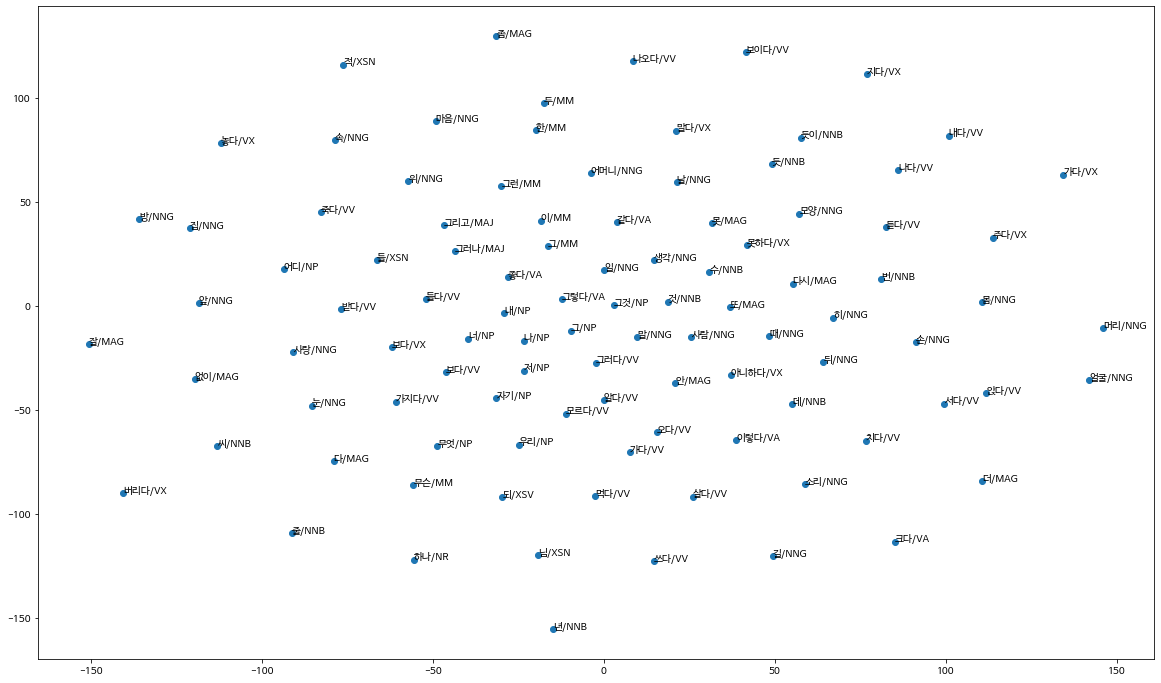

In [ ]:
fig = plt.figure()
fig.set_size_inches(20, 12)
ax = fig.add_subplot(1, 1, 1)

ax.scatter(w2v_100['x'], w2v_100['y'])

for word, pos in w2v_100.iterrows():
    ax.annotate(word, pos)
plt.show()

### 시대별 Word2vec

min_count를 조정

### E1 (~1919)

In [ ]:
df_e1 = df_sent[df_sent['period'] == 'E1']
df_e1

,title_wiki,title,sentence,period,token
1,꿈하늘,꿈하늘,"때는 단군 기원 4240년(서기 1907년) 몇 해 어느 달, 어느 날이던가, 땅은...",E1,"[때/NNG, 단군/NNP, 기원/NNG, 년/NNB, 서기/NNG, 년/NNB, ..."
2,꿈하늘,꿈하늘,별안간 하늘 한복판이 딱 갈라지며 그 속에서 불그레한 광선이 뻗쳐 나오더니 하늘에 ...,E1,"[별안간/NNG, 하늘/NNG, 한/XPN, 복판/NNG, 딱/MAG, 갈라지다/V..."
3,꿈하늘,꿈하늘,"""인간에게는 싸움뿐이니라. 싸움에 이기면 살고 지면 죽나니 신의 명령이 이러하니라.""",E1,"[인간/NNG, 싸움/NNG, 싸움/NNG, 이기다/VV, 살다/VV, 지다/VV,..."
4,꿈하늘,꿈하늘,"그 소리가 딱 그치며, 광선도 천관도 다 간 곳이 없고 햇살이 탁 퍼지며 온 바닥이...",E1,"[그/MM, 소리/NNG, 딱/MAG, 그치다/VV, 광선/NNG, 천관/NNG, ..."
5,꿈하늘,꿈하늘,동편으로 닷 동달이 갖춘 빛에 둥근 테를 두른 오원기(五員旗)가 뜨며 그 기 밑에 ...,E1,"[동편/NNG, 닷/NR, 동달이/NNP, 갖추다/VV, 빛/NNG, 둥글다/VA,..."
...,...,...,...,...,...
39,낙오자,낙오자,이에 이르러는 자기를 소아와 같이 보았나 하고 성을 내었었다.,E1,"[이/NP, 이르다/VV, 자기/NP, 소아/NNG, 같이/MAG, 보다/VV, 성..."
40,낙오자,낙오자,진화는 자기 희망대로 전장의 있는 것을 큰 다행으로 알지 아니할 수 없었다.,E1,"[진화/NNG, 자기/NP, 희망/NNG, 전장/NNG, 것/NNB, 크다/VA, ..."
41,낙오자,낙오자,또한 전원생활에 대한 취미도 약간 쓰여 있다.,E1,"[또한/MAG, 전원/NNG, 생활/NNG, 대하다/VV, 취미/NNG, 약간/MA..."
42,낙오자,낙오자,"그중에 진화가 가장 낯을 붉히도록 부끄럽게 감동한 것은 ""전원은 결코 낙오자의 수용...",E1,"[그/MM, 중/NNB, 진화/NNG, 가장/MAG, 낯/NNG, 붉히다/VV, 부..."


In [ ]:
df_e1_str = df_e1['token'].astype(str)

In [ ]:
df_e1_str[df_e1_str.str.contains('저희/NP')]

335     ['외숙모/NNG', '님/XSN', '저/NP', '귀여하셔/NNP', '머리/N...
816     ['이/MM', '나폴레옹/NNP', '숭배자/NNG', '형식/NNG', '인사/...
826     ['그러고/MAJ', '정작/NNG', '대표자/NNG', '상긋상/NNP', '긋...
838     ['저희/NP', '삼/NR', '사/NR', '년/NNB', '급/NNG', '합...
853     ['저/NP', '모교/NNG', '당국/NNG', '부패/NNG', '지극/XR'...
859     ['확실/XR', '저희/NP', '학생/NNG', '중/NNB', '몇/MM', ...
17      ['녜/IC', '교장/NNG', '어른/NNG', '뵈다/VV', '열/NR', ...
46      ['선생/NNG', '님/XSN', '오늘/MAG', '놀다/VV', '저희/NP'...
129     ['학생/NNG', '들/XSN', '학생/NNG', '들/XSN', '잘/MAG'...
210     ['나/NP', '정성/NNG', '껏/NNP', '넉넉/XR', '못하다/VX',...
241     ['이렇다/VA', '생각/NNG', '형식/NNG', '모든/MM', '인류/NN...
246     ['천장/NNG', '파리/NNG', '네/MM', '다섯/NR', '놈/NNB',...
166     ['원래/NNG', '최/NNP', '씨/NNB', '부인/NNG', '물/NNG'...
71      ['전지전능/NNG', '무소부지하시/NNG', '사랑/NNG', '많으/NNP',...
928     ['그러면/MAJ', '저희/NP', '내리다/VV', '잠깐/MAG', '기다리다...
87      ['저희/NP', '음악/NNG', '알다/VV', '다만/MAJ', '여러분/NP...
20      ['여보/IC', '무당/NNG', '판수/NNG', '것/NNB', '다/MAG'...
410     ['울다/V

In [ ]:
df_e1_str[df_e1_str.str.contains('우리/NP')]

5      ['동편/NNG', '닷/NR', '동달이/NNP', '갖추다/VV', '빛/NNG...
11     ['바람/NNG', '불다/VV', '물결/NNG', '치다/VV', '우리/NP'...
34     ['우리/NP', '정의/NNG', '아들/NNG', '악/NNG', '아무리/MA...
96     ['우리/NP', '어머니/NNG', '나/NP', '일/NNG', '알다/VV',...
109    ['우리/NP', '나가다/VV', '싶다/VX', '말/NNG', '임/NNG',...
                             ...                        
126    ['장/NNG', '이/NNP', '그렇다/VA', '터/NNB', '엇/NNP',...
128    ['장/NNG', '슈득/NNG', '아/IC', '조심/NNG', '단여오너/NN...
129    ['독/NNG', '네/IC', '그/MM', '걱졍/NNP', '다시/MAG', ...
143    ['장/NNG', '오야/NNP', '고만두다/VV', '말/NNG', '드러/NN...
144    ['장/NNG', '오냐/IC', '네/NP', '말/NNG', '알아듯겟/NNG'...
Name: token, Length: 673, dtype: object

전체 30만개의 문장 중에 3만개 정도의 문장이 포함됨으로 min_count를 10/1 수준으로 줄임




In [ ]:
e1_v300_w2_min30_sg = Word2Vec(sentences=df_sent.loc[df_sent['period'].isin(['E1']),'token'].to_list(), vector_size=300, window=2, min_count=30,sg=1,seed=2021, workers=1)
e1_v300_w2_min30_sg.save('e1_v300_w2_min30_sg.model') # 모델 저장. 모델 로드할때는 model= Word2Vec.load('e1_v300_w3_min30_sg.model')

In [ ]:
# 해당 단어와 문맥이 비슷한 유사어 추출
e1_v300_w2_min30_sg.wv.most_similar('우리/NP', topn=20)  # get other similar words

[('상감/NNG', 0.7639577984809875),
 ('옥중/NNG', 0.7512577176094055),
 ('계시다/VV', 0.7481532692909241),
 ('대감/NNG', 0.744958758354187),
 ('양반/NNG', 0.737220048904419),
 ('소인/NP', 0.7339040637016296),
 ('필경/MAG', 0.7314382791519165),
 ('낳다/VV', 0.730306088924408),
 ('망하다/VV', 0.7299023866653442),
 ('사돈/NNG', 0.726388692855835),
 ('자손/NNG', 0.724709689617157),
 ('뉘/NP', 0.7246523499488831),
 ('아기/NNG', 0.7179625034332275),
 ('계림/NNP', 0.7158564329147339),
 ('자네/NP', 0.7157875895500183),
 ('나으리/NNG', 0.7149031758308411),
 ('소위/MAG', 0.7095530033111572),
 ('원수/NNG', 0.7080058455467224),
 ('난리/NNG', 0.7070010304450989),
 ('타국/NNG', 0.7027441263198853)]

In [ ]:
e1_v300_w2_min30_sg.wv.most_similar('저희/NP', topn=20)  # get other similar words

[('일가/NNG', 0.9515736699104309),
 ('애쓰다/VV', 0.948239266872406),
 ('소위/MAG', 0.9447621703147888),
 ('전조/NNG', 0.9430791139602661),
 ('무사/NNG', 0.9405710101127625),
 ('벗/NNG', 0.940165638923645),
 ('풍속/NNG', 0.9398682117462158),
 ('흥/IC', 0.9376240968704224),
 ('부자/NNG', 0.9375198483467102),
 ('핑계/NNG', 0.9371861219406128),
 ('제일/NNG', 0.9357481002807617),
 ('죄인/NNG', 0.9351733326911926),
 ('김춘추/NNP', 0.9348556995391846),
 ('둘째/NR', 0.9341012239456177),
 ('끼리/XSN', 0.9330309629440308),
 ('가난/NNG', 0.9327977895736694),
 ('자라나다/VV', 0.9324881434440613),
 ('맡기다/VV', 0.9308056235313416),
 ('명령/NNG', 0.9301453232765198),
 ('최후/NNG', 0.9293224215507507)]

In [ ]:
e1_v300_w2_min30_sg.wv.most_similar('내/NP', topn=20)  # get other similar words

[('그래/IC', 0.8606786727905273),
 ('그러면/MAJ', 0.830888032913208),
 ('네/IC', 0.8306799530982971),
 ('저것/NP', 0.8179512023925781),
 ('설마/MAG', 0.8119970560073853),
 ('에그/IC', 0.8101382255554199),
 ('오냐/IC', 0.8096075654029846),
 ('언제/MAG', 0.8087281584739685),
 ('네/NP', 0.8082313537597656),
 ('잘못/NNG', 0.8034216165542603),
 ('진작/MAG', 0.7995823621749878),
 ('계집애/NNG', 0.7995585799217224),
 ('오늘/MAG', 0.7988408207893372),
 ('그리/MAG', 0.797591507434845),
 ('옳지/IC', 0.7959678769111633),
 ('참/IC', 0.7955318689346313),
 ('어떻게/MAG', 0.7955276966094971),
 ('저렇다/VA', 0.7944008111953735),
 ('글쎄/IC', 0.7939113974571228),
 ('그만두다/VV', 0.7938972115516663)]

In [ ]:
# 해당 단어(2개 이상)와 문맥이 비슷한 유사어 추출
e1_v300_w2_min30_sg.wv.most_similar(['우리/NP','저희/NP'], topn=20)  # get other similar words

[('옥중/NNG', 0.9053503274917603),
 ('소위/MAG', 0.9013151526451111),
 ('소인/NP', 0.8982651233673096),
 ('필경/MAG', 0.8972383737564087),
 ('일가/NNG', 0.8894795775413513),
 ('자손/NNG', 0.8877584934234619),
 ('계림/NNP', 0.8867588639259338),
 ('사돈/NNG', 0.8844895362854004),
 ('가난/NNG', 0.8835844397544861),
 ('대감/NNG', 0.8831604719161987),
 ('난리/NNG', 0.8827722072601318),
 ('애쓰다/VV', 0.878812849521637),
 ('나으리/NNG', 0.8784263730049133),
 ('양반/NNG', 0.877034068107605),
 ('타국/NNG', 0.875988245010376),
 ('아기/NNG', 0.8739774823188782),
 ('조상/NNG', 0.8726584911346436),
 ('상전/NNG', 0.8726502060890198),
 ('둘째/NR', 0.8702719211578369),
 ('저것/NP', 0.8693678975105286)]

In [ ]:
# 단어끼리 계산 해보기 
# 우리 + 나 - 너 ?
e1_v300_w2_min30_sg.wv.most_similar(positive=['우리/NP','나/NP'],negative=['너/NP'],topn=20) 

[('옥중/NNG', 0.7057296633720398),
 ('하느님/NNG', 0.6936860680580139),
 ('더구나/MAG', 0.6911899447441101),
 ('대감/NNG', 0.6865825653076172),
 ('돌아가다/VV', 0.6835671663284302),
 ('상감/NNG', 0.6766843795776367),
 ('저/NP', 0.672285795211792),
 ('버리다/VV', 0.6722404360771179),
 ('귀하다/VA', 0.6719259023666382),
 ('낳다/VV', 0.6714798808097839),
 ('형제/NNG', 0.6708279848098755),
 ('늘/MAG', 0.6695133447647095),
 ('찾아오다/VV', 0.6665279269218445),
 ('누이/NNG', 0.6664194464683533),
 ('경희/NNP', 0.6638035178184509),
 ('평양/NNP', 0.66047602891922),
 ('조상/NNG', 0.660071611404419),
 ('계림/NNP', 0.6593040227890015),
 ('끼리/XSN', 0.6517353653907776),
 ('자손/NNG', 0.6513462662696838)]

In [ ]:
# 입력한 단어 중 가장 관련성이 적은 것을 뺀다면?
e1_v300_w2_min30_sg.wv.doesnt_match(['나/NP','너/NP','우리/NP','저희/NP'])

'우리/NP'

In [ ]:
# 입력한 단어 중 가장 관련성이 적은 것을 뺀다면?
e1_v300_w2_min30_sg.wv.doesnt_match(['나/NP','너희/NP','우리/NP','저희/NP'])

'나/NP'

In [ ]:
vocab =list(e1_v300_w2_min30_sg.wv.key_to_index)
X = e1_v300_w3_min30_sg.wv[vocab] 

In [ ]:

e1_v300_w3_min30_sg.wv[vocab].shape

(2168, 300)

In [ ]:
tsne = TSNE(n_components=2) # 2차원으로 축소

In [ ]:
X_tsne = tsne.fit_transform(X[:100,:])
X_tsne

array([[ -9.95053   ,   0.22147627],
       [  3.5730495 ,  -4.2215    ],
       [ 10.362232  , -23.67598   ],
       [ -1.5740365 , -36.911892  ],
       [-14.861911  ,   0.9692909 ],
       [ 17.539762  ,  14.321295  ],
       [ -9.568927  ,  19.236567  ],
       [  8.394822  ,  16.621717  ],
       [ -4.217531  ,  37.30901   ],
       [  4.1509733 , -10.73031   ],
       [ 36.13773   , -27.958115  ],
       [ -4.6725817 ,  15.649603  ],
       [ 49.982     , -17.52597   ],
       [-20.911293  , -22.781101  ],
       [ -0.33063456, -16.21494   ],
       [-43.792595  ,  -1.8484777 ],
       [-20.534742  , -10.407924  ],
       [-20.742071  , -32.985897  ],
       [ -6.1416483 , -20.25343   ],
       [ 25.51091   ,  -1.1393322 ],
       [ 10.948849  ,  -7.9496984 ],
       [-17.93254   , -16.714989  ],
       [ 12.297443  , -30.704016  ],
       [-42.601933  , -28.307539  ],
       [  5.9574594 ,   1.7286943 ],
       [  3.2954822 , -21.424816  ],
       [ -2.4266036 , -49.839333  ],
 

In [ ]:
# 차원축소 결과 확인
w2v_100 = pd.DataFrame(X_tsne, index=vocab[:100], columns=['x', 'y'])
w2v_100

,x,y
그/MM,-9.950530,0.221476
것/NNB,3.573050,-4.221500
말/NNG,10.362232,-23.675980
보다/VV,-1.574036,-36.911892
이/MM,-14.861911,0.969291
...,...,...
보이다/VV,3.055032,-39.768234
영채/NNG,-16.628551,-29.791924
곳/NNG,36.310246,10.588632
놈/NNB,40.026711,24.349855


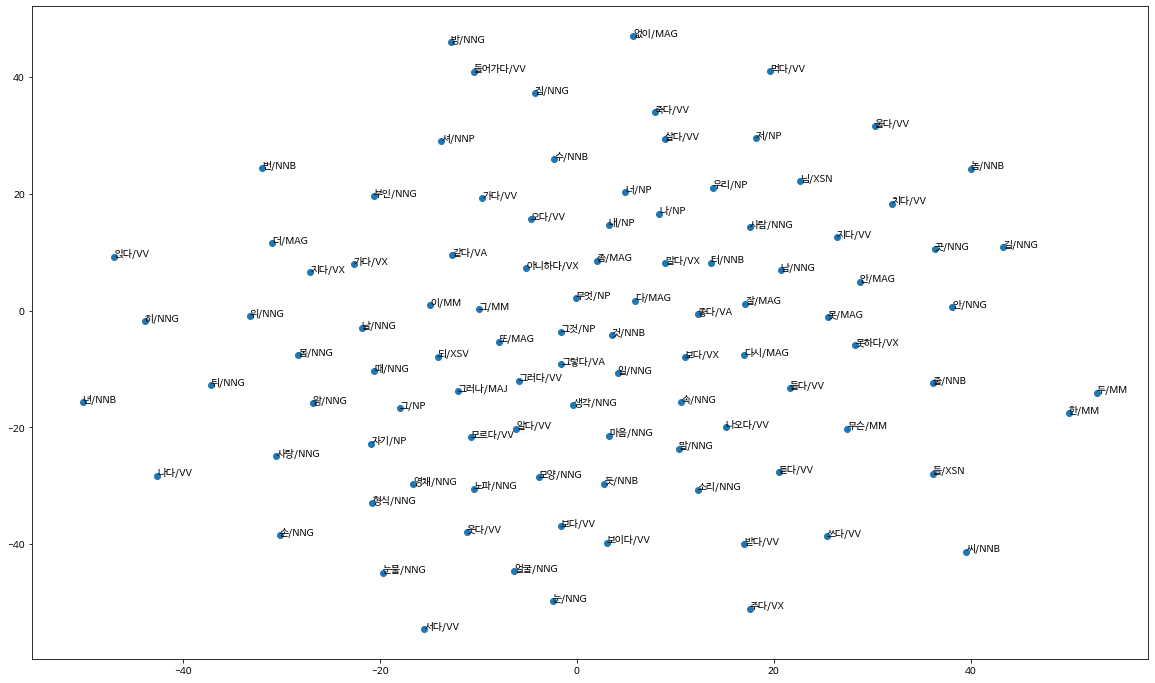

In [ ]:
fig = plt.figure()
fig.set_size_inches(20, 12)
ax = fig.add_subplot(1, 1, 1)

ax.scatter(w2v_100['x'], w2v_100['y'])

for word, pos in w2v_100.iterrows():
    ax.annotate(word, pos)
plt.show()

### E2 (1919~1945)

In [ ]:
df_e2 = df_sent[df_sent['period'] == 'E2']
df_e2

,title_wiki,title,sentence,period,token
1,날개,날개,‘박제가 되어 버린 천재’를 아시오?,E2,"[박제/NNG, 버리다/VX, 천재/NNG, 알다/VV]"
3,날개,날개,이런 때 연애까지가 유쾌하오.,E2,"[이런/MM, 때/NNG, 연애/NNG, 유쾌/XR]"
4,날개,날개,육신이 흐느적흐느적하도록 피로했을 때만 정신이 은화처럼 맑소. 니코틴이 내 횟배 앓...,E2,"[육신/NNG, 흐느적흐느적/NNG, 피로/NNG, 때/NNG, 정신/NNG, 은화..."
5,날개,날개,그 위에다 나는 위트와 패러독스를 바둑 포석처럼 늘어놓소. 가증할 상식의 병이오.,E2,"[그/MM, 위/NNG, 나/NP, 위트/NNG, 패러독스/NNG, 바둑/NNG, ..."
6,날개,날개,나는 또 여인과 생활을 설계하오.,E2,"[나/NP, 또/MAG, 여인/NNG, 생활/NNG, 설계/NNG]"
...,...,...,...,...,...
33,가지말게,가지말게,순삼이의 어린 딸과 갑동이의 자식들이 소쿠리에 담긴 감자들같이 한데 오로록 모여 앉...,E2,"[순삼이/NNP, 어리다/VA, 딸/NNG, 갑동이/NNP, 자식/NNG, 들/XS..."
34,가지말게,가지말게,“아이고 이 사람아 그만 가지 말게 저 어린 것들도 무엇을 알고 울겠나.”,E2,"[아이고/IC, 이/MM, 사람/NNG, 그만/MAG, 가다/VV, 말다/VX, 저..."
35,가지말게,가지말게,하는 소리가 나자 남 먼저 갑동이와 순삼의 얼굴이 벙싯 웃는 듯 경련을 짓더니,E2,"[소리/NNG, 나다/VV, 남/NNG, 먼저/MAG, 갑동이/NNP, 순삼/NNP..."
37,가지말게,가지말게,하고 소리를 내자 온 방 안은 ‘왕 -’ 울음 소리에 차고 말았다.,E2,"[소리/NNG, 내다/VV, 온/MM, 방/NNG, 안/NNG, 왕/NNG, 울음/..."


전체 30만개의 문장중 24만개정도의 문장이 포함됨으로 min_count를 200으로 조정

In [ ]:
e2_v300_w2_min200_sg = Word2Vec(sentences=df_sent.loc[df_sent['period'].isin(['E2']),'token'].to_list(), vector_size=300, window=2, min_count=200,sg=1,seed=2021, workers=1)
e2_v300_w2_min200_sg.save('e2_v300_w2_min200_sg.model') # 모델 저장. 모델 로드할때는 model= Word2Vec.load('e2_v200_w3_min200_sg.model')

In [ ]:
# 해당 단어와 문맥이 비슷한 유사어 추출
e2_v300_w2_min200_sg.wv.most_similar('우리/NP', topn=20)  # get other similar words

[('저희/NP', 0.5674713253974915),
 ('여러분/NP', 0.501641035079956),
 ('너희/NP', 0.47491493821144104),
 ('그네/NP', 0.4441903233528137),
 ('그럼/IC', 0.42347943782806396),
 ('그리구/MAJ', 0.4046231806278229),
 ('농민/NNG', 0.3900059163570404),
 ('아주머니/NNG', 0.38759464025497437),
 ('얘/NP', 0.3827298581600189),
 ('가난/NNG', 0.37321457266807556),
 ('자네/NP', 0.37245652079582214),
 ('농사/NNG', 0.3716728687286377),
 ('오늘날/NNG', 0.3709951341152191),
 ('저것/NP', 0.37022992968559265),
 ('끼리/XSN', 0.3654659390449524),
 ('그럼/MAJ', 0.3606356978416443),
 ('그대/NP', 0.36041709780693054),
 ('조선/NNP', 0.36004072427749634),
 ('네/XSN', 0.35549861192703247),
 ('언니/NNG', 0.3541933000087738)]

In [ ]:
e2_v300_w2_min200_sg.wv.most_similar('저희/NP', topn=20)  # get other similar words

[('끼리/XSN', 0.6553356051445007),
 ('너희/NP', 0.6457823514938354),
 ('우리/NP', 0.5674712657928467),
 ('그럼/IC', 0.535311758518219),
 ('늙은이/NNG', 0.525253415107727),
 ('가족/NNG', 0.5236238837242126),
 ('모두/NNG', 0.5150550603866577),
 ('그네/NP', 0.5102753639221191),
 ('아주머니/NNG', 0.4926917850971222),
 ('식구/NNG', 0.48676028847694397),
 ('꾼/XSN', 0.4782308042049408),
 ('밤낮/NNG', 0.46699634194374084),
 ('여편네/NNG', 0.4663560390472412),
 ('여학생/NNG', 0.4645962715148926),
 ('아이/NNG', 0.4631254971027374),
 ('이놈/NP', 0.46077361702919006),
 ('더러/MAG', 0.45986488461494446),
 ('친하다/VA', 0.45863771438598633),
 ('농사/NNG', 0.45861008763313293),
 ('떠들다/VV', 0.45856374502182007)]

In [ ]:
e2_v300_w2_min200_sg.wv.most_similar('내/NP', topn=20)  # get other similar words

[('네/NP', 0.5745507478713989),
 ('제/NP', 0.5732085704803467),
 ('나/NP', 0.5618786215782166),
 ('얘/NP', 0.5265260934829712),
 ('글쎄/IC', 0.5146273970603943),
 ('그래/IC', 0.48955458402633667),
 ('설마/MAG', 0.48877206444740295),
 ('얘/IC', 0.4887155294418335),
 ('오/IC', 0.4859844148159027),
 ('그럼/IC', 0.4713105857372284),
 ('그럼/MAJ', 0.4705463647842407),
 ('료/NNG', 0.4650188684463501),
 ('여보/IC', 0.46308910846710205),
 ('어데/NP', 0.4578858017921448),
 ('이년/NP', 0.44906094670295715),
 ('그렇지만/MAJ', 0.4448927640914917),
 ('그리구/MAJ', 0.44032201170921326),
 ('저/IC', 0.4391496181488037),
 ('이놈/NP', 0.4382052719593048),
 ('자네/NP', 0.43731898069381714)]

In [ ]:
# 해당 단어(2개 이상)와 문맥이 비슷한 유사어 추출
e2_v300_w2_min200_sg.wv.most_similar(['우리/NP','저희/NP'], topn=20)  # get other similar words

[('너희/NP', 0.6329559683799744),
 ('끼리/XSN', 0.5765361785888672),
 ('그럼/IC', 0.5415133833885193),
 ('그네/NP', 0.5390704274177551),
 ('여러분/NP', 0.5301839113235474),
 ('아주머니/NNG', 0.4971749186515808),
 ('가족/NNG', 0.4877292215824127),
 ('농사/NNG', 0.4689335823059082),
 ('모두/NNG', 0.4645230174064636),
 ('저것/NP', 0.46086645126342773),
 ('형제/NNG', 0.45719191431999207),
 ('늙은이/NNG', 0.45417526364326477),
 ('농민/NNG', 0.4540638029575348),
 ('가난/NNG', 0.45218849182128906),
 ('그리구/MAJ', 0.4473986029624939),
 ('친하다/VA', 0.4445997178554535),
 ('얘/NP', 0.44222763180732727),
 ('굶다/VV', 0.43738439679145813),
 ('료/NNG', 0.43465882539749146),
 ('식구/NNG', 0.43413710594177246)]

In [ ]:
# 단어끼리 계산 해보기 
# 우리 + 나 - 너 ?
e2_v300_w2_min200_sg.wv.most_similar(positive=['우리/NP','나/NP'],negative=['너/NP'],topn=20) 

[('여러분/NP', 0.40314698219299316),
 ('저희/NP', 0.3754304349422455),
 ('그네/NP', 0.3593987226486206),
 ('그대/NP', 0.3536529839038849),
 ('네/XSN', 0.3311016261577606),
 ('내/NP', 0.3137149214744568),
 ('그/NP', 0.30752187967300415),
 ('조선/NNP', 0.3059660494327545),
 ('가족/NNG', 0.3050413131713867),
 ('정희/NNP', 0.2990672290325165),
 ('그럼/IC', 0.29877740144729614),
 ('저것/NP', 0.2979697287082672),
 ('이곳/NP', 0.295141339302063),
 ('그저/MAG', 0.29414305090904236),
 ('그럼/MAJ', 0.2841988205909729),
 ('인간/NNG', 0.28415730595588684),
 ('오늘날/NNG', 0.28293097019195557),
 ('너희/NP', 0.281451553106308),
 ('사회/NNG', 0.2808220088481903),
 ('형편/NNG', 0.27980315685272217)]

In [ ]:
# 입력한 단어 중 가장 관련성이 적은 것을 뺀다면?
e2_v300_w2_min200_sg.wv.doesnt_match(['나/NP','너/NP','우리/NP','저희/NP'])

'너/NP'

In [ ]:
# 입력한 단어 중 가장 관련성이 적은 것을 뺀다면?
e2_v300_w2_min200_sg.wv.doesnt_match(['나/NP','너희/NP','우리/NP','저희/NP'])

'나/NP'

In [ ]:
vocab =list(e2_v300_w2_min200_sg.wv.key_to_index)
X = e2_v300_w2_min200_sg.wv[vocab] 

In [ ]:
e2_v300_w2_min200_sg.wv[vocab].shape

(2138, 300)

In [ ]:
tsne = TSNE(n_components=2) # 2차원으로 축소

In [ ]:
X_tsne = tsne.fit_transform(X[:100,:])
X_tsne

array([[ -5.9189763 ,   2.0281866 ],
       [ 18.262611  ,  -9.148302  ],
       [-22.435703  ,  16.499592  ],
       [ 12.439139  ,  -1.2188882 ],
       [ 13.292484  , -19.982244  ],
       [  7.632314  ,  -8.211717  ],
       [ 24.013166  , -15.852464  ],
       [  1.7189275 , -15.291573  ],
       [-16.102581  , -55.009808  ],
       [-25.422688  ,   5.2865844 ],
       [ 39.947052  ,   5.2157393 ],
       [ -2.3716486 ,  -5.8970356 ],
       [-23.256317  ,  -8.971445  ],
       [ 47.511383  ,   3.7641993 ],
       [-13.067545  ,   8.993542  ],
       [ -3.3501406 ,  13.2040205 ],
       [-12.174423  ,  23.930775  ],
       [ 35.983425  , -11.052234  ],
       [-36.68291   ,  -0.73721117],
       [  4.2619333 , -27.790293  ],
       [-49.99765   , -26.816069  ],
       [ -4.467545  , -41.51909   ],
       [ 28.178034  ,  -2.354227  ],
       [-27.667734  ,  28.532774  ],
       [  1.3675706 ,  32.854362  ],
       [-48.30889   ,  28.143791  ],
       [ 11.659935  ,  12.272531  ],
 

In [ ]:
# 차원축소 결과 확인
w2v_100 = pd.DataFrame(X_tsne, index=vocab[:100], columns=['x', 'y'])
w2v_100

,x,y
것/NNB,-5.918976,2.028187
그/MM,18.262611,-9.148302
말/NNG,-22.435703,16.499592
나/NP,12.439139,-1.218888
들/XSN,13.292484,-19.982244
...,...,...
어디/NP,47.242870,18.089081
크다/VA,-85.664864,13.407504
돈/NNG,93.986435,35.166740
싶다/VX,19.344397,57.242569


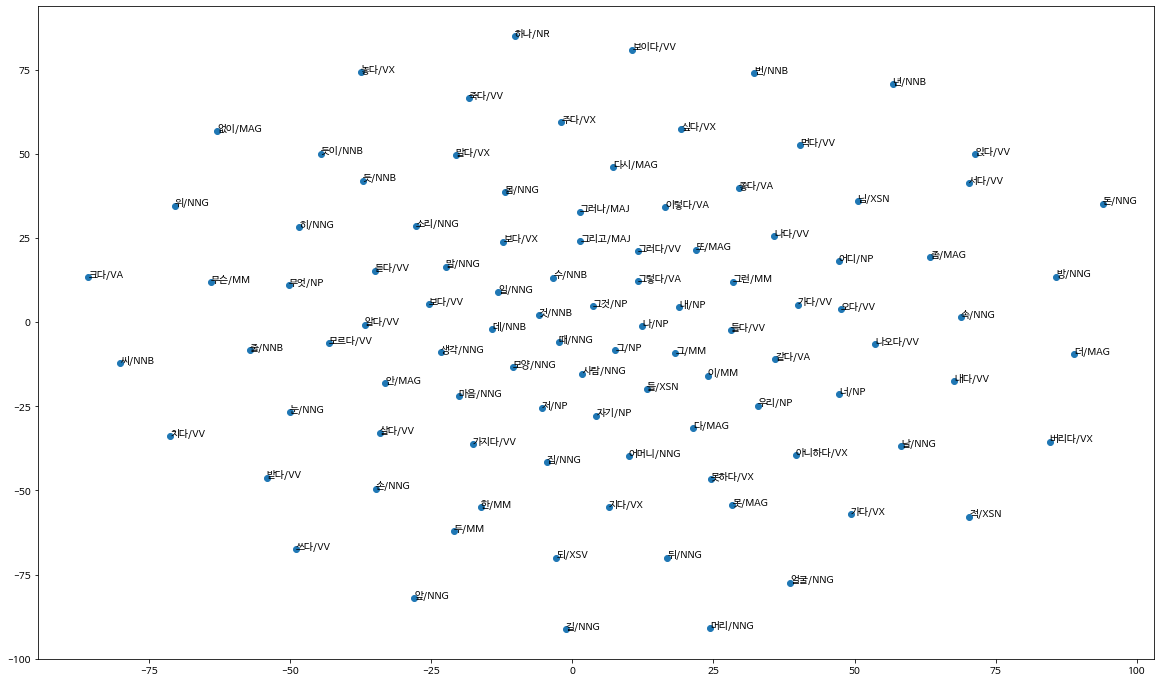

In [ ]:
fig = plt.figure()
fig.set_size_inches(20, 12)
ax = fig.add_subplot(1, 1, 1)

ax.scatter(w2v_100['x'], w2v_100['y'])

for word, pos in w2v_100.iterrows():
    ax.annotate(word, pos)
plt.show()

### E3 (1945 ~)

In [ ]:
df_e3 = df_sent[df_sent['period'] == 'E3']
df_e3

,title_wiki,title,sentence,period,token
0,백범일지,백범일지,백범일지 저자의 말. 하여서 딱 거절하였다.,E3,"[백범/NNP, 일지/NNG, 저자/NNG, 말/NNG, 딱/MAG, 거절/NNG]"
1,백범일지,백범일지,"그런즉 일인이 다시 말하기를,",E3,"[그런/MM, 즉/MAG, 일인/NNG, 다시/MAG, 말/NNG]"
2,백범일지,백범일지,"""형법이 곧 대군주 폐하의 명령이 아니오? 그런즉 김창수를 수갑을 채우고 포승으로 ...",E3,"[형법/NNG, 곧/MAG, 대군주/NNP, 폐하/NNG, 명령/NNG, 그런/MM..."
3,백범일지,백범일지,하고 기어이 나를 결박하여놓고 사진박기를 주장하였다.,E3,"[기어이/MAG, 나/NP, 결박/NNG, 놓다/VX, 사진/NNG, 박다/VV, ..."
5,백범일지,백범일지,"""갑오경장 이후에 우리나라에서는 형구는 폐하였소.""",E3,"[""갑오/NNP, 경장/NNG, 이후/NNG, 우리나라/NNG, 형구/NNP, 폐하..."
...,...,...,...,...,...
0,국민의 기대에 십분보답 못해 유감,國民의期待에 十分報答못해遺憾\n 鄭寅普氏退任辭,국민의 기대에 십분보답 못해 유감,E3,"[국민/NNG, 기대/NNG, 십/NR, 분/NNB, 보답/NNG, 못/MAG, 유..."
1,국민의 기대에 십분보답 못해 유감,國民의期待에 十分報答못해遺憾\n 鄭寅普氏退任辭,금번 퇴임한 정인보씨는 다음과 같은 퇴임소감담을 발표하였다.,E3,"[금/NNG, 번/NNB, 퇴임/NNG, 정인보/NNP, 씨/NNB, 다음/NNG,..."
2,국민의 기대에 십분보답 못해 유감,國民의期待에 十分報答못해遺憾\n 鄭寅普氏退任辭,나는 벌써 물러갈 것이었으나 구구한 공직의 일념으로 조금이라도 나라에 바쳐볼까 하여...,E3,"[나/NP, 벌써/MAG, 물러가다/VV, 것/NNB, 구구/XR, 공직/NNG, ..."
3,국민의 기대에 십분보답 못해 유감,國民의期待에 十分報答못해遺憾\n 鄭寅普氏退任辭,재직중 대통령께 이 뇌(惱)한 바 많음이 황송하며 총리이하정부제료(總理以下政府諸僚)...,E3,"[재직/NNG, 중/NNB, 대통령/NNG, 이/MM, 뇌/NNG, 바/NNB, 많..."


In [ ]:
e3_v300_w2_min50_sg = Word2Vec(sentences=df_sent.loc[df_sent['period'].isin(['E3']),'token'].to_list(), vector_size=300, window=2, min_count=75,sg=1,seed=2021, workers=1)
e3_v300_w2_min50_sg.save('e3_v300_w2_min50_sg.model') # 모델 저장. 모델 로드할때는 model= Word2Vec.load('v200_w3_min300_sg.model')

In [ ]:
# 해당 단어와 문맥이 비슷한 유사어 추출
e3_v300_w2_min50_sg.wv.most_similar('우리/NP', topn=20)  # get other similar words

[('망하다/VV', 0.748196005821228),
 ('너희/NP', 0.7005659341812134),
 ('한인/NNG', 0.6951745748519897),
 ('저희/NP', 0.6868880987167358),
 ('조선/NNP', 0.6793708205223083),
 ('흥사단/NNP', 0.6743388175964355),
 ('둘째/NR', 0.6732187867164612),
 ('덕/NNG', 0.6665250658988953),
 ('적/NNG', 0.6649906039237976),
 ('백성/NNG', 0.6447850465774536),
 ('그/NP', 0.6421396136283875),
 ('동포/NNG', 0.6413460373878479),
 ('그러므로/MAJ', 0.6387283205986023),
 ('새/MM', 0.6380558609962463),
 ('수양/NNG', 0.6368139386177063),
 ('독립/NNG', 0.6356257796287537),
 ('시대/NNG', 0.6355662941932678),
 ('반드시/MAG', 0.6350938081741333),
 ('대/XPN', 0.6328161954879761),
 ('한국/NNP', 0.6319857239723206)]

In [ ]:
e3_v300_w2_min50_sg.wv.most_similar('저희/NP', topn=20)  # get other similar words

[('너희/NP', 0.9086323976516724),
 ('아이/NNG', 0.8158809542655945),
 ('가족/NNG', 0.8022651672363281),
 ('양반/NNG', 0.7962482571601868),
 ('백성/NNG', 0.7797684669494629),
 ('친구/NNG', 0.7745015621185303),
 ('한인/NNG', 0.7621479630470276),
 ('부모/NNG', 0.7582353353500366),
 ('늙다/VV', 0.7545323967933655),
 ('공부/NNG', 0.7539896965026855),
 ('그/NP', 0.7531291246414185),
 ('태수/NNP', 0.7515949606895447),
 ('망하다/VV', 0.7439431548118591),
 ('사내/NNG', 0.7432814240455627),
 ('젊은이/NNG', 0.7409795522689819),
 ('임금/NNG', 0.7405827045440674),
 ('둘째/NR', 0.739830732345581),
 ('동지/NNG', 0.738836407661438),
 ('자식/NNG', 0.7383085489273071),
 ('평생/NNG', 0.7373230457305908)]

In [ ]:
e3_v300_w2_min50_sg.wv.most_similar('내/NP', topn=20)  # get other similar words

[('음/IC', 0.7854349613189697),
 ('네/NP', 0.7805851697921753),
 ('그러니까/MAJ', 0.7778446078300476),
 ('자네/NP', 0.766460657119751),
 ('글쎄/IC', 0.7614684700965881),
 ('무어/NP', 0.7460689544677734),
 ('아마/MAG', 0.7424687743186951),
 ('흥/IC', 0.7412492036819458),
 ('오오/IC', 0.7397767901420593),
 ('어젯밤/NNG', 0.7381294965744019),
 ('아이구/IC', 0.7376965880393982),
 ('대체/MAG', 0.7370205521583557),
 ('언니/NNG', 0.7369582056999207),
 ('뭐/IC', 0.7349539995193481),
 ('누/NP', 0.7324915528297424),
 ('어쨌든/MAG', 0.7318994402885437),
 ('거/NP', 0.7237964272499084),
 ('당신/NP', 0.7222734689712524),
 ('엄마/NNG', 0.720111608505249),
 ('참/MAG', 0.7163160443305969)]

In [ ]:
# 해당 단어(2개 이상)와 문맥이 비슷한 유사어 추출
e3_v300_w2_min50_sg.wv.most_similar(['우리/NP','저희/NP'], topn=20)  # get other similar words

[('너희/NP', 0.8760955333709717),
 ('망하다/VV', 0.8123649954795837),
 ('한인/NNG', 0.7934097647666931),
 ('백성/NNG', 0.7755693197250366),
 ('둘째/NR', 0.7693061828613281),
 ('가족/NNG', 0.7644697427749634),
 ('그/NP', 0.7596258521080017),
 ('덕/NNG', 0.7521149516105652),
 ('동포/NNG', 0.744929313659668),
 ('양반/NNG', 0.7412680983543396),
 ('새/MM', 0.7399418354034424),
 ('천하/NNG', 0.7341637015342712),
 ('공부/NNG', 0.7327162623405457),
 ('다르다/VA', 0.7273634076118469),
 ('그러므로/MAJ', 0.725855827331543),
 ('시대/NNG', 0.7230439782142639),
 ('흥사단/NNP', 0.7204433083534241),
 ('적/NNG', 0.7197723388671875),
 ('단군/NNP', 0.719068706035614),
 ('직업/NNG', 0.718895435333252)]

In [ ]:
# 단어끼리 계산 해보기 
# 우리 + 나 - 너 ?
e3_v300_w2_min50_sg.wv.most_similar(positive=['우리/NP','나/NP'],negative=['너/NP'],topn=20) 

[('마찬가지/NNG', 0.5858156085014343),
 ('동포/NNG', 0.5622515082359314),
 ('저희/NP', 0.5577340126037598),
 ('남성/NNG', 0.5462889671325684),
 ('현재/NNG', 0.5358061790466309),
 ('한인/NNG', 0.5284934639930725),
 ('사회/NNG', 0.5218604207038879),
 ('그러므로/MAJ', 0.5204879641532898),
 ('저/NP', 0.5143313407897949),
 ('진실/NNG', 0.5113310217857361),
 ('인류/NNG', 0.5104950070381165),
 ('시키/XSV', 0.5085955262184143),
 ('부족/NNG', 0.5063136219978333),
 ('여성/NNG', 0.5023782253265381),
 ('주장/NNG', 0.4977491497993469),
 ('단결/NNG', 0.49651721119880676),
 ('개인/NNG', 0.4964854419231415),
 ('서로/MAG', 0.496408611536026),
 ('문학/NNG', 0.49515044689178467),
 ('사업/NNG', 0.4941255450248718)]

In [ ]:
# 입력한 단어 중 가장 관련성이 적은 것을 뺀다면?
e3_v300_w2_min50_sg.wv.doesnt_match(['나/NP','너/NP','우리/NP','저희/NP'])

'너/NP'

In [ ]:
# 입력한 단어 중 가장 관련성이 적은 것을 뺀다면?
e3_v300_w2_min50_sg.wv.doesnt_match(['나/NP','너희/NP','우리/NP','저희/NP'])

'나/NP'

In [ ]:
vocab =list(e3_v300_w3_min50_sg.wv.key_to_index)
X = e3_v300_w3_min50_sg.wv[vocab] 

In [ ]:
# X?
e3_v300_w3_min50_sg.wv[vocab].shape

In [ ]:
tsne = TSNE(n_components=2) # 2차원으로 축소

In [ ]:
X_tsne = tsne.fit_transform(X[:100,:])
X_tsne

In [ ]:
# 차원축소 결과 확인
w2v_100 = pd.DataFrame(X_tsne, index=vocab[:100], columns=['x', 'y'])
w2v_100

In [ ]:
fig = plt.figure()
fig.set_size_inches(20, 12)
ax = fig.add_subplot(1, 1, 1)

ax.scatter(w2v_100['x'], w2v_100['y'])

for word, pos in w2v_100.iterrows():
    ax.annotate(word, pos)
plt.show()